# 1. Libraries

In [1]:
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import itertools
import os
import sklearn
import sklearn.decomposition
import math
import time
import networkx as nx #graph visualization
import scipy.sparse as sp
import tensorflow as tf
import tensorflow.keras as k
import keras #print(keras.__version__)
import faiss

In [2]:
from itertools import combinations, product
from collections import Counter
from collections import defaultdict
from collections import deque
from numpy import trapz
from adjustText import adjust_text
from scipy import spatial, stats
from scipy.integrate import simpson
from scipy.interpolate import splrep, BSpline
from scipy.ndimage import uniform_filter1d
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, f1_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances 
from sklearn.preprocessing import normalize

In [3]:
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Layer, Reshape, Permute, Multiply, Dense, BatchNormalization, Activation, Conv1D, GlobalMaxPooling1D, Conv2D, GlobalMaxPooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, Lambda
from tensorflow.keras.utils import plot_model
from spektral.layers import GCNConv, GraphSageConv
from spektral.utils import one_hot
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from tqdm.autonotebook import tqdm, trange
from sentence_transformers import SentenceTransformer, util #pip install sentence-transformers==2.4.0

C:\Users\leona\AppData\Local\Temp\ipykernel_40332\425043106.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# 2. Dataset

## 2.0 Helper Functions

In [4]:
def get_entity_name_by_id(entity_id, df):
  #returns all entities for matching source
  return df[df.id == entity_id].name.values[0]

In [5]:
def get_entity_textsequence_by_id(entity_id, df):
  #returns all entities for matching source
  return df[df.id == entity_id].text_sequence.values[0]

In [6]:
def get_entity_name_by_id(entity_id, df):
    row = df[df['id'] == entity_id]
    if not row.empty:
        return row.iloc[0]['name']
    return entity_id  # fallback

In [7]:
def get_entity_schema_by_id(entity_id, df):
    return df[df.id == entity_id].schema.values[0]


In [8]:
def get_entity_schema_by_id(entity_id, df):
    row = df[df['id'] == entity_id]
    if not row.empty:
        return row.iloc[0]['schema']
    return "Unknown"

In [9]:
def get_entity_parent_id_by_id(entity_id, df):
    return df[df.id == entity_id].parent_id.values[0]

In [10]:
def get_entity_collection_by_source(source_name, signatures):
  #returns all entities for matching source
  return [entity for entity in signatures if entity.schema == source_name]

In [11]:
def get_entity_collection_by_sources(source_names, signatures):
  #returns all entities for matching sources
  return [entity for entity in signatures if entity.schema in source_names]

In [12]:
def get_entities_of_type(signatures, types):
  #returns all entities for matching sources
  return [entity for entity in signatures if entity.type in types]

In [13]:
def get_entity_by_id(entity_id, signatures):
  #returns all entities for matching sources
  return [entity for entity in signatures if entity.entity_id == entity_id]

In [14]:
def get_entity_ids(signatures):
    return [entity.entity_id for entity in signatures]

In [15]:
#get entity_ids based on names in references
def get_entity_ids_by_name(reference, df_schema_elements):
    print(reference)
    child_table = df_schema_elements[(df_schema_elements.schema == reference.iloc[1]) &
                                      (df_schema_elements.name == reference.iloc[2])].id.values[0]
    child_column = df_schema_elements[(df_schema_elements.schema == reference.iloc[1]) &
                                      (df_schema_elements.parent_name == reference.iloc[2]) &
                                      (df_schema_elements.name == reference.iloc[3])].id.values[0]
    parent_table = df_schema_elements[(df_schema_elements.schema == reference.iloc[1]) &
                                       (df_schema_elements.name == reference.iloc[4])].id.values[0]
    parent_column = df_schema_elements[(df_schema_elements.schema == reference.iloc[1]) &
                                       (df_schema_elements.parent_name == reference.iloc[4]) &
                                       (df_schema_elements.name == reference.iloc[5])].id.values[0]
    #print(f"path id: {reference.iloc[0]}")
    return [reference.iloc[0], reference.iloc[1], child_table, child_column, parent_table, parent_column]

In [16]:
def get_entity_by_entity_id(entities, entity_id):
  for entity in entities:
    if entity.entity_id == entity_id:
      return entity

In [17]:
def get_column_entities_by_entity_id(entities, entity_id, include_fk=True):
  #returns all entities for matching entity id list
  if include_fk:
    return [entity for entity in entities if entity.parent_id == entity_id]
  else:
    return [entity for entity in entities if entity.parent_id == entity_id and not ("FOREIGN KEY" in str(entity.constraints) and "PRIMARY KEY" not in str(entity.constraints))]

In [18]:
def get_entities_by_type(entities, type):
  #returns all entities with matching type
  return [entity for entity in entities if entity.type == type]

In [19]:
def get_entities_by_source(entities, source_name):
  #returns all entities with matching source
  return [entity for entity in entities if entity.schema == source_name]

In [20]:
def get_entities_by_source_list(entities, source_name_list):
  #returns all entities with match in source list
  return [entity for entity in entities if entity.schema in source_name_list]

In [21]:
def get_entities_by_entity_id_list(entities, entity_id_list):
  #returns all entities for matching entity id list
  return [entity for entity in entities if entity.entity_id in entity_id_list]

In [22]:
def get_entity_index_by_entity_id(entities, entity_id):
  return entities.index([entity for entity in entities if entity.entity_id == entity_id][0])

In [23]:
def get_raw_entities(entities):
    return [entity for entity in entities if entity.hops == 0]

## 2.1 Schema Elements

In [24]:
def get_children(entity_type, entity_schema, entity_name, entity_parent_name, df_references_names):
    if entity_type == "column":
        search_name = entity_parent_name
    elif entity_type == "table":
        search_name = entity_name
    if len(df_references_names[(df_references_names.SCHEMA == entity_schema) & (df_references_names.PARENT_TABLE == search_name)]) > 0:
        return " ".join(df_references_names[(df_references_names.SCHEMA == entity_schema) & (df_references_names.PARENT_TABLE == search_name)].CHILD_TABLE.unique())
    else:
        return "None"

def get_parents(entity_type, entity_schema, entity_name, entity_parent_name, df_references_names):
    if entity_type == "column":
        search_name = entity_parent_name
    elif entity_type == "table":
        search_name = entity_name
    if len(df_references_names[(df_references_names.SCHEMA == entity_schema) & (df_references_names.CHILD_TABLE == search_name)]) > 0:
        return " ".join(df_references_names[(df_references_names.SCHEMA == entity_schema) & (df_references_names.CHILD_TABLE == search_name)].PARENT_TABLE.unique())
    else:
        return "None"

In [25]:
# Base Schema Serialization

#Local Python
df_OC3HR = pd.read_csv("https://github.com/leotraeg/RACT/raw/refs/heads/main/data/dataset.csv") #no schema nodes

df_OC3HR.replace(np.nan, None, inplace=True)

df_OC3HR["schema"] = df_OC3HR["schema"].str.upper()
df_OC3HR["name"] = df_OC3HR["name"].str.upper()
df_OC3HR["parent_name"] = df_OC3HR["parent_name"].str.upper()
df_OC3HR["text_sequence"] = df_OC3HR["text_sequence"].str.upper()

#trim instances to first 300 chars (some columns contain very long text)
df_OC3HR["instances"] = df_OC3HR["instances"].str[:300]

#Remove prefix of TPCH schema with the patter "someletter_" from a string in the dataframe column name
# df_OC3HR.loc[(df_OC3HR['type'] == 'column') & (df_OC3HR['schema'] == 'TPCH_SF1'), 'name'] = df_OC3HR['name'].str.replace(r'^[a-zA-Z]{1,2}_', '', regex=True)
# df_OC3HR.loc[(df_OC3HR['type'] == 'column') & (df_OC3HR['schema'] == 'TPCH_SF1'), 'text_sequence'] = df_OC3HR['text_sequence'].str.replace(r'^[a-zA-Z]{1,2}_', '', regex=True)

#NOVELTY: table neighbors
df_OC3HR_references_names = pd.read_csv("https://github.com/leotraeg/RACT/raw/refs/heads/main/data/joinable_paths.csv")
df_OC3HR_references_ids = pd.read_csv("https://github.com/leotraeg/RACT/raw/refs/heads/main/data/joinable_paths_ids.csv")

df_OC3HR["column_sequence"] = df_OC3HR["name"]
df_OC3HR["parent_sequence"] = df_OC3HR["parent_name"]
df_OC3HR["dtype_sequence"] = df_OC3HR["datatype"]
df_OC3HR["constraint_sequence"] = df_OC3HR["constraints"]
df_OC3HR["instance_sequence"] = "{" + df_OC3HR["instances"] + "}"
df_OC3HR["childrens_sequence"] = df_OC3HR.apply(lambda entity_row: get_children(entity_row.type, entity_row.schema, entity_row["name"], entity_row.parent_name, df_OC3HR_references_names), axis=1) 
df_OC3HR["parents_sequence"] = df_OC3HR.apply(lambda entity_row: get_parents(entity_row.type, entity_row.schema, entity_row["name"], entity_row.parent_name, df_OC3HR_references_names), axis=1)

df_OC3HR.constraints.fillna("None", inplace=True)
df_OC3HR.instances.fillna("None", inplace=True)
df_OC3HR.fillna("", inplace=True)

df_OC3HR.replace("", None, inplace=True)
df_OC3HR["column_vsequence"] = "Column: " + df_OC3HR["name"]
df_OC3HR["parent_vsequence"] = "Table: " + df_OC3HR["parent_name"]
df_OC3HR["dtype_vsequence"] = "Type: " + df_OC3HR["datatype"]
df_OC3HR["constraint_vsequence"] = "Constraint: " + df_OC3HR["constraints"]
df_OC3HR["instance_vsequence"] = "Values: {" + df_OC3HR["instances"] + "}" #.str.replace(", ", " [SEP] ")
df_OC3HR["childrens_vsequence"] = "Weak Tables: " + df_OC3HR.apply(lambda entity_row: get_children(entity_row.type, entity_row.schema, entity_row["name"], entity_row.parent_name, df_OC3HR_references_names), axis=1) 
df_OC3HR["parents_vsequence"] = "Strong Tables: " + df_OC3HR.apply(lambda entity_row: get_parents(entity_row.type, entity_row.schema, entity_row["name"], entity_row.parent_name, df_OC3HR_references_names), axis=1)


C:\Users\leona\AppData\Local\Temp\ipykernel_40332\3758793740.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_OC3HR.constraints.fillna("None", inplace=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_40332\3758793740.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [26]:
# get_children("column", "SAKILA", "LANGUAGE_ID", "LANGUAGE", df_OC3HR_references_names)

In [27]:
# df_OC3HR[df_OC3HR.id == "entity_225"]
# # df_OC3HR[df_OC3HR.id == "entity_157"]
# df_OC3HR[df_OC3HR.name == "PRODUCT_DETAILS"].instance_vsequence.values[0]
# df_OC3HR[df_OC3HR.name == "PRODUCTDESCRIPTION"].instance_vsequence.values[0]
# df_OC3HR[df_OC3HR.id == "entity_237"].instances.values


In [26]:
class tabular_file:
  def __init__(self, id, name, source_name, df):
    self.id = id
    self.name = name
    self.source_name = source_name
    self.df = df

## 2.2 Schema Matches (Ground Truth)

In [28]:
dict_schemas = {"OC_ORACLE": "oc_oracle", "OC_MYSQL": "oc_mysql", "OC_SAP":"oc_sap", "HR_ORACLE":"hr_oracle", "TPCH_SF1":"tpch_sf1", "SAKILA":"sakila"}

In [29]:
from itertools import permutations

def build_bidirectional_ground_truth_dict(df_gt: pd.DataFrame):
    """
    Build a dictionary of forward and reverse ground truth matches for any schema combinations.

    Args:
        df_gt (pd.DataFrame): DataFrame with columns: id_a, id_b, schema_a, schema_b

    Returns:
        dict: A dictionary where:
              - "all_pairs": all (id_a, id_b) tuples
              - "all_pairs_reversed": all (id_b, id_a) tuples
              - "<schemaX>_<schemaY>": pairs from schemaX to schemaY
              - "<schemaY>_<schemaX>": reverse pairs
    """
    # Get all possible schema names
    schemas = sorted(set(df_gt["schema_a"]).union(df_gt["schema_b"]))

    # Initialize dict with global merges
    gt_dict = {
        "all_pairs": [],
        "all_pairs_reversed": []
    }

    # Prepopulate all possible forward/reverse keys
    for s1, s2 in permutations(schemas, 2):
        key_forward = f"{s1}__{s2}"
        key_reverse = f"{s2}__{s1}"
        if key_forward not in gt_dict:
            gt_dict[key_forward] = []
        if key_reverse not in gt_dict:
            gt_dict[key_reverse] = []

    # Iterate over matches
    for _, row in df_gt.iterrows():
        a, b = row.id_a, row.id_b
        s_a, s_b = row.schema_a, row.schema_b

        # Add to all (global) sets
        gt_dict["all_pairs"].append((a, b))
        gt_dict["all_pairs_reversed"].append((b, a))

        # Add forward and reverse entries per schema pair
        gt_dict[f"{s_a}__{s_b}"].append((a, b))
        gt_dict[f"{s_b}__{s_a}"].append((b, a))

    return gt_dict


In [30]:
def build_directional_ground_truth_dict(df_gt: pd.DataFrame):
    """
    Build a dictionary of forward ground truth matches for given schema combinations.

    """
    # Initialize dict 
    gt_dict = {}

    # Iterate over matches
    for _, row in df_gt.iterrows():
        a, b = row.id_a, row.id_b
        s_a, s_b = row.schema_a, row.schema_b

        key = f"{s_a}__{s_b}"
        if key not in gt_dict:
            gt_dict[key] = []

        # Add forward and reverse entries per schema pair
        gt_dict[f"{s_a}__{s_b}"].append((a, b))

    return gt_dict


In [32]:
# Derieve table matches based on column matches

# TPCHOC2_tables_gt = []

# for i, row in df_TPCHOC2_gt[(df_TPCHOC2_gt.type_a=="column")].iterrows():
#     parent_id_a = df_OC3HR[df_OC3HR.id == row.id_a].parent_id.values[0]
#     parent_id_b = df_OC3HR[df_OC3HR.id == row.id_b].parent_id.values[0]
#     parent_row_a =  df_OC3HR[df_OC3HR.id == parent_id_a]
#     parent_row_b =  df_OC3HR[df_OC3HR.id == parent_id_b]
#     TPCHOC2_tables_gt.append([parent_row_a.id.values[0], parent_row_a.name.values[0], "table", dict_schemas[parent_row_a.schema.values[0]],
#                               parent_row_b.id.values[0], parent_row_b.name.values[0], "table", dict_schemas[parent_row_b.schema.values[0]]])

# df_TPCHOC2_tables_gt = pd.DataFrame(data=TPCHOC2_tables_gt, columns=['id_a', 'name_a', 'type_a', 'schema_a',
#                                                                      'id_b', 'name_b', 'type_b', 'schema_b'])#, 'canonical_name', 'relation_type'])
# df_TPCHOC2_tables_gt.drop_duplicates()


In [33]:
df_TPCHOC2_gt = pd.read_csv('https://github.com/leotraeg/RACT/raw/refs/heads/main/data/matches.csv')
gt_TPCHOC2_column_dict = build_bidirectional_ground_truth_dict(df_TPCHOC2_gt[(df_TPCHOC2_gt.type_a == "column")]) #remove tables
gt_TPCHOC2_dict = build_bidirectional_ground_truth_dict(df_TPCHOC2_gt[(df_TPCHOC2_gt.type_a == "table")]) #remove columns

In [34]:
print("Column Linkages")
print("======================")
print("oc_oracle <-> oc_mysql")
print(df_TPCHOC2_gt[(df_TPCHOC2_gt.schema_a == "oc_oracle") & (df_TPCHOC2_gt.schema_b == "oc_mysql") & (df_TPCHOC2_gt.type_a == "column")].match_type.value_counts())
print("======================")
print("oc_oracle <-> tpch_sf1")
print(df_TPCHOC2_gt[(df_TPCHOC2_gt.schema_a == "oc_oracle") & (df_TPCHOC2_gt.schema_b == "tpch_sf1") & (df_TPCHOC2_gt.type_a == "column")].match_type.value_counts())
print("======================")
print("oc_oracle <-> sakila")
print(df_TPCHOC2_gt[(df_TPCHOC2_gt.schema_a == "oc_oracle") & (df_TPCHOC2_gt.schema_b == "sakila") & (df_TPCHOC2_gt.type_a == "column")].match_type.value_counts())
print("======================")
print("oc_mysql <-> tpch_sf1")
print(df_TPCHOC2_gt[(df_TPCHOC2_gt.schema_a == "oc_mysql") & (df_TPCHOC2_gt.schema_b == "tpch_sf1") & (df_TPCHOC2_gt.type_a == "column")].match_type.value_counts())
print("======================")
print("oc_mysql <-> sakila")
print(df_TPCHOC2_gt[(df_TPCHOC2_gt.schema_a == "oc_mysql") & (df_TPCHOC2_gt.schema_b == "sakila") & (df_TPCHOC2_gt.type_a == "column")].match_type.value_counts())
print("======================")
print("tpch_sf1 <-> tpch_sf1")
print(df_TPCHOC2_gt[(df_TPCHOC2_gt.schema_a == "tpch_sf1") & (df_TPCHOC2_gt.schema_b == "sakila") & (df_TPCHOC2_gt.type_a == "column")].match_type.value_counts())

Column Linkages
oc_oracle <-> oc_mysql
match_type
direct        17
contextual    10
Name: count, dtype: int64
oc_oracle <-> tpch_sf1
match_type
direct        23
contextual     2
Name: count, dtype: int64
oc_oracle <-> sakila
match_type
direct        15
contextual    13
Name: count, dtype: int64
oc_mysql <-> tpch_sf1
match_type
direct        24
contextual     6
Name: count, dtype: int64
oc_mysql <-> sakila
match_type
direct        22
contextual    17
Name: count, dtype: int64
tpch_sf1 <-> tpch_sf1
match_type
direct        22
contextual    12
Name: count, dtype: int64


In [35]:
gt_TPCHOC2_column_dict.keys()

dict_keys(['all_pairs', 'all_pairs_reversed', 'oc_mysql__oc_oracle', 'oc_oracle__oc_mysql', 'oc_mysql__sakila', 'sakila__oc_mysql', 'oc_mysql__tpch_sf1', 'tpch_sf1__oc_mysql', 'oc_oracle__sakila', 'sakila__oc_oracle', 'oc_oracle__tpch_sf1', 'tpch_sf1__oc_oracle', 'sakila__tpch_sf1', 'tpch_sf1__sakila'])

In [36]:
#Important for Table Prediction
# -> Derieve table matches based on column matches
TPCHOC2_column_to_table_gt = []

# 1. Define the column groups for clarity
a_cols = ['id_a', 'name_a', 'type_a', 'schema_a']
b_cols = ['id_b', 'name_b', 'type_b', 'schema_b']

# 2. Create the reversed DataFrame by swapping the columns
# The new DataFrame will have the same column names, but the data from column groups a and b are swapped.
df_reversed = pd.DataFrame(df_TPCHOC2_gt[b_cols+a_cols].values, columns=a_cols+b_cols)

# 3. Concatenate the original and reversed DataFrames
df_TPCHOC2_bidirectional_gt= pd.concat([df_TPCHOC2_gt, df_reversed], ignore_index=True)

print(len(df_TPCHOC2_gt[(df_TPCHOC2_gt.type_a=="column")]))
print(len(df_TPCHOC2_bidirectional_gt[(df_TPCHOC2_bidirectional_gt.type_a=="column")]))

for i, row in df_TPCHOC2_bidirectional_gt[(df_TPCHOC2_bidirectional_gt.type_a=="column")].iterrows():
    parent_id_b = df_OC3HR[df_OC3HR.id == row.id_b].parent_id.values[0]
    parent_row_b =  df_OC3HR[df_OC3HR.id == parent_id_b]
    TPCHOC2_column_to_table_gt.append([row.id_a, row.name_a, "column", row.schema_a,
                                       parent_row_b.id.values[0], parent_row_b.name.values[0], "table", dict_schemas[parent_row_b.schema.values[0]]])

df_TPCHOC2_column_to_table_gt = pd.DataFrame(data=TPCHOC2_column_to_table_gt, columns=['id_a', 'name_a', 'type_a', 'schema_a',
                                                                                       'id_b', 'name_b', 'type_b', 'schema_b'])

gt_TPCHOC2_column_table_dict = build_directional_ground_truth_dict(df_TPCHOC2_column_to_table_gt)
print(gt_TPCHOC2_column_table_dict.keys())

183
366
dict_keys(['oc_oracle__oc_mysql', 'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila', 'oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'tpch_sf1__oc_mysql', 'sakila__oc_oracle', 'sakila__oc_mysql', 'sakila__tpch_sf1'])


## 2.3 Reference Constraints (RCs)


In [37]:
df_OC3HR_references_names = pd.read_csv("https://github.com/leotraeg/RACT/raw/refs/heads/main/data/joinable_paths.csv")

#identify self-joins
self_join_mask = df_OC3HR_references_names.CHILD_TABLE == df_OC3HR_references_names.PARENT_TABLE
#remove self-joins
df_OC3HR_references_names.drop(df_OC3HR_references_names[self_join_mask].index, inplace=True)

#upper case alle schema element names
df_OC3HR_references_names = df_OC3HR_references_names.apply(lambda x: x.astype(str).str.upper())

# df_OC3HR_references_names.to_csv("C:/Users/leona/Meine Ablage/SS25/Joinable Paths/TPCHOC3HR_joinable_paths.csv", index=False)

# df_OC3HR_references_ids = pd.DataFrame(df_OC3HR_references_names.apply(lambda reference: get_entity_ids_by_name(reference, df_OC3HR), axis=1).tolist(), columns = df_OC3HR_references_names.columns)
# df_OC3HR_references_ids.to_csv("C:/Users/leona/Meine Ablage/SS25/Joinable Paths/TPCHOC3HR_joinable_paths_ids.csv", index=False)
df_OC3HR_references_ids = pd.read_csv("C:/Users/leona/Meine Ablage/SS25/Joinable Paths/TPCHOC3HR_joinable_paths_ids.csv")

#schema specific references
df_OCMYSQL_references_names = df_OC3HR_references_names[df_OC3HR_references_names.SCHEMA == "OC_MYSQL"]
df_OCORACLE_references_names = df_OC3HR_references_names[df_OC3HR_references_names.SCHEMA == "OC_ORACLE"]
df_OCSAP_references_names = df_OC3HR_references_names[df_OC3HR_references_names.SCHEMA == "OC_SAP"]
df_HRORACLE_references_names = df_OC3HR_references_names[df_OC3HR_references_names.SCHEMA == "HR_ORACLE"]
df_TPCH_references_names = df_OC3HR_references_names[df_OC3HR_references_names.SCHEMA == "TPCH_SF1"]

In [38]:
def get_joinable_paths(df_references, how="parent-to-child"): #child-to-parent
    graph_joinable_paths = defaultdict(list)
    for _, row in df_references.iterrows():
        if how == "parent-to-child":
            graph_joinable_paths[row['PARENT_TABLE']].append((row['CHILD_TABLE'], row['PARENT_COLUMN'], row['CHILD_COLUMN']))
        elif how == "child-to-parent":
            graph_joinable_paths[row['CHILD_TABLE']].append((row['PARENT_TABLE'], row['CHILD_COLUMN'], row['PARENT_COLUMN']))
        elif how == "both":
            graph_joinable_paths[row['PARENT_TABLE']].append((row['CHILD_TABLE'], row['PARENT_COLUMN'], row['CHILD_COLUMN']))
            graph_joinable_paths[row['CHILD_TABLE']].append((row['PARENT_TABLE'], row['CHILD_COLUMN'], row['PARENT_COLUMN']))

    return graph_joinable_paths

In [39]:
joinable_paths_both_names = get_joinable_paths(df_OC3HR_references_names, "both")
joinable_paths_both_names

defaultdict(list,
            {'REGIONS': [('COUNTRIES', 'REGION_ID', 'REGION_ID')],
             'COUNTRIES': [('REGIONS', 'REGION_ID', 'REGION_ID'),
              ('LOCATIONS', 'COUNTRY_ID', 'COUNTRY_ID')],
             'EMPLOYEES': [('DEPARTMENTS', 'EMPLOYEE_ID', 'MANAGER_ID'),
              ('DEPARTMENTS', 'DEPARTMENT_ID', 'DEPARTMENT_ID'),
              ('JOBS', 'JOB_ID', 'JOB_ID'),
              ('JOB_HISTORY', 'EMPLOYEE_ID', 'EMPLOYEE_ID'),
              ('CUSTOMERS', 'EMPLOYEENUMBER', 'SALESREPEMPLOYEENUMBER'),
              ('OFFICES', 'OFFICECODE', 'OFFICECODE')],
             'DEPARTMENTS': [('EMPLOYEES', 'MANAGER_ID', 'EMPLOYEE_ID'),
              ('LOCATIONS', 'LOCATION_ID', 'LOCATION_ID'),
              ('EMPLOYEES', 'DEPARTMENT_ID', 'DEPARTMENT_ID'),
              ('JOB_HISTORY', 'DEPARTMENT_ID', 'DEPARTMENT_ID')],
             'LOCATIONS': [('DEPARTMENTS', 'LOCATION_ID', 'LOCATION_ID'),
              ('COUNTRIES', 'COUNTRY_ID', 'COUNTRY_ID')],
             'JOBS': [('EM

# I. Retrieval Augmented Columns

In [40]:
def get_entity_by_ref_id(entities, ref_id):
  for entity in entities:
    if entity.ref_id == ref_id:
      return entity

In [41]:
# identify weak tables
def get_childrens_ids(entity_parent_id, df_references_ids):
    df_children = df_references_ids[df_references_ids.PARENT_TABLE == entity_parent_id]
    if len(df_children) > 0:
        return df_children.CHILD_TABLE.unique()
    else:
        return []

In [42]:
# identify strong tables
def get_parents_ids(entity_parent_id, df_references_ids):
    df_parents = df_references_ids[df_references_ids.CHILD_TABLE == entity_parent_id]
    if len(df_parents) > 0:
        return df_parents.PARENT_TABLE.unique()
    else:
        return []

In [43]:
table_ids = ["entity_53", "entity_61"]
childrens_ids = [get_entity_name_by_id(child, df_OC3HR) for table_id in table_ids for child in get_childrens_ids(table_id, df_OC3HR_references_ids) if child not in table_ids]
print(childrens_ids)
parents_ids = [get_entity_name_by_id(parent, df_OC3HR) for table_id in table_ids for parent in get_parents_ids(table_id, df_OC3HR_references_ids) if parent not in table_ids]
print(parents_ids)

[]
['ORDERS', 'PRODUCTS', 'SHIPMENTS']


## a) View Augmentation

In [44]:
def schema_augmentation(df_graph, df_references_id, schema, max_hops=1, show_graph=False, graph_directionality="bidirectional"):
    df_graph_schema = df_graph[(df_graph.schema == schema)].reset_index(drop=True)
    df_graph_schema = df_graph_schema.fillna('')
    dict_entity_id__name = df_graph_schema.set_index('id')['name'].to_dict()

    # Create the graph based on the graph_directionality parameter
    if graph_directionality == "bidirectional":
        G = nx.Graph()
    elif (graph_directionality == "parent_children") or (graph_directionality == "children_parent"):
        G = nx.DiGraph()
    else:
        raise ValueError("Invalid graph_directionality. Choose 'bidirectional' or 'parent_children' or 'children_parent'.")

    tables = set(df_graph_schema[(df_graph_schema.type == 'column')].parent_id.unique())
    G.add_nodes_from(tables)

    df_references_id_schema = df_references_id[df_references_id.SCHEMA == schema]

    # Add bidirectional edges to the undirected graph and directional edges to the directed graph
    for _, ref in df_references_id_schema.iterrows():
        pt, ct = ref['PARENT_TABLE'], ref['CHILD_TABLE']
        if graph_directionality == "children_parent":
            pt, ct = ref['CHILD_TABLE'], ref['PARENT_TABLE']
        if pt in tables and ct in tables:
            G.add_edge(pt, ct)
    if show_graph:
        # mapping = {}
        # for entity_id in set(list(df_references_id_schema.PARENT_TABLE.values) + list(df_references_id_schema.CHILD_TABLE.values)):
        #     mapping[entity_id] = get_entity_name_by_id(entity_id, df_graph)
        print("Note that the internal graph stores the entity_id of the table.")
        # print(mapping)
        H = nx.relabel.relabel_nodes(G, dict_entity_id__name)
        random_pos = nx.random_layout(H)
        pos = nx.spring_layout(H, pos=random_pos)
        nx.draw(H, pos = pos, ax = None, with_labels = True, font_size = 10, node_size = 1000, node_color = 'yellow')

    # 2. Precompute shortest path lengths up to max_hop between tables
    all_paths = dict(nx.all_pairs_shortest_path(G, cutoff=max_hops))

    # Set to store unique combinations of entities
    unique_paths = set()

    # Iterate through the dictionary of all paths
    for source_node, targets in all_paths.items():
        for target_node, path in targets.items():
            if len(path) > 1 and len(path) <= max_hops + 1:
                # Create a frozenset from the path to ensure uniqueness --> eleminates directionality
                # path_set = frozenset(path)
                path_set = tuple(path)
                unique_paths.add(path_set)

    # Convert frozensets back to sets for the final output format
    # augmented_table_list = [set(p) for p in unique_paths]

    # 3. Augmentation
    df_graph_schema_augmented = df_graph_schema.copy()
    df_graph_schema_augmented["augmented"] = False
    df_graph_schema_augmented["hops"] = 0
    df_graph_schema_augmented["ref_id"] = None
    id_counter = 1000

    for parent_ids_path in unique_paths:
        # Look up the row for each table ID directly using boolean indexing
        tables_data = df_graph_schema[(df_graph_schema['id'].isin(parent_ids_path))]
        augmented_table_id = 'entity_'+str(id_counter)
        # Combine names from the filtered DataFrame
        # augmented_table_name = ' '.join(tables_data['name'])
        augmented_table_name = ' '.join([dict_entity_id__name[parent_id] for parent_id in parent_ids_path])
        # Combine instances (columns) from the filtered DataFrame
        augmented_table_column_names = ', '.join(tables_data['instances'])

        path_id_set = set(parent_ids_path)
        children_names = [dict_entity_id__name[child_id] for child_id in {child for table_id in parent_ids_path for child in get_childrens_ids(table_id, df_references_id_schema) if child not in path_id_set}]
        parent_names = [dict_entity_id__name[parent_id] for parent_id in {parent for table_id in parent_ids_path for parent in get_parents_ids(table_id, df_references_id_schema) if parent not in path_id_set}]

        new_table_data = {
            'id': augmented_table_id,
            'type': 'table',
            'parent_id': tables_data['parent_id'].iloc[0],
            'schema': tables_data['schema'].iloc[0], 
            'name': augmented_table_name,
            'parent_name': "",
            'datatype': "",
            'constraints': "",
            'instances': augmented_table_column_names,
            'text_sequence': f"{augmented_table_name} [{augmented_table_column_names}]",
            'instance_sequence': '',
            'augmented': True,
            'hops': len(parent_ids_path)-1,
            'ref_id': ', '.join(tables_data['id']),
        }
        df_graph_schema_augmented = pd.concat([df_graph_schema_augmented, pd.DataFrame([new_table_data])], ignore_index=True)
        id_counter += 1

        columns_data = df_graph_schema_augmented[(df_graph_schema_augmented['parent_id'].isin(parent_ids_path))]
        for i, column in columns_data.iterrows():
            new_column_data = {
                'id': ('entity_'+str(id_counter)),
                'type': 'column',
                'parent_id': str([parent_id for parent_id in parent_ids_path]).replace("'", "").replace("[","").replace("]",""),
                'schema': column.schema, 
                'name': column['name'],
                'parent_name': augmented_table_name,
                'datatype': column.datatype,
                'constraints': column.constraints,
                'instances': column.instances,
                'text_sequence': None,
                #default
                "column_sequence" : column['name'],
                "parent_sequence" : augmented_table_name,
                "dtype_sequence" : column.datatype,
                "constraint_sequence" : column.constraints,
                "instance_sequence" : column.instance_sequence if len(column.instance_sequence) > 0 else 'None',
                "childrens_sequence" : ", ".join(children_names) if len(children_names) > 0 else "None", 
                "parents_sequence" : ", ".join(parent_names) if len(parent_names) > 0 else "None", 
                #verbose
                "column_vsequence" : "Column: " + column['name'],
                "parent_vsequence" : "Table: " + augmented_table_name,
                "dtype_vsequence" : "Type: " + column.datatype,
                "constraint_vsequence" : "Constraint: " + column.constraints,
                "instance_vsequence" : "Values: " + column.instance_sequence + '' if len(column.instance_sequence) > 0 else 'None',
                "childrens_vsequence" : "Weak Tables: " + " ".join(children_names) if len(children_names) > 0 else "None", 
                "parents_vsequence" : "Strong Tables: " + " ".join(parent_names) if len(parent_names) > 0 else "None",
                'augmented': True,
                'hops': len(parent_ids_path)-1,
                'ref_id': column.id,
            }

            df_graph_schema_augmented = pd.concat([df_graph_schema_augmented, pd.DataFrame([new_column_data])], ignore_index=True)
            id_counter += 1
    
    return df_graph_schema_augmented 

Note that the internal graph stores the entity_id of the table.
196


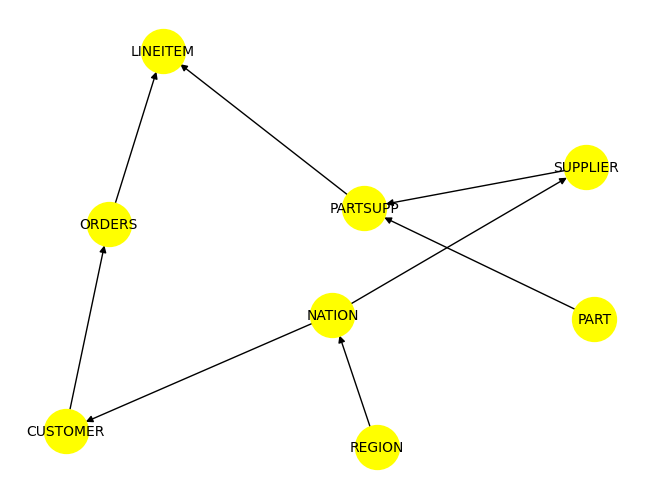

In [45]:
df_tmp = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, "TPCH_SF1", 1, show_graph=True, graph_directionality="parent_children") #'bidirectional' or 'parent_children' or 'children_parent'.
print(len(df_tmp))

Note that the internal graph stores the entity_id of the table.
172


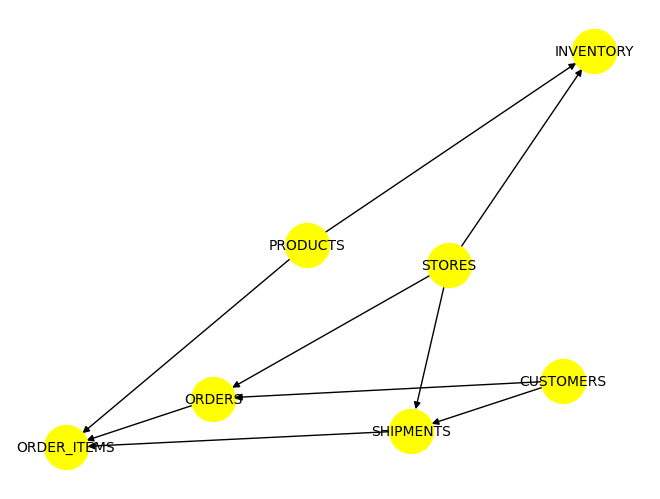

In [46]:
df_tmp = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, "OC_ORACLE", 1, show_graph=True, graph_directionality="parent_children") #'bidirectional' or 'parent_children' or 'children_parent'.
print(len(df_tmp))

### Augmentation Statistics

In [47]:
augmentation_statistic = []
schema_name = "OC_ORACLE"

df_plain = df_OC3HR[df_OC3HR.schema==schema_name]

count_tables_raw = len(df_plain[df_plain.type=="table"])
count_columns_raw = len(df_plain[df_plain.type=="column"])

augmentation_statistic.append(["raw", 0, count_tables_raw, count_columns_raw, 0, 0, count_tables_raw, count_columns_raw])

for hops in [1, 2, 3]: #no changes >= 3
    for graph_directionality in ["parent_children", "children_parent", "bidirectional"]:
        df_tmp_augmented = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, schema_name, max_hops=hops, graph_directionality=graph_directionality) 
        count_tables = len(df_tmp_augmented[df_tmp_augmented.type=="table"])
        count_columns = len(df_tmp_augmented[df_tmp_augmented.type=="column"])
        augmentation_statistic.append([graph_directionality, hops, count_tables_raw, count_columns_raw,
                                       (count_tables-count_tables_raw), (count_columns-count_columns_raw),
                                       count_tables, count_columns])

df_augmentation_statistics_ocoracle = pd.DataFrame(data=augmentation_statistic, columns=["directionality", "hops", "tables", "columns", "table_views", "aug_columns", "tot_tables", "tot_columns"])
df_augmentation_statistics_ocoracle

directionality  hops  tables  columns  table_views  aug_columns  \
0              raw     0       7       43            0            0   
1  parent_children     1       7       43            9          113   
2  children_parent     1       7       43            9          113   
3    bidirectional     1       7       43           18          226   
4  parent_children     2       7       43           11          149   
5  children_parent     2       7       43           11          149   
6    bidirectional     2       7       43           38          611   
7  parent_children     3       7       43           11          149   
8  children_parent     3       7       43           11          149   
9    bidirectional     3       7       43           42          703   

   tot_tables  tot_columns  
0           7           43  
1          16          156  
2          16          156  
3          25          269  
4          18          192  
5          18          192  
6          45          654  
7          18          192  
8          18          192  
9          49          746

In [ ]:
augmentation_statistic = []
schema_name = "OC_MYSQL"

df_plain = df_OC3HR[df_OC3HR.schema==schema_name]

count_tables_raw = len(df_plain[df_plain.type=="table"])
count_columns_raw = len(df_plain[df_plain.type=="column"])

augmentation_statistic.append(["raw", 0, count_tables_raw, count_columns_raw, 0, 0, count_tables_raw, count_columns_raw])

for hops in [1, 2, 3, 4, 5, 6]: #no changes >= 6
    for graph_directionality in ["parent_children", "children_parent", "bidirectional"]:
        df_tmp_augmented = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, schema_name, max_hops=hops, graph_directionality=graph_directionality) 
        count_tables = len(df_tmp_augmented[df_tmp_augmented.type=="table"])
        count_columns = len(df_tmp_augmented[df_tmp_augmented.type=="column"])
        augmentation_statistic.append([graph_directionality, hops, count_tables_raw, count_columns_raw,
                                       (count_tables-count_tables_raw), (count_columns-count_columns_raw),
                                       count_tables, count_columns])

df_augmentation_statistics_ocmysql = pd.DataFrame(data=augmentation_statistic, columns=["directionality", "hops", "tables", "columns", "table_views", "aug_columns", "tot_tables", "tot_columns"])
df_augmentation_statistics_ocmysql

directionality  hops  tables  columns  table_views  aug_columns  \
0               raw     0       8       59            0            0   
1   parent_children     1       8       59            7          114   
2   children_parent     1       8       59            7          114   
3     bidirectional     1       8       59           14          228   
4   parent_children     2       8       59           12          240   
5   children_parent     2       8       59           12          240   
6     bidirectional     2       8       59           28          570   
7   parent_children     3       8       59           15          344   
8   children_parent     3       8       59           15          344   
9     bidirectional     3       8       59           40          954   
10  parent_children     4       8       59           16          386   
11  children_parent     4       8       59           16          386   
12    bidirectional     4       8       59           48         1274   
13  parent_children     5       8       59           16          386   
14  children_parent     5       8       59           16          386   
15    bidirectional     5       8       59           54         1552   
16  parent_children     6       8       59           16          386   
17  children_parent     6       8       59           16          386   
18    bidirectional     6       8       59           56         1662   

    tot_tables  tot_columns  
0            8           59  
1           15          173  
2           15          173  
3           22          287  
4           20          299  
5           20          299  
6           36          629  
7           23          403  
8           23          403  
9           48         1013  
10          24          445  
11          24          445  
12          56         1333  
13          24          445  
14          24          445  
15          62         1611  
16          24          445  
17          24          445  
18          64         1721

In [ ]:
augmentation_statistic = []
schema_name = "TPCH_SF1"

df_plain = df_OC3HR[df_OC3HR.schema==schema_name]

count_tables_raw = len(df_plain[df_plain.type=="table"])
count_columns_raw = len(df_plain[df_plain.type=="column"])

augmentation_statistic.append(["raw", 0, count_tables_raw, count_columns_raw, 0, 0, count_tables_raw, count_columns_raw])

for hops in [1, 2, 3, 4]: #no changes >= 4
    for graph_directionality in ["parent_children", "children_parent", "bidirectional"]:
        df_tmp_augmented = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, schema_name, max_hops=hops, graph_directionality=graph_directionality) 
        count_tables = len(df_tmp_augmented[df_tmp_augmented.type=="table"])
        count_columns = len(df_tmp_augmented[df_tmp_augmented.type=="column"])
        augmentation_statistic.append([graph_directionality, hops, count_tables_raw, count_columns_raw,
                                       (count_tables-count_tables_raw), (count_columns-count_columns_raw),
                                       count_tables, count_columns])

df_augmentation_statistics_tpch = pd.DataFrame(data=augmentation_statistic, columns=["directionality", "hops", "tables", "columns", "table_views", "aug_columns", "tot_tables", "tot_columns"])
df_augmentation_statistics_tpch 

directionality  hops  tables  columns  table_views  aug_columns  \
0               raw     0       8       61            0            0   
1   parent_children     1       8       61            8          119   
2   children_parent     1       8       61            8          119   
3     bidirectional     1       8       61           16          238   
4   parent_children     2       8       61           15          276   
5   children_parent     2       8       61           15          276   
6     bidirectional     2       8       61           36          692   
7   parent_children     3       8       61           18          356   
8   children_parent     3       8       61           18          356   
9     bidirectional     3       8       61           50         1116   
10  parent_children     4       8       61           19          396   
11  children_parent     4       8       61           19          396   
12    bidirectional     4       8       61           56         1332   

    tot_tables  tot_columns  
0            8           61  
1           16          180  
2           16          180  
3           24          299  
4           23          337  
5           23          337  
6           44          753  
7           26          417  
8           26          417  
9           58         1177  
10          27          457  
11          27          457  
12          64         1393

In [ ]:
augmentation_statistic = []
schema_name = "SAKILA"

df_plain = df_OC3HR[df_OC3HR.schema==schema_name]

count_tables_raw = len(df_plain[df_plain.type=="table"])
count_columns_raw = len(df_plain[df_plain.type=="column"])

augmentation_statistic.append(["raw", 0, count_tables_raw, count_columns_raw, 0, 0, count_tables_raw, count_columns_raw])

for hops in [1, 2, 3, 4, 5, 6, 7]: #no changes >= ?
    for graph_directionality in ["parent_children", "children_parent", "bidirectional"]:
        df_tmp_augmented = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, schema_name, max_hops=hops, graph_directionality=graph_directionality) 
        count_tables = len(df_tmp_augmented[df_tmp_augmented.type=="table"])
        count_columns = len(df_tmp_augmented[df_tmp_augmented.type=="column"])
        augmentation_statistic.append([graph_directionality, hops, count_tables_raw, count_columns_raw,
                                       (count_tables-count_tables_raw), (count_columns-count_columns_raw),
                                       count_tables, count_columns])

df_augmentation_statistics_sakila = pd.DataFrame(data=augmentation_statistic, columns=["directionality", "hops", "tables", "columns", "table_views", "aug_columns", "tot_tables", "tot_columns"])
df_augmentation_statistics_sakila

directionality  hops  tables  columns  table_views  aug_columns  \
0               raw     0      15       70            0            0   
1   parent_children     1      15       70           21          242   
2   children_parent     1      15       70           21          242   
3     bidirectional     1      15       70           40          460   
4   parent_children     2      15       70           37          513   
5   children_parent     2      15       70           37          513   
6     bidirectional     2      15       70           86         1242   
7   parent_children     3      15       70           45          683   
8   children_parent     3      15       70           45          683   
9     bidirectional     3      15       70          130         2179   
10  parent_children     4      15       70           49          782   
11  children_parent     4      15       70           49          782   
12    bidirectional     4      15       70          172         3296   
13  parent_children     5      15       70           49          782   
14  children_parent     5      15       70           49          782   
15    bidirectional     5      15       70          196         4034   
16  parent_children     6      15       70           49          782   
17  children_parent     6      15       70           49          782   
18    bidirectional     6      15       70          206         4356   
19  parent_children     7      15       70           49          782   
20  children_parent     7      15       70           49          782   
21    bidirectional     7      15       70          210         4494   

    tot_tables  tot_columns  
0           15           70  
1           36          312  
2           36          312  
3           55          530  
4           52          583  
5           52          583  
6          101         1312  
7           60          753  
8           60          753  
9          145         2249  
10          64          852  
11          64          852  
12         187         3366  
13          64          852  
14          64          852  
15         211         4104  
16          64          852  
17          64          852  
18         221         4426  
19          64          852  
20          64          852  
21         225         4564

## b) Serialization and Embedding

In [49]:
# verbose

#SerReference
vserialization=["column_vsequence", "parent_vsequence", "dtype_vsequence", "constraint_vsequence", "instance_vsequence", "childrens_vsequence", "parents_vsequence"]

vserialization_parent=["parent_vsequence"]

#SerMagneto
vserialization_exP =["column_vsequence", "dtype_vsequence", "constraint_vsequence", "instance_vsequence", "childrens_vsequence", "parents_vsequence"]

#SerSchemaReference
vserialization_exI=["column_vsequence", "parent_vsequence", "dtype_vsequence", "constraint_vsequence", "childrens_vsequence", "parents_vsequence"]

#SerValues
vserialization_exCHP =["column_vsequence", "parent_vsequence", "dtype_vsequence", "constraint_vsequence", "instance_vsequence"]

#SerSchema
vserialization_exICHP=["column_vsequence", "parent_vsequence", "dtype_vsequence", "constraint_vsequence"]


In [50]:
class Entity:
    def __init__(
        self, entity_id, name, type, schema, parent_id, parent_onehot=None, datatype=None, constraints=None, text_sequence=None, instance_sequence=None,
        augmented=False, hops=0, ref_id=None
    ):
        self.entity_id = entity_id
        self.name = name
        self.type = type
        self.schema = schema
        self.parent_id = parent_id
        self.parent_onehot = parent_onehot
        self.datatype = datatype
        self.constraints = constraints
        self.text_sequence = text_sequence
        self.instance_sequence = instance_sequence
        self.augmented = augmented
        self.hops = hops
        self.ref_id = ref_id
        
    def __repr__(self):
        return (
            f"Entity( entity_id: {self.entity_id}, name: {self.name}, type: {self.type}, schema: {self.schema}, parent_id: {self.parent_id}, datatype: {self.datatype}, constraints: {self.constraints}, text_sequence)"
        )
    def get_text_sequence(self):
        return self.text_sequence
    def get_instance_sequence(self):
        return self.instance_sequence

In [51]:
def get_entity_signatures(entities, variant="text_sequence"):
    entity_signatures = []
    for entity in entities:
        value = getattr(entity, variant)
        if isinstance(value, np.ndarray):
            entity_signatures.append(value)
        elif isinstance(value, str):
            entity_signatures.append(value)
        else:
            # Assuming tensor-like object that needs conversion to numpy
            try:
                entity_signatures.append(value.numpy())
            except AttributeError:
                entity_signatures.append(value)  # In case it's already a number or not convertible
    return np.array(entity_signatures)

In [52]:
def get_entities_from_df(df, model_name='sentence-transformers/all-mpnet-base-v2', serialization="text_sequence", verbose=True, concat="serialization", df_references_ids=None):
    entities = []
    df = df.copy()
    model = SentenceTransformer(model_name)
    # model = SentenceTransformer(sentence-transformers/all-mpnet-base-v2)
    if serialization == "text_sequence":
        text_sequence = model.encode(df[serialization].values)
    if isinstance(serialization, list) and (concat == "embedding"):
        # ["column_vsequence", "parent_vsequence", "dtype_vsequence", "constraint_vsequence", "instance_vsequence", "childrens_vsequence", "parents_vsequence"]
        embedding_dict = {}
        for serialzation_column in serialization:
            print("Encoding " + serialzation_column)
            if verbose and ("column" not in serialzation_column):
                df_ser_col = "[CLS] Column: " + df['name'] + " [SEP] " + df[serialzation_column]
            else:
                df_ser_col = df[serialzation_column]
            df_ser_col = df_ser_col.astype(str)
            embedding_dict[serialzation_column] = model.encode(df_ser_col.values)
        text_sequence = np.concatenate(list(embedding_dict.values()), axis=1)
        for serialzation_column in serialization:
            prefix = "[CLS] Column: " if verbose else "[CLS] "
            print(prefix + df.iloc[1]['name'] + " [SEP] " + df.iloc[1][serialzation_column])
    elif isinstance(serialization, list) and (concat == "serialization"):
        df["text_sequence"] = "[CLS] " + df[serialization].astype(str).agg(" [SEP] ".join, axis=1)
        text_sequence = model.encode(df["text_sequence"].values)
        print(df.iloc[1]["text_sequence"])

    if "hops" not in df.columns:
        df["hops"] = 0
    
    #extract raw table IDs (no views)
    unique_parent_ids = list(df[(df.type == "column") & (df.hops == 0)]["parent_id"].unique())
    # print(unique_parent_ids)
    id_to_index = {pid: i for i, pid in enumerate(unique_parent_ids)}
    print(id_to_index)
    parent_onehot = np.zeros((len(df), len(unique_parent_ids)), dtype=float) 
    
    alpha_decay = 0.5
    if isinstance(df_references_ids, pd.DataFrame):
        G = nx.Graph()
        for _, ref in df_OC3HR_references_ids.iterrows():
            pt, ct = ref['PARENT_TABLE'], ref['CHILD_TABLE']
            G.add_edge(pt, ct)
    else:
        weight = np.exp(-alpha_decay * 1)
        # np.exp(-alpha_decay*(idx)) 
        # exponential decay with hops
        # # np.exp(-0.5 * 0) #> 1
        # # np.exp(-0.5 * 1) #> 0.606
        # # np.exp(-0.5 * 2) #> 0.368

    # Iterate through each row and set the corresponding hot-encoded values
    for index, row in df.reset_index(drop=True).iterrows(): # Use .iterrows() to access other columns like 'ref_id'
        if row["type"] == "table":
            continue
        
        parent_entry = row["parent_id"]
        if "," in parent_entry:
            parent_ids_list = parent_entry.split(", ")
            strong_pid = df[df.id == row["ref_id"]].parent_id.values[0]
            #the paths are sorted based on the actual traversal
            for idx, pid in enumerate(parent_ids_list):
                if pid in id_to_index:
                    if pid == strong_pid:
                        parent_onehot[index, id_to_index[pid]] = 1.0 
                    else:
                        if isinstance(df_references_ids, pd.DataFrame):
                            dist = len(nx.shortest_path(G, source=strong_pid, target=pid)) - 1
                            parent_onehot[index, id_to_index[pid]] = np.exp(-alpha_decay * dist)
                        else: 
                            parent_onehot[index, id_to_index[pid]] = weight

        else: # Non-augmented column (single parent ID)
            if parent_entry in id_to_index:
                parent_onehot[index, id_to_index[parent_entry]] = 1.0

    for index, row in df.reset_index(drop=True).iterrows():
        entity = Entity(
            entity_id=row["id"],
            name=row["name"],
            type=row["type"],
            schema=row["schema"],
            parent_id=row["parent_id"],
            parent_onehot=parent_onehot[index],
            datatype=row["datatype"],
            constraints=row["constraints"],
            text_sequence=text_sequence[index],
            augmented=row["augmented"] if "augmented" in df.columns else False,
            hops=row["hops"] if "hops" in df.columns else 0,
            ref_id=row["ref_id"] if "ref_id" in df.columns else None
        )
        entity.serialization = row["text_sequence"]
        entities.append(entity)

    return entities

In [ ]:
signatures_OC3HR = get_entities_from_df(df_OC3HR, df_references_ids = df_OC3HR_references_ids)

### OC_ORACLE

In [53]:
entities_ocoracle = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_ORACLE")], serialization=vserialization, concat="embedding", verbose=True)
entities_ocoracle_ser = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_ORACLE")], serialization=vserialization, concat="serialization", verbose=True)
entities_ocoracle_ser_exCHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_ORACLE")], serialization=vserialization_exCHP, concat="serialization", verbose=True)
entities_ocoracle_ser_exICHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_ORACLE")], serialization=vserialization_exICHP, concat="serialization", verbose=True)


Encoding column_vsequence
Encoding parent_vsequence
Encoding dtype_vsequence
Encoding constraint_vsequence
Encoding instance_vsequence
Encoding childrens_vsequence
Encoding parents_vsequence
[CLS] Column: EMAIL_ADDRESS [SEP] Column: EMAIL_ADDRESS
[CLS] Column: EMAIL_ADDRESS [SEP] Table: CUSTOMERS
[CLS] Column: EMAIL_ADDRESS [SEP] Type: VARCHAR2
[CLS] Column: EMAIL_ADDRESS [SEP] Constraint: None
[CLS] Column: EMAIL_ADDRESS [SEP] Values: {dania.grizzard@internalmail, adan.lamica@internalmail, frank.perez@internalmail, margaret.bennett@internalmail, james.smith@internalmail}
[CLS] Column: EMAIL_ADDRESS [SEP] Weak Tables: ORDERS SHIPMENTS
[CLS] Column: EMAIL_ADDRESS [SEP] Strong Tables: None
{'entity_44': 0, 'entity_48': 1, 'entity_53': 2, 'entity_60': 3, 'entity_66': 4, 'entity_76': 5, 'entity_82': 6}
[CLS] Column: EMAIL_ADDRESS [SEP] Table: CUSTOMERS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {dania.grizzard@internalmail, adan.lamica@internalmail, frank.perez@internalmail,

In [46]:
get_entity_by_entity_id(entities_ocoracle_ser, "entity_77").serialization

'[CLS] Column: SHIPMENT_ID [SEP] Table: SHIPMENTS [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {1536, 907, 745, 38, 1210} [SEP] Weak Tables: ORDER_ITEMS [SEP] Strong Tables: CUSTOMERS STORES'

In [55]:
get_entity_by_entity_id(entities_ocoracle_ser_exICHP, "entity_80").serialization

'[CLS] Column: DELIVERY_ADDRESS [SEP] Table: SHIPMENTS [SEP] Type: VARCHAR2 [SEP] Constraint: None'

In [103]:
df_ocoracle_augmented_hop1 = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, "OC_ORACLE", max_hops=1, graph_directionality="parent_children") #parent_children children_parent

In [291]:
entities_ocoracle_augmented_hop1 = get_entities_from_df(df_ocoracle_augmented_hop1, serialization=vserialization, concat="embedding", verbose=True, df_references_ids=df_OC3HR_references_ids)
print(len(entities_ocoracle_augmented_hop1)) #includes tables
entities_ocoracle_augmented_hop1 = get_entities_of_type(entities_ocoracle_augmented_hop1, ["column"])
print(len(entities_ocoracle_augmented_hop1))

Encoding column_vsequence
Encoding parent_vsequence
Encoding dtype_vsequence
Encoding constraint_vsequence
Encoding instance_vsequence
Encoding childrens_vsequence
Encoding parents_vsequence
[CLS] Column: CUSTOMER_ID [SEP] Column: CUSTOMER_ID
[CLS] Column: CUSTOMER_ID [SEP] Table: CUSTOMERS
[CLS] Column: CUSTOMER_ID [SEP] Type: NUMBER
[CLS] Column: CUSTOMER_ID [SEP] Constraint: PRIMARY KEY
[CLS] Column: CUSTOMER_ID [SEP] Values: {22, 261, 310, 379, 367}
[CLS] Column: CUSTOMER_ID [SEP] Weak Tables: ORDERS SHIPMENTS
[CLS] Column: CUSTOMER_ID [SEP] Strong Tables: None
{'entity_44': 0, 'entity_48': 1, 'entity_53': 2, 'entity_60': 3, 'entity_66': 4, 'entity_76': 5, 'entity_82': 6}
172
156


In [292]:
entities_ocoracle_augmented_hop1_ser = get_entities_from_df(df_ocoracle_augmented_hop1, serialization=vserialization, concat="serialization", verbose=True, df_references_ids=df_OC3HR_references_ids)
entities_ocoracle_augmented_hop1_ser = get_entities_of_type(entities_ocoracle_augmented_hop1_ser, ["column"])

[CLS] Column: CUSTOMER_ID [SEP] Table: CUSTOMERS [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {22, 261, 310, 379, 367} [SEP] Weak Tables: ORDERS SHIPMENTS [SEP] Strong Tables: None
{'entity_44': 0, 'entity_48': 1, 'entity_53': 2, 'entity_60': 3, 'entity_66': 4, 'entity_76': 5, 'entity_82': 6}


In [58]:
get_entity_by_ref_id(entities_ocoracle_augmented_hop1_ser, "entity_80").serialization

'[CLS] Column: DELIVERY_ADDRESS [SEP] Table: SHIPMENTS ORDER_ITEMS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {Brush Creek, TN 38547 USA, Dorchester, IA 52140 USA, Walford, IA 52351 USA, Inwood, NY 11096 USA, Salisbury, PA 15558 USA} [SEP] None [SEP] Strong Tables: CUSTOMERS STORES ORDERS PRODUCTS'

In [104]:
entities_ocoracle_augmented_hop1_ser_exCHP = get_entities_from_df(df_ocoracle_augmented_hop1, serialization=vserialization_exCHP, concat="serialization", verbose=True, df_references_ids=df_OC3HR_references_ids)
entities_ocoracle_augmented_hop1_ser_exCHP = get_entities_of_type(entities_ocoracle_augmented_hop1_ser_exCHP, ["column"])

[CLS] Column: CUSTOMER_ID [SEP] Table: CUSTOMERS [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {22, 261, 310, 379, 367}
{'entity_44': 0, 'entity_48': 1, 'entity_53': 2, 'entity_60': 3, 'entity_66': 4, 'entity_76': 5, 'entity_82': 6}


### OC_MYSQL

In [ ]:
entities_ocmysql = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_MYSQL")], serialization=vserialization, concat="embedding", verbose=True)
entities_ocmysql_ser = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_MYSQL")], serialization=vserialization, concat="serialization", verbose=True)
entities_ocmysql_ser_exCHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_MYSQL")], serialization=vserialization_exCHP, concat="serialization", verbose=True)

Encoding column_vsequence
Encoding parent_vsequence
Encoding dtype_vsequence
Encoding constraint_vsequence
Encoding instance_vsequence
Encoding childrens_vsequence
Encoding parents_vsequence
[CLS] Column: CUSTOMERNAME [SEP] Column: CUSTOMERNAME
[CLS] Column: CUSTOMERNAME [SEP] Table: CUSTOMERS
[CLS] Column: CUSTOMERNAME [SEP] Type: VARCHAR2
[CLS] Column: CUSTOMERNAME [SEP] Constraint: None
[CLS] Column: CUSTOMERNAME [SEP] Values: {L'ordine Souveniers, Online Mini Collectables, Gift Depot Inc., Warburg Exchange, NatÃ¯Â¿Â½rlich Autos}
[CLS] Column: CUSTOMERNAME [SEP] Weak Tables: ORDERS PAYMENTS
[CLS] Column: CUSTOMERNAME [SEP] Strong Tables: EMPLOYEES
{'entity_95': 0, 'entity_109': 1, 'entity_118': 2, 'entity_128': 3, 'entity_134': 4, 'entity_142': 5, 'entity_147': 6, 'entity_152': 7}
[CLS] Column: CUSTOMERNAME [SEP] Table: CUSTOMERS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {L'ordine Souveniers, Online Mini Collectables, Gift Depot Inc., Warburg Exchange, NatÃ¯Â¿Â½rlich

In [60]:
entities_ocmysql_ser[0].serialization

'[CLS] Column: CUSTOMERNUMBER [SEP] Table: CUSTOMERS [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {151, 456, 386, 168, 157} [SEP] Weak Tables: ORDERS PAYMENTS [SEP] Strong Tables: EMPLOYEES'

In [105]:
df_ocmysql_augmented_hop1 = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, "OC_MYSQL", max_hops=1, graph_directionality="parent_children")

In [293]:
entities_ocmysql_augmented_hop1 = get_entities_from_df(df_ocmysql_augmented_hop1, serialization=vserialization, concat="embedding", verbose=True, df_references_ids=df_OC3HR_references_ids)
print(len(entities_ocmysql_augmented_hop1)) #includes tables
entities_ocmysql_augmented_hop1 = get_entities_of_type(entities_ocmysql_augmented_hop1, ["column"])
print(len(entities_ocmysql_augmented_hop1))

Encoding column_vsequence
Encoding parent_vsequence
Encoding dtype_vsequence
Encoding constraint_vsequence
Encoding instance_vsequence
Encoding childrens_vsequence
Encoding parents_vsequence
[CLS] Column: CUSTOMERNUMBER [SEP] Column: CUSTOMERNUMBER
[CLS] Column: CUSTOMERNUMBER [SEP] Table: CUSTOMERS
[CLS] Column: CUSTOMERNUMBER [SEP] Type: NUMBER
[CLS] Column: CUSTOMERNUMBER [SEP] Constraint: PRIMARY KEY
[CLS] Column: CUSTOMERNUMBER [SEP] Values: {151, 456, 386, 168, 157}
[CLS] Column: CUSTOMERNUMBER [SEP] Weak Tables: ORDERS PAYMENTS
[CLS] Column: CUSTOMERNUMBER [SEP] Strong Tables: EMPLOYEES
{'entity_95': 0, 'entity_109': 1, 'entity_118': 2, 'entity_128': 3, 'entity_134': 4, 'entity_142': 5, 'entity_147': 6, 'entity_152': 7}
188
173


In [294]:
entities_ocmysql_augmented_hop1_ser = get_entities_from_df(df_ocmysql_augmented_hop1, serialization=vserialization, concat="serialization", verbose=True, df_references_ids=df_OC3HR_references_ids)
entities_ocmysql_augmented_hop1_ser = get_entities_of_type(entities_ocmysql_augmented_hop1_ser, ["column"])

[CLS] Column: CUSTOMERNUMBER [SEP] Table: CUSTOMERS [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {151, 456, 386, 168, 157} [SEP] Weak Tables: ORDERS PAYMENTS [SEP] Strong Tables: EMPLOYEES
{'entity_95': 0, 'entity_109': 1, 'entity_118': 2, 'entity_128': 3, 'entity_134': 4, 'entity_142': 5, 'entity_147': 6, 'entity_152': 7}


In [106]:
entities_ocmysql_augmented_hop1_ser_exCHP = get_entities_from_df(df_ocmysql_augmented_hop1, serialization=vserialization_exCHP, concat="serialization", verbose=True, df_references_ids=df_OC3HR_references_ids)
entities_ocmysql_augmented_hop1_ser_exCHP = get_entities_of_type(entities_ocmysql_augmented_hop1_ser_exCHP, ["column"])

[CLS] Column: CUSTOMERNUMBER [SEP] Table: CUSTOMERS [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {151, 456, 386, 168, 157}
{'entity_95': 0, 'entity_109': 1, 'entity_118': 2, 'entity_128': 3, 'entity_134': 4, 'entity_142': 5, 'entity_147': 6, 'entity_152': 7}


### TPCH

In [ ]:
entities_tpch = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="TPCH_SF1")], serialization=vserialization, concat="embedding", verbose=True)
entities_tpch_ser = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="TPCH_SF1")], serialization=vserialization, concat="serialization", verbose=True)
entities_tpch_ser_exCHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="TPCH_SF1")], serialization=vserialization_exCHP, concat="serialization", verbose=True)


Encoding column_vsequence
Encoding parent_vsequence
Encoding dtype_vsequence
Encoding constraint_vsequence
Encoding instance_vsequence
Encoding childrens_vsequence
Encoding parents_vsequence
[CLS] Column: C_NAME [SEP] Column: C_NAME
[CLS] Column: C_NAME [SEP] Table: CUSTOMER
[CLS] Column: C_NAME [SEP] Type: VARCHAR2
[CLS] Column: C_NAME [SEP] Constraint: None
[CLS] Column: C_NAME [SEP] Values: {Customer#000000004, Customer#000000005, Customer#000000006, Customer#000000007, Customer#000000008}
[CLS] Column: C_NAME [SEP] Weak Tables: ORDERS
[CLS] Column: C_NAME [SEP] Strong Tables: NATION
{'entity_207': 0, 'entity_216': 1, 'entity_233': 2, 'entity_238': 3, 'entity_248': 4, 'entity_258': 5, 'entity_264': 6, 'entity_268': 7}
[CLS] Column: C_NAME [SEP] Table: CUSTOMER [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {Customer#000000004, Customer#000000005, Customer#000000006, Customer#000000007, Customer#000000008} [SEP] Weak Tables: ORDERS [SEP] Strong Tables: NATION
{'entity_207'

In [64]:
get_entity_by_entity_id(entities_tpch_ser, "entity_210").serialization

'[CLS] Column: C_ADDRESS [SEP] Table: CUSTOMER [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {4u58h fqkyE, hwBtxkoBF qSW4KrIk5U 2B1AU7H,  g1s,pzDenUEBW3O,2 pxu0f9n2g64rJrt5E, 8OkMVLQ1dK6Mbu6WG9 w4pLGQ n7MQ, j,pZ,Qp,qtFEo0r0c 92qobZtlhSuOqbE4JGV} [SEP] Weak Tables: ORDERS [SEP] Strong Tables: NATION'

In [107]:
df_tpch_augmented_hop1 = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, "TPCH_SF1", max_hops=1, graph_directionality="parent_children") 

In [295]:

entities_tpch_augmented_hop1 = get_entities_from_df(df_tpch_augmented_hop1, serialization=vserialization, concat="embedding", verbose=True, df_references_ids=df_OC3HR_references_ids)
print(len(entities_tpch_augmented_hop1)) #includes tables
entities_tpch_augmented_hop1 = get_entities_of_type(entities_tpch_augmented_hop1, ["column"])
print(len(entities_tpch_augmented_hop1))

Encoding column_vsequence
Encoding parent_vsequence
Encoding dtype_vsequence
Encoding constraint_vsequence
Encoding instance_vsequence
Encoding childrens_vsequence
Encoding parents_vsequence
[CLS] Column: C_CUSTKEY [SEP] Column: C_CUSTKEY
[CLS] Column: C_CUSTKEY [SEP] Table: CUSTOMER
[CLS] Column: C_CUSTKEY [SEP] Type: NUMBER
[CLS] Column: C_CUSTKEY [SEP] Constraint: PRIMARY KEY
[CLS] Column: C_CUSTKEY [SEP] Values: {4, 5, 6, 7, 8}
[CLS] Column: C_CUSTKEY [SEP] Weak Tables: ORDERS
[CLS] Column: C_CUSTKEY [SEP] Strong Tables: NATION
{'entity_207': 0, 'entity_216': 1, 'entity_233': 2, 'entity_238': 3, 'entity_248': 4, 'entity_258': 5, 'entity_264': 6, 'entity_268': 7}
196
180


In [296]:
entities_tpch_augmented_hop1_ser = get_entities_from_df(df_tpch_augmented_hop1, serialization=vserialization, concat="serialization", verbose=True, df_references_ids=df_OC3HR_references_ids)
entities_tpch_augmented_hop1_ser = get_entities_of_type(entities_tpch_augmented_hop1_ser, ["column"])

[CLS] Column: C_CUSTKEY [SEP] Table: CUSTOMER [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {4, 5, 6, 7, 8} [SEP] Weak Tables: ORDERS [SEP] Strong Tables: NATION
{'entity_207': 0, 'entity_216': 1, 'entity_233': 2, 'entity_238': 3, 'entity_248': 4, 'entity_258': 5, 'entity_264': 6, 'entity_268': 7}


In [108]:
entities_tpch_augmented_hop1_ser_exCHP = get_entities_from_df(df_tpch_augmented_hop1, serialization=vserialization_exCHP, concat="serialization", verbose=True, df_references_ids=df_OC3HR_references_ids)
entities_tpch_augmented_hop1_ser_exCHP = get_entities_of_type(entities_tpch_augmented_hop1_ser_exCHP, ["column"])

[CLS] Column: C_CUSTKEY [SEP] Table: CUSTOMER [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {4, 5, 6, 7, 8}
{'entity_207': 0, 'entity_216': 1, 'entity_233': 2, 'entity_238': 3, 'entity_248': 4, 'entity_258': 5, 'entity_264': 6, 'entity_268': 7}


In [67]:
# df_tpch_augmented_hop1[df_tpch_augmented_hop1.parent_name =="NATION CUSTOMER"]

In [68]:
entities_tpch_augmented_hop1_ser[103].serialization

'[CLS] Column: C_MKTSEGMENT [SEP] Table: CUSTOMER ORDERS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {MACHINERY, HOUSEHOLD, AUTOMOBILE, AUTOMOBILE, BUILDING} [SEP] Weak Tables: LINEITEM [SEP] Strong Tables: NATION'

### SAKILA

In [ ]:
entities_sakila = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="SAKILA")], serialization=vserialization, concat="embedding", verbose=True)
entities_sakila_ser = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="SAKILA")], serialization=vserialization, concat="serialization", verbose=True)
entities_sakila_ser_exCHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="SAKILA")], serialization=vserialization_exCHP, concat="serialization", verbose=True)

Encoding column_vsequence
Encoding parent_vsequence
Encoding dtype_vsequence
Encoding constraint_vsequence
Encoding instance_vsequence
Encoding childrens_vsequence
Encoding parents_vsequence
[CLS] Column: FIRST_NAME [SEP] Column: FIRST_NAME
[CLS] Column: FIRST_NAME [SEP] Table: ACTOR
[CLS] Column: FIRST_NAME [SEP] Type: VARCHAR2
[CLS] Column: FIRST_NAME [SEP] Constraint: None
[CLS] Column: FIRST_NAME [SEP] Values: {BETTE, VIVIEN, JAMES, ANGELA, CARY}
[CLS] Column: FIRST_NAME [SEP] Weak Tables: FILM_ACTOR
[CLS] Column: FIRST_NAME [SEP] Strong Tables: None
{'entity_277': 0, 'entity_281': 1, 'entity_289': 2, 'entity_292': 3, 'entity_296': 4, 'entity_299': 5, 'entity_308': 6, 'entity_321': 7, 'entity_324': 8, 'entity_327': 9, 'entity_331': 10, 'entity_334': 11, 'entity_341': 12, 'entity_348': 13, 'entity_358': 14}
[CLS] Column: FIRST_NAME [SEP] Table: ACTOR [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {BETTE, VIVIEN, JAMES, ANGELA, CARY} [SEP] Weak Tables: FILM_ACTOR [SEP] Str

In [109]:
df_sakila_augmented_hop1 = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, "SAKILA", max_hops=1, graph_directionality="parent_children") 

In [297]:

entities_sakila_augmented_hop1 = get_entities_from_df(df_sakila_augmented_hop1, serialization=vserialization, concat="embedding", verbose=True, df_references_ids=df_OC3HR_references_ids)
print(len(entities_sakila_augmented_hop1)) #includes tables
entities_sakila_augmented_hop1 = get_entities_of_type(entities_sakila_augmented_hop1, ["column"])
print(len(entities_sakila_augmented_hop1))

Encoding column_vsequence
Encoding parent_vsequence
Encoding dtype_vsequence
Encoding constraint_vsequence
Encoding instance_vsequence
Encoding childrens_vsequence
Encoding parents_vsequence
[CLS] Column: ACTOR_ID [SEP] Column: ACTOR_ID
[CLS] Column: ACTOR_ID [SEP] Table: ACTOR
[CLS] Column: ACTOR_ID [SEP] Type: NUMBER
[CLS] Column: ACTOR_ID [SEP] Constraint: PRIMARY KEY
[CLS] Column: ACTOR_ID [SEP] Values: {194, 40, 137, 104, 126}
[CLS] Column: ACTOR_ID [SEP] Weak Tables: FILM_ACTOR
[CLS] Column: ACTOR_ID [SEP] Strong Tables: None
{'entity_277': 0, 'entity_281': 1, 'entity_289': 2, 'entity_292': 3, 'entity_296': 4, 'entity_299': 5, 'entity_308': 6, 'entity_321': 7, 'entity_324': 8, 'entity_327': 9, 'entity_331': 10, 'entity_334': 11, 'entity_341': 12, 'entity_348': 13, 'entity_358': 14}
348
312


In [298]:
entities_sakila_augmented_hop1_ser = get_entities_from_df(df_sakila_augmented_hop1, serialization=vserialization, concat="serialization", verbose=True, df_references_ids=df_OC3HR_references_ids)
entities_sakila_augmented_hop1_ser = get_entities_of_type(entities_sakila_augmented_hop1_ser, ["column"])

[CLS] Column: ACTOR_ID [SEP] Table: ACTOR [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {194, 40, 137, 104, 126} [SEP] Weak Tables: FILM_ACTOR [SEP] Strong Tables: None
{'entity_277': 0, 'entity_281': 1, 'entity_289': 2, 'entity_292': 3, 'entity_296': 4, 'entity_299': 5, 'entity_308': 6, 'entity_321': 7, 'entity_324': 8, 'entity_327': 9, 'entity_331': 10, 'entity_334': 11, 'entity_341': 12, 'entity_348': 13, 'entity_358': 14}


In [110]:
entities_sakila_augmented_hop1_ser_exCHP = get_entities_from_df(df_sakila_augmented_hop1, serialization=vserialization_exCHP, concat="serialization", verbose=True, df_references_ids=df_OC3HR_references_ids)
entities_sakila_augmented_hop1_ser_exCHP = get_entities_of_type(entities_sakila_augmented_hop1_ser_exCHP, ["column"])

[CLS] Column: ACTOR_ID [SEP] Table: ACTOR [SEP] Type: NUMBER [SEP] Constraint: PRIMARY KEY [SEP] Values: {194, 40, 137, 104, 126}
{'entity_277': 0, 'entity_281': 1, 'entity_289': 2, 'entity_292': 3, 'entity_296': 4, 'entity_299': 5, 'entity_308': 6, 'entity_321': 7, 'entity_324': 8, 'entity_327': 9, 'entity_331': 10, 'entity_334': 11, 'entity_341': 12, 'entity_348': 13, 'entity_358': 14}


## Visualization

In [184]:
from matplotlib.lines import Line2D

In [186]:
def entity_index_by_id(entities, entity_id):
  entities_filter = [entity for entity in entities if entity.entity_id == entity_id]
  if len(entities_filter) > 0:
    return entities.index(entities_filter[0])
  else:
    return None

In [196]:
source_dict = {"OC_ORACLE": "tab:red", "OC_MYSQL": "tab:orange", "TPCH_SF1": "tab:blue"}
source_dict_marker = {"OC_ORACLE": "v", "OC_MYSQL": "s", "TPCH_SF1": "8"}

In [203]:
def pca_visualization(entities, gt, filter_table_ids=None):
    if filter_table_ids:
        entities = [entity for entity in entities if entity.parent_id in filter_table_ids]
    
    nComp=2
    scaler = MinMaxScaler(feature_range = (0,1))
    signatures = get_entity_signatures(entities, "text_sequence")
    signatures = scaler.fit_transform(signatures)
    mu = np.mean(signatures, axis=0)
    pca = sklearn.decomposition.PCA(n_components=nComp)
    pca.fit(signatures)
    signatures_reduced = pca.transform(signatures)

    # change direction of plot (-)
    # signatures_reduced = [(-x, -y) for y, x in signatures_reduced] 

    sources = []
    texts = [] 
    
    fig, ax = plt.subplots(figsize=(14, 14))    
    #plot entities
    for i, entity in enumerate(entities):
        plt.plot(signatures_reduced[i][0], signatures_reduced[i][1], source_dict_marker[entity.schema],
                 c=source_dict[entity.schema], markersize=10, alpha=.7)
        
        texts.append(ax.annotate(entities[i].name, (signatures_reduced[i][0], signatures_reduced[i][1]), fontsize=12))
        sources.append(entity.schema)

    adjust_text(texts, force_explode=(0.1, 0.8), arrowprops=dict(arrowstyle='-', color='gray', lw=1, alpha=0.7))

    linkage_count=0
    #plot linkages
    for linkage in gt:
        #linkage contains set of two CONCEPT ids e.g., ("CONCEPT_1, CONCEPT_2")
        a_index = entity_index_by_id(entities, linkage[0])
        b_index = entity_index_by_id(entities, linkage[1])
        if a_index != None and b_index != None:
            linkage_count=linkage_count+1
            plt.plot([signatures_reduced[a_index][0], signatures_reduced[b_index][0]],
                     [signatures_reduced[a_index][1], signatures_reduced[b_index][1]],
                     linestyle="dashed", color="black", alpha=0.7)
    
    legend_elements =[]
    linkages_text = "Linkages (" + str(linkage_count) + ")"
    title_text = "Encoded Columns (PCA) of Three Matching Schemas."

    for source in sorted(set(sources)):
        legend_elements.append(Line2D([0], [0], marker=source_dict_marker[source], color='w', label=source, markerfacecolor=source_dict[source], markersize=13))
    legend_elements.append(Line2D([0], [0], color='dimgray', label=linkages_text, markerfacecolor="black", linestyle='dashed'))
    plt.legend(handles=legend_elements, prop={'size': 12})
    plt.title(title_text)
    plt.show()

In [199]:
table_ids_ocmysql = ["entity_95", #customers
                     "entity_142", #payments
                     "entity_134"]#, #orders
                    #  "entity_128"] #order_details

table_ids_ocoracle = ["entity_44", #customers 
                      "entity_60", #orders
                      # "entity_53", #order items
                      "entity_76", #shiptments
                      "entity_109"] #employees

table_ids_tpch = ["entity_207", #customers
                #   "entity_216", #lineitem
                  # "entity_268", #supplier
                  "entity_238", #orders
                  "entity_233", #nation
                  "entity_264"] #region

filter_table_ids = table_ids_ocmysql + table_ids_ocoracle + table_ids_tpch

In [188]:
entities_OC2TPCH = get_entities_of_type(get_entity_collection_by_sources(['OC_ORACLE', 'OC_MYSQL', 'TPCH_SF1'], signatures_OC3HR), ["column"])

In [189]:
len(entities_OC2TPCH[0].text_sequence)

768

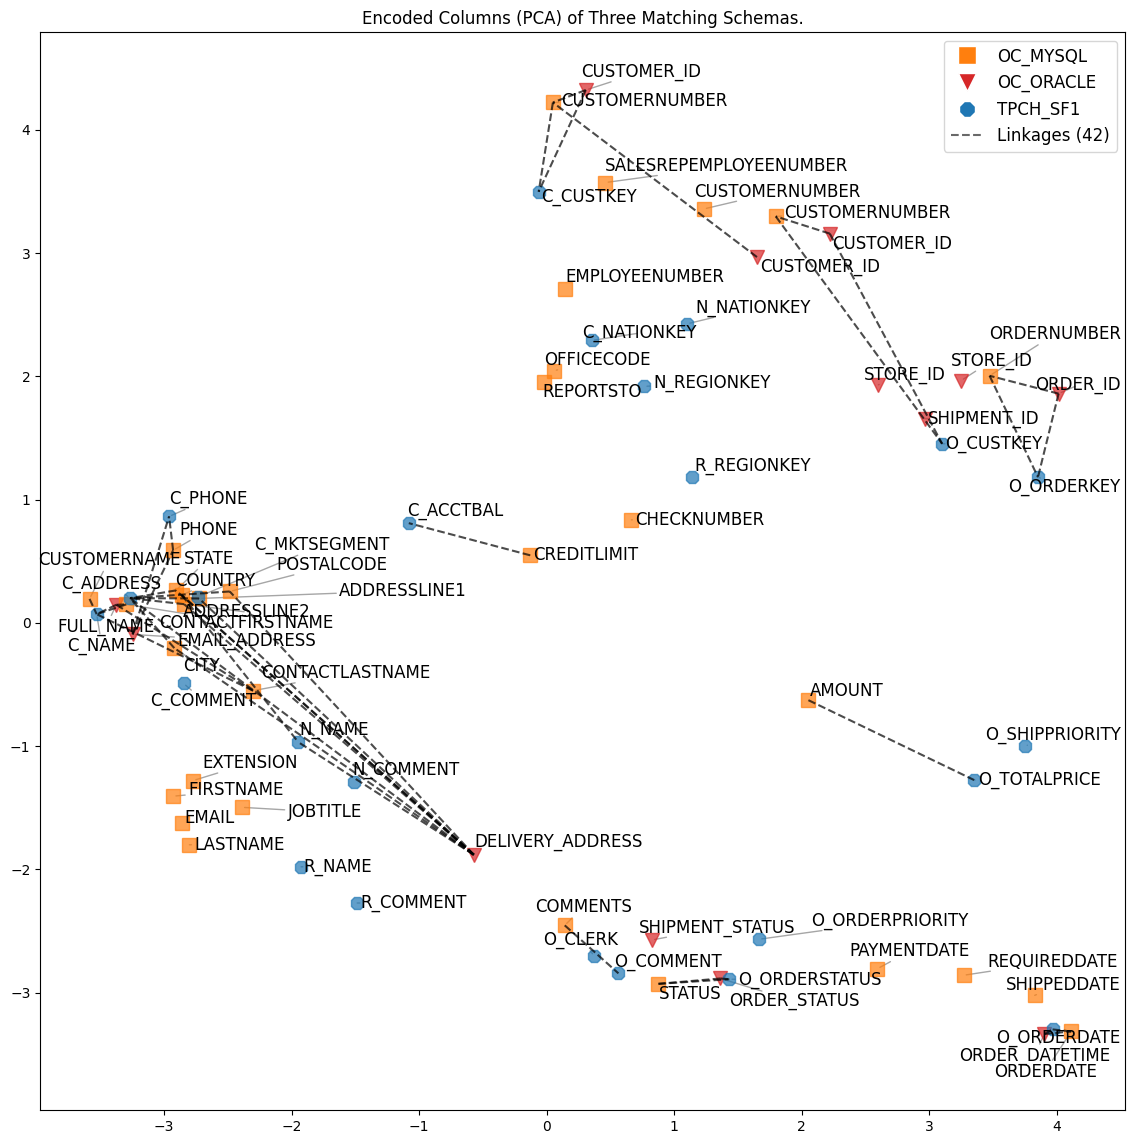

In [204]:
pca_visualization(entities_OC2TPCH, gt_TPCHOC2_column_dict["all_pairs"], filter_table_ids)

In [195]:
# concat = serialization
# pca_visualization(entities_OC2TPCH, gt_TPCHOC2_column_dict["all_pairs"])#, filter_table_ids)

# II. Self-Supervised Schema Learning

## RACT Neural Network

In [229]:
def multi_label_focal_loss(gamma=2.0, alpha=0.9):
    def focal_loss_fn(y_true, y_pred):
        # Clip the prediction to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # Calculate the cross-entropy loss
        bce = y_true * tf.math.log(y_pred)
        bce += (1 - y_true) * tf.math.log(1 - y_pred)
        
        # Calculate the focal loss
        pt = tf.exp(bce)
        focal_loss = -alpha * (1. - pt)**gamma * bce
        
        # Return the mean loss over all samples and labels
        return tf.reduce_mean(focal_loss)
        
    return focal_loss_fn

In [230]:
def semantic_column_table(in_channels=768, hidden_units=512, out_table_pred=8, dropout_rate=0.5, l2_reg=0.002):
    column_embeddings = Input(shape=(in_channels,), name='column_embeddings')

    hidden = tf.keras.layers.Dense(hidden_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg), name="hidden_1")(column_embeddings)
    if dropout_rate:
        hidden = tf.keras.layers.Dropout(dropout_rate)(hidden)
    
    hidden = tf.keras.layers.Dense(int(hidden_units/2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg), name="hidden_2")(hidden)
    if dropout_rate:
        hidden = tf.keras.layers.Dropout(dropout_rate)(hidden)
    
    pred_table = tf.keras.layers.Dense(out_table_pred, activation='sigmoid', name="pred_table")(hidden) 

    model = Model(inputs=column_embeddings, outputs=pred_table)

    return model

In [231]:
def get_top_k_ranks(row, k, prob_cols):
    """Sorts the probability column names (prob_cols) based on row values (row)."""
    # Use argsort to get the indices that would sort the array
    # The [::-1] reverses the indices to get the ranking from largest to smallest probability
    # The [:k] slices to get only the top k indices
    sorted_indices = np.argsort(row.values)[::-1][:k]
    
    # Map the sorted indices back to the column names (table names)
    return [prob_cols[i] for i in sorted_indices]

## Grid-Search: alpha (FL)

In [ ]:
df_augmented = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, "OC_ORACLE", max_hops=2, graph_directionality="children_parent") #parent_children
entities_augmented = get_entities_from_df(df_augmented, serialization=vserialization, concat="embedding", verbose=True)
print(len(entities_augmented)) #includes tables
entities_augmented = get_entities_of_type(entities_augmented, ["column"])
print(len(entities_augmented))

# df_augmented = schema_augmentation(df_OC3HR, df_OC3HR_references_ids, "OC_ORACLE", max_hops=2, graph_directionality="children_parent")
# entities_augmented = get_entities_of_type(get_entities_from_df(df_augmented, serialization=vserialization, concat="embedding", verbose=True), ["column"])

Xa = get_entity_signatures(entities_augmented, "text_sequence")
Ya = get_entity_signatures(entities_augmented, "parent_onehot")

In [ ]:
num_columns = len(Xa)
embedding_size = len(Xa[0])
num_tables = len(Ya[0])

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Assuming Xa, Ya are your full augmented column features and labels
n_splits = 5
alpha_grid = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
alpha_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_alpha_results = {}

# Use the stratified proxy from previous steps
y_stratify_proxy = [''.join(str(int(i)) for i in row) for row in Ya]

for alpha in alpha_grid:
    print(f"\n--- Testing Alpha: {alpha} ---")
    fold_f1_scores = []
    
    # 1. Setup K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_index, val_index) in enumerate(skf.split(Xa, y_stratify_proxy)):
        
        # Split data for the current fold
        x_train, x_val = Xa[train_index], Xa[val_index]
        y_train, y_val = Ya[train_index], Ya[val_index]
        
        # 2. Instantiate and Compile Model with the current Alpha
        model = semantic_column_table(in_channels=embedding_size, out_table_pred=num_tables)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=multi_label_focal_loss(gamma=2.0, alpha=alpha), # Pass the current alpha!
            metrics=['precision', 'recall'] 
        )
        
        # 3. Train Model (Simplified, use verbosity=0)
        model.fit(x_train, y_train, epochs=100, batch_size=16, verbose=0)
        
        # 4. Evaluate on Validation Fold
        y_pred_probs = model.predict(x_val)
        threshold = 0.5 
        y_pred_binary = (y_pred_probs > threshold).astype(int)

        # Calculate F1 Score (using 'samples' average for multi-label)
        f1 = f1_score(y_val, y_pred_binary, average='samples')
        fold_f1_scores.append(f1)
        
        print(f"  Fold {fold+1} F1: {f1:.4f}")

    # 5. Store Average Results
    avg_f1 = np.mean(fold_f1_scores)
    best_alpha_results[alpha] = {
        'avg_f1': avg_f1, 
        'std_f1': np.std(fold_f1_scores)
    }
    print(f"  Average F1 for alpha={alpha}: {avg_f1:.4f}")

# 6. Determine the Best Alpha
best_alpha = max(best_alpha_results, key=lambda a: best_alpha_results[a]['avg_f1'])
print(f"\nBest Alpha is {best_alpha} with Average F1 Score: {best_alpha_results[best_alpha]['avg_f1']:.4f}")

## Evaluation Metrics (top-k-table)

In [100]:
def evaluate_matching(df_matches, ground_truth, df_lookup=None, print_metrics=True, schema_type="table"):
    """
    Computes and prints precision, recall, and F1 score for table matching.
    
    Args:
        df_matches (pd.DataFrame): Must contain columns 'id_a' and 'id_b'
        ground_truth (set or list): Set or list of (id_a, id_b) tuples representing the ground truth matches
    """
    # Convert ground_truth to set if not already
    gt_set = set(ground_truth)
    # Convert predictions to set of tuples
    pred_set = set(zip(df_matches['id_a'], df_matches['id_b']))
    
    # All possible pairs -> accuracy
    # if df_lookup is None:
    #     print("Warning: Accuracy will be computed on the tables present in df_matches. This may be optimistic and misleading!")
    #     cartesian_combinations = set((a, b) for a in df_matches['id_a'].unique() for b in df_matches['id_b'].unique())
    # else:
    #     all_tables_a = df_lookup[(df_lookup.schema==df_matches.schema_a.unique()[0]) & (df_lookup.type==schema_type)].id.values
    #     all_tables_b = df_lookup[(df_lookup.schema==df_matches.schema_b.unique()[0]) & (df_lookup.type==schema_type)].id.values
    #     cartesian_combinations = set((a, b) for a in all_tables_a for b in all_tables_b)        

    # tn = len(cartesian_combinations - (pred_set | gt_set))
    tp = len(pred_set & gt_set)
    fp = len(pred_set - gt_set)
    fn = len(gt_set - pred_set)

    # print(gt_set - pred_set) #print false negatives that miss 100% recall
    
    # accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    if print_metrics:
        # print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1 Score:  {f1:.3f}")

    return precision, recall, f1 #, accuracy

In [101]:
def plot_matching_topk(top_k, precision_plot, recall_plot, f1_plot, title='Matching Evaluation', xticks=True):
    top_ks = np.arange(1, top_k + 1)
    plt.plot(top_ks, precision_plot, label='Precision')
    plt.plot(top_ks, recall_plot, label='Recall')
    plt.plot(top_ks, f1_plot, label='F1 Score')

    if xticks:
        plt.xticks(top_ks)
    plt.xlabel('@top-k')
    plt.ylabel('Performance')
    plt.ylim(0,1.01)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [102]:
def plot_precision_recall_curve(recall_points, precision_points, title='Precision-Recall Curve'):
    """
    Plots a Precision-Recall curve and calculates its AUC.

    Args:
        recall_points (list or np.array): A list of recall values for each k.
        precision_points (list or np.array): A list of precision values for each k.
        title (str): The title for the plot.
    """
    # A proper PR curve starts at (0, 1) - Recall=0, Precision=1
    # This is because at k=0, we have recalled nothing, but our precision is hypothetically perfect.
    # recall_vals = np.concatenate([[0], recall_points])
    # precision_vals = np.concatenate([[1], precision_points])

    # --- Calculate the Area Under the Curve (AUC) ---
    # The 'auc' function from sklearn computes the area using the trapezoidal rule.
    pr_auc = auc(recall_points, precision_points)
    print(f"Area Under Curve (AUC) for Precision-Recall: {pr_auc:.4f}")

    # --- Plot the curve ---
    # plt.figure(figsize=(8, 6))
    # Use the AUC in the legend for clarity
    plt.plot(recall_points, recall_points, label=f'PR Curve (AUC = {pr_auc:.2f})', marker='.')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05]) # A little padding on top
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [103]:
def evaluate_matching_topk(df_matches, ground_truth, df_lookup=None, sim_metric='mean_cosine', top_k=10, schema_type="table", print_metrics=False, print_plot=True):
    accuracy_plot = []
    precision_plot = []
    recall_plot = []
    f1_plot = []
    for top_k in range(1, top_k+1):
        df_matches_topk = df_matches.sort_values(sim_metric, ascending=False).groupby('id_a').head(top_k)
        accuracy, precision, recall, f1 = evaluate_matching(df_matches_topk, ground_truth, df_lookup, print_metrics=False, schema_type=schema_type)
        accuracy_plot.append(accuracy)
        precision_plot.append(precision)
        recall_plot.append(recall)
        f1_plot.append(f1)      
    if print_metrics:
        print("@k: 1.." + str(top_k))
        print("Accuracy: " + str(accuracy_plot))
        print("Precision: " + str(precision_plot))
        print("Recall: " + str(recall_plot))
        print("F1: " + str(f1_plot))
    if print_plot:
        plot_matching_topk(top_k, accuracy_plot, precision_plot, recall_plot, f1_plot, title='Matching Evaluation Schema A')


#evaluate_table_matching_topk(column_matches_gcn_tmp, gt_OC3HR_column_dict['oc_oracle__oc_mysql'], df_OC3HR, top_k=30)


In [104]:
def evaluate_matching_topk_global(df_matches, ground_truth, df_lookup=None, sim_metric='mean_cosine', top_k=100, schema_type="table",
                                   print_metrics=False, print_plot=True, print_auc=True, return_auc=False, return_max_recall=False):
    accuracy_plot = []
    precision_plot = []
    recall_plot = []
    f1_plot = []
    df_matches = df_matches.sort_values(sim_metric, ascending=False)
    for top_k in range(1, top_k+1):
        df_matches_topk = df_matches.head(top_k)
        #accuracy, 
        precision, recall, f1 = evaluate_matching(df_matches_topk, ground_truth, df_lookup, print_metrics=False, schema_type=schema_type)
        #accuracy_plot.append(accuracy)
        precision_plot.append(precision)
        recall_plot.append(recall)
        f1_plot.append(f1)      
    if print_metrics:
        print("@k: 1.." + str(top_k))
        # print("Accuracy: " + str(accuracy_plot))
        print("Precision: " + str(precision_plot))
        print("Recall: " + str(recall_plot))
        print("F1: " + str(f1_plot))
    if print_plot:
        plot_matching_topk(top_k, precision_plot, recall_plot, f1_plot, title='Matching Evaluation Global', xticks=False)
    if print_auc:
        # Compute PR-AUC with recall on x-axis and precision on y-axis
        pr_auc = round(auc(range(1, top_k+1), precision_plot) * 100 / top_k, 2)
        re_auc = round(auc(range(1, top_k+1), recall_plot) * 100 / top_k, 2)
        f1_auc = round(auc(range(1, top_k+1), f1_plot) * 100 / top_k, 2)
        print("|Matches|: " + str(len(df_matches)))
        print("AUC Precision: " + str(pr_auc))
        print("AUC Recall: " + str(re_auc))
        print("MAX Recall: " + str(np.asarray(recall_plot).max()))
        print("AUC F1: " + str(f1_auc))
    if return_auc:
        return [pr_auc, re_auc, f1_auc]
    if return_max_recall:
        return np.asarray(recall_plot).max()


#evaluate_table_matching_topk(column_matches_gcn_tmp, gt_OC3HR_column_dict['oc_oracle__oc_mysql'], df_OC3HR, top_k=30)


In [105]:
def evaluate_matching_mrr(df_matches, ground_truth, sim_metric='mean_cosine', ascending=False, print_mrr=True, return_mrr=False):
    """
    Evaluates matching performance globally, calculating various metrics including MRR.
    """
    # Sort the matches by the similarity metric to rank them
    df_matches = df_matches.sort_values(sim_metric, ascending=ascending)
    
    # 1. Calculate Mean Reciprocal Rank (MRR)
    # The MRR is a single value, not a plot over k. It measures the average rank of the first correct answer.
    reciprocal_ranks = []
    
    # Create a set of ground truth pairs for efficient lookup
    ground_truth_set = set(tuple(sorted(t)) for t in ground_truth)
    
    # Iterate through the ranked matches and find the rank of each ground truth item
    found_ground_truth = set()
    for rank, row in enumerate(df_matches.itertuples(), start=1):
        match_tuple = tuple(sorted((row.id_a, row.id_b)))
        if match_tuple in ground_truth_set and match_tuple not in found_ground_truth:
            reciprocal_ranks.append(1 / rank)
            found_ground_truth.add(match_tuple)
    
    # Calculate MRR
    mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0
    if print_mrr:
        print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
    if return_mrr:
        return mrr


In [106]:
def evaluate_matching_map(df_topk_matches, ground_truth, sim_metric='mean_cosine', print_map=True, return_map=False):
    """
    Computes mAP@k, assuming df_topk_matches is already filtered to top k.
    """
    gt_set = set(ground_truth)
    gt_counts_per_query = Counter(a for a, b in gt_set)

    ap_scores = []
    # The input DataFrame is already sorted, but we still need to group.
    # Sorting again is harmless if it's already sorted.
    grouped = df_topk_matches.sort_values(sim_metric, ascending=False).groupby('id_a')

    for id_a, group in grouped:
        relevant_total = gt_counts_per_query.get(id_a, 0)
        
        if relevant_total == 0:
            continue

        hits = 0
        sum_precisions = 0.0
        for rank, row in enumerate(group.itertuples(index=False), start=1):
            if (row.id_a, row.id_b) in gt_set:
                hits += 1
                sum_precisions += hits / rank
        
        ap = sum_precisions / relevant_total
        ap_scores.append(ap)

    mAP = np.mean(ap_scores) if ap_scores else 0.0

    if print_map:
        print(f"Mean Average Precision (mAP): {mAP:.4f}")
    if return_map:
        return mAP

## b.1) Single Transfer-Learning 

In [240]:
def stratified_semantic_column_table(entities, alpha=0.9, epochs=100, batch_size=16, n_splits=5, hidden_units=512, dropout_rate=0.2, l2_reg=0.001, learning_rate=0.001, random_state=42):

    Xa = get_entity_signatures(entities, "text_sequence")
    Ya = get_entity_signatures(entities, "parent_onehot")

    num_columns = len(Xa)
    print("#Columns: " + str(num_columns))
    embedding_size = len(Xa[0])
    print("#Embedding: " + str(embedding_size))
    num_tables = len(Ya[0])
    print("#Tables/Classes: " + str(num_tables))
    print("Column to Table Class Count:")
    print(sorted(list(set([entity.parent_id for entity in entities if entity.hops == 0]))))
    print(np.ndarray.sum(Ya, axis=0))

    # Dictionary to store the trained models
    ensemble_models = {} 
    # Proxy for stratification
    y_stratify_proxy = [''.join(str(int(i)) for i in row) for row in Ya]

    # Initialize Stratified K-Fold
    if random_state:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    for fold, (train_index, val_index) in enumerate(skf.split(Xa, y_stratify_proxy)):
        print(f"\n--- Training Fold {fold+1}/{n_splits} ---")

        # Split data
        x_train, x_val = Xa[train_index], Xa[val_index]
        y_train, y_val = Ya[train_index], Ya[val_index]

        # 1. Instantiate and Compile Model (Fresh model for each fold)
        model = semantic_column_table(in_channels=embedding_size, out_table_pred=num_tables, hidden_units=hidden_units, dropout_rate=dropout_rate, l2_reg=l2_reg)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
            loss=multi_label_focal_loss(gamma=2.0, alpha=alpha),
            metrics=['precision', 'recall', 'f1_score']
        )

        # 2. Train Model
        model.fit(
            x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
            validation_data=(x_val, y_val) # Monitor validation loss
        )
        
        # 3. Evaluate and Store Model
        # y_pred_probs = model.predict(x_val)
        # threshold = 0.5
        # y_pred_binary = (y_pred_probs > threshold).astype(int)
        # f1 = f1_score(y_val, y_pred_binary, average='samples')
        
        # Store the trained model in the dictionary
        ensemble_models[f'model_{fold+1}'] = model 
        
        #print(f"Fold {fold+1} F1 Score (Validation): {f1:.4f}")
        
    return ensemble_models


### OC_ORACLE

In [321]:
ensemble_models_ocoracle_a95_hop1 = stratified_semantic_column_table(entities_ocoracle_augmented_hop1_ser)

#Columns: 156
#Embedding: 768
#Tables/Classes: 7
Column to Table Class Count:
['entity_44', 'entity_48', 'entity_53', 'entity_60', 'entity_66', 'entity_76', 'entity_82']
[15.0653066  24.13061319 35.52408253 32.13061319 33.0653066  32.13061319
 52.49142924]

--- Training Fold 1/5 ---
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - f1_score: 0.1733 - loss: 0.6414 - precision: 0.3056 - recall: 0.1019 - val_f1_score: 0.0691 - val_loss: 0.5546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - f1_score: 0.1270 - loss: 0.5122 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0691 - val_loss: 0.4509 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score: 0.1160 - loss: 0.4155 - precision: 0.5000 - recall: 0.0046 - val_f1_score: 0.0691 - val_loss: 0.3677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - f1_score

### OC_MYSQL

In [322]:
ensemble_models_ocmysql_a95_hop1 = stratified_semantic_column_table(entities_ocmysql_augmented_hop1_ser)

#Columns: 173
#Embedding: 768
#Tables/Classes: 8
Column to Table Class Count:
['entity_109', 'entity_118', 'entity_128', 'entity_134', 'entity_142', 'entity_147', 'entity_152', 'entity_95']
[63.52408253 37.34367451 22.85224528 24.70449056 31.91755187 15.88489858
 13.45877594 32.45877594]

--- Training Fold 1/5 ---
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - f1_score: 0.1086 - loss: 0.6307 - precision: 0.3119 - recall: 0.2751 - val_f1_score: 0.0715 - val_loss: 0.5332 - val_precision: 0.5926 - val_recall: 0.2759
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - f1_score: 0.0663 - loss: 0.4824 - precision: 0.4516 - recall: 0.1223 - val_f1_score: 0.0715 - val_loss: 0.4148 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - f1_score: 0.0826 - loss: 0.3791 - precision: 0.6111 - recall: 0.0480 - val_f1_score: 0.0715 - val_loss: 0.3266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32m

### TPCH

In [323]:
ensemble_models_tpch_a95_hop1 = stratified_semantic_column_table(entities_tpch_augmented_hop1_ser)

#Columns: 180
#Embedding: 768
#Tables/Classes: 8
Column to Table Class Count:
['entity_207', 'entity_216', 'entity_233', 'entity_238', 'entity_248', 'entity_258', 'entity_264', 'entity_268']
[31.88489858 56.49142924 26.91755187 41.55673583 21.0326533  39.40898111
  8.42612264 26.45877594]

--- Training Fold 1/5 ---
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - f1_score: 0.1056 - loss: 0.6272 - precision: 0.2033 - recall: 0.1029 - val_f1_score: 0.0466 - val_loss: 0.5310 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - f1_score: 0.1059 - loss: 0.4828 - precision: 1.0000 - recall: 0.0082 - val_f1_score: 0.0641 - val_loss: 0.4125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - f1_score: 0.1276 - loss: 0.3776 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0641 - val_loss: 0.3266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
9/9 ━━━━━━━━━━

### SAKILA

In [324]:
ensemble_models_sakila_a95_hop1 = stratified_semantic_column_table(entities_sakila_augmented_hop1_ser)

#Columns: 312
#Embedding: 768
#Tables/Classes: 15
Column to Table Class Count:
['entity_277', 'entity_281', 'entity_289', 'entity_292', 'entity_296', 'entity_299', 'entity_308', 'entity_321', 'entity_324', 'entity_327', 'entity_331', 'entity_334', 'entity_341', 'entity_348', 'entity_358']
[ 7.21306132 48.95020517  5.21306132 14.45877594  5.81959198 53.34367451
 65.45877594 15.0979599  14.49142924 24.73714385 11.27836792 37.95020517
 45.76979715 69.16326649 39.83510375]

--- Training Fold 1/5 ---
Epoch 1/100


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - f1_score: 0.0367 - loss: 0.5633 - precision: 0.1747 - recall: 0.1312 - val_f1_score: 0.0199 - val_loss: 0.4116 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - f1_score: 0.0726 - loss: 0.3395 - precision: 0.2308 - recall: 0.0068 - val_f1_score: 0.0714 - val_loss: 0.2608 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - f1_score: 0.0852 - loss: 0.2192 - precision: 0.3333 - recall: 0.0045 - val_f1_score: 0.0818 - val_loss: 0.1756 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - f1_score: 0.0810 - loss: 0.1546 - precision: 0.6000 - recall: 0.0068 - val_f1_score: 0.0833 - val_loss: 0.1293 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - f1_score: 0.1149 - loss: 0.1178 - precision: 0.7500 - recall: 0.0068 - val_f1_score: 0

### Evaluation

In [241]:
def column_table_predictions(entities_schema, schema_b, df_graph, ensemble_models_schema_b, prob_column_verbose="id", meta=False):
    # entities_schema = get_entities_from_df(df_graph[(df_graph.type=="column") & (df_graph.schema==schema_a)], serialization=serialization, concat=concat, verbose=verbose)
    X_schema = get_entity_signatures(entities_schema, "text_sequence")

    # 1. Collect predictions from all ensemble members
    all_predictions = []
    for model_name, model in ensemble_models_schema_b.items():
        # Predict probabilities for the unseen schema X
        predictions = model.predict(X_schema)
        all_predictions.append(predictions)
        
    # 2. Convert to a NumPy array and calculate the mean across the model axis (axis=0)
    avg_predictions = np.mean(np.array(all_predictions), axis=0)

    prob_cols = df_graph[(df_graph.schema==schema_b) & (df_graph.type == "table")][prob_column_verbose].values

    table_predict_schema = pd.DataFrame(
        data=avg_predictions, 
        columns=prob_cols
    )

    table_predict_schema.insert(loc=0, column='id_a', value=get_entity_signatures(entities_schema, "entity_id"))

    if meta==True:
        table_predict_schema.insert(loc=1, column='name_a', value=get_entity_signatures(entities_schema, "name"))
        table_predict_schema.insert(loc=2, column='parent_id_a', value=get_entity_signatures(entities_schema, "parent_id"))
        table_predict_schema.insert(loc=3, column='parent_name_a', value=[get_entity_name_by_id(parent_id, df_OC3HR) for parent_id in get_entity_signatures(entities_schema, "parent_id")])
        table_predict_schema.insert(loc=4, column='schema_a', value=get_entity_signatures(entities_schema, "schema"))

        table_predict_schema['ranked_tables'] = table_predict_schema[prob_cols].apply(
            lambda row: get_top_k_ranks(row, k=len(prob_cols), prob_cols=prob_cols), axis=1
        )

        for i in np.arange(len(prob_cols)+1):
            table_predict_schema['top_'+str(i+1)]=table_predict_schema['ranked_tables'].str[i]
        table_predict_schema = table_predict_schema.drop(columns=['ranked_tables'])

    return table_predict_schema

In [242]:
def rerank_table_probability(
    df_matches: pd.DataFrame, 
    df_predictions: pd.DataFrame,
    on: "a"
) -> pd.DataFrame:
    
    # Prepare Predictions DataFrame for Merge
    df_predictions = df_predictions.rename(columns={'id': 'id_'+on})

    # Identify Probability Columns (Table IDs)
    prob_cols = [col for col in df_predictions.columns if "entity" in col]
    
    # Merge the two DataFrames on the source column ID ('id_a')
    df_merged = pd.merge(
        df_matches, 
        df_predictions[["id_a"] + prob_cols], 
        on='id_'+on, 
        how='left'
    )
    

    # Dynamic column names for the output
    target_on = "b" if on=="a" else "a"
    target_schema_name = df_matches.iloc[0]["schema_" + target_on]
    col_prob_name = f'prob_{target_schema_name}'
    # col_weighted_cosine_name = f'cosine_prob_{target_schema_name}'

    # 3. Calculate the column-to-table prediction probability (prob_prob_ocoracle)
    def get_prediction_probability(row):
        target_table_id = row['parent_id_'+target_on]
        
        # Check if the target table ID exists as a column in the row
        if target_table_id in prob_cols:
            return row[target_table_id]
        else:
            return np.nan 

    df_merged[col_prob_name] = df_merged.apply(get_prediction_probability, axis=1)

    # 4. Calculate the new weighted cosine similarity
    df_merged['cosine_'+col_prob_name] = df_merged['mean_cosine'] * df_merged[col_prob_name]

    # 5. Clean up and return the final DataFrame
    # Drop the temporary probability columns that were merged in
    df_final = df_merged.drop(columns=prob_cols, errors='ignore')
    
    return df_final

In [243]:
def rerank_table_probability(
    df_matches: pd.DataFrame, 
    df_predictions: pd.DataFrame,
    on: "a",
    top_k: None,
) -> pd.DataFrame:
    """
    Re-ranks top_k cosine matches using the learned column-to-table prediction probability.

    Args:
        df_matches: DataFrame of column-to-column cosine matches.
        df_predictions: DataFrame of column-to-table prediction probabilities (semantic filter).
        top_k: If provided, filters df_matches to the top K matches for each 'id_a' 
               before applying the semantic weight. If None, all matches are weighted.

    Returns:
        pd.DataFrame: The matches DataFrame extended with new weighted scores.
    """
     # --- 1. Filter to Top-K Matches based on Mean Cosine ---
    if top_k is not None and top_k > 0:
        # Group by the source column (id_a) and select the top_k rows based on mean_cosine
        df_matches_filtered = df_matches.groupby('id_'+on, group_keys=False).apply(
            lambda x: x.nlargest(top_k, 'mean_cosine')
        ).reset_index(drop=True)
    else:
        df_matches_filtered = df_matches.copy()

    # --- 2. Merge Prob Weights ---
    
    # Prepare Predictions DataFrame for Merge
    df_predictions = df_predictions.rename(columns={'id': 'id_'+on})

    # Identify Probability Columns (Table IDs)
    prob_cols = [col for col in df_predictions.columns if "entity" in col]
    
    # Merge the two DataFrames on the source column ID ('id_a')
    df_merged = pd.merge(
        df_matches_filtered, 
        df_predictions[["id_a"] + prob_cols], 
        on='id_'+on, 
        how='left'
    )
    
    # Dynamic column names for the output
    target_on = "b" if on=="a" else "a"
    target_schema_name = df_matches.iloc[0]["schema_" + target_on]
    col_prob_name = f'prob_{target_schema_name}'
    # col_weighted_cosine_name = f'cosine_prob_{target_schema_name}'

    # 3. Calculate the column-to-table prediction probability (prob_prob_ocoracle)
    def get_prediction_probability(row):
        target_table_id = row['parent_id_'+target_on]
        
        # Check if the target table ID exists as a column in the row
        if target_table_id in prob_cols:
            return row[target_table_id]
        else:
            return np.nan 

    df_merged[col_prob_name] = df_merged.apply(get_prediction_probability, axis=1)

    # 4. Calculate the new weighted cosine similarity
    df_merged['cosine_'+col_prob_name] = df_merged['mean_cosine'] * df_merged[col_prob_name]

    # 5. Clean up and return the final DataFrame
    # Drop the temporary probability columns that were merged in
    df_final = df_merged.drop(columns=prob_cols, errors='ignore')
    
    return df_final

In [93]:
def column_table_matches(column_table_predictions, top_k_table=1):
    matches = []
    for i, row in column_table_predictions.iterrows():
        for k in np.arange(top_k_table):
            matches.append((
                row.id_a,
                row["top_"+str(k+1)],
                row[row["top_"+str(k+1)]],
                k+1
                )) 
    return pd.DataFrame(
            matches,
            columns=["id_a",
                    "id_b",
                    "prob",
                    "top"                
            ]).sort_values(by="top", ascending=True)

In [98]:
def evaluate_column_table_matches_topk_global(df_matches, ground_truth, sim_metric='prob', top_k=100, print_metrics=False, return_metrics=False,
                                              print_plot=True, print_plot_precrec=False, print_auc=False, return_auc=False):
    precision_plot = []
    recall_plot = []
    f1_plot = []
    top_ks = np.arange(1, top_k+1)
    if sim_metric=='prob':
        df_matches = df_matches.sort_values("prob", ascending=False)
        for top_k in top_ks:
            df_matches_topk = df_matches.head(top_k)
            precision, recall, f1 = evaluate_matching(df_matches_topk, ground_truth, print_metrics=False)
            precision_plot.append(precision)
            recall_plot.append(recall)
            f1_plot.append(f1) 
    if sim_metric=='top':
        for top_k in top_ks:
            df_matches_topk = df_matches[df_matches.top <= top_k]
            precision, recall, f1 = evaluate_matching(df_matches_topk, ground_truth, print_metrics=False)
            precision_plot.append(precision)
            recall_plot.append(recall)
            f1_plot.append(f1) 
 
    if print_metrics:
        print("@k: 1.." + str(top_k))
        # print("Accuracy: " + str(accuracy_plot))
        print("Precision: " + str(precision_plot))
        print("Recall: " + str(recall_plot))
        print("F1: " + str(f1_plot))
    if return_metrics:
        return [precision_plot, recall_plot, f1_plot]
    if print_plot:
        plot_matching_topk(top_k, precision_plot, recall_plot, f1_plot, title='Matching Evaluation Global (' + sim_metric +")", xticks=False)
    if print_plot_precrec:
        plot_precision_recall_curve(recall_plot, precision_plot)
    if print_auc:
        # Compute PR-AUC with recall on x-axis and precision on y-axis
        pr_auc = round(auc(range(1, top_k+1), precision_plot) * 100 / top_k, 2)
        re_auc = round(auc(range(1, top_k+1), recall_plot) * 100 / top_k, 2)
        f1_auc = round(auc(range(1, top_k+1), f1_plot) * 100 / top_k, 2)
        print("AUC Precision: " + str(pr_auc))
        print("AUC Recall: " + str(re_auc))
        print("AUC F1: " + str(f1_auc))
    if return_auc:
        return [pr_auc, re_auc, f1_auc]

#### Table Prediction Evaluation

In [109]:
pd.set_option('display.float_format','{:.3f}'.format)

In [326]:
table_predict_ocmysql_ocoracle_a95_hop1 = column_table_predictions(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)
table_predict_tpch_ocoracle_a95_hop1 = column_table_predictions(entities_tpch_ser, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)
table_predict_sakila_ocoracle_a95_hop1 = column_table_predictions(entities_sakila_ser, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)

table_predict_ocoracle_ocmysql_a95_hop1 = column_table_predictions(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)
table_predict_tpch_ocmysql_a95_hop1 = column_table_predictions(entities_tpch_ser, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)
table_predict_sakila_ocmysql_a95_hop1 = column_table_predictions(entities_sakila_ser, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)

table_predict_ocmysql_tpch_a95_hop1 = column_table_predictions(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)
table_predict_ocoracle_tpch_a95_hop1 = column_table_predictions(entities_ocoracle_ser, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)
table_predict_sakila_tpch_a95_hop1 = column_table_predictions(entities_sakila_ser, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)

table_predict_ocoracle_sakila_a95_hop1 = column_table_predictions(entities_ocoracle_ser, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_a95_hop1 = column_table_predictions(entities_ocmysql_ser, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_a95_hop1 = column_table_predictions(entities_tpch_ser, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━

In [ ]:
results = []

matching_keys = ['oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'sakila__oc_oracle', 
                 'oc_oracle__oc_mysql', 'tpch_sf1__oc_mysql', 'sakila__oc_mysql',
                 'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'sakila__tpch_sf1',
                 'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila']


df_tmp = column_table_matches(table_predict_ocmysql_ocoracle_a95_hop1, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[0], "precision"] + precision_plot)  
results.append([matching_keys[0], "recall"] + recall_plot)
results.append([matching_keys[0], "f1"] + f1_plot)

df_tmp = column_table_matches(table_predict_tpch_ocoracle_a95_hop1, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[1], "precision"] + precision_plot)  
results.append([matching_keys[1], "recall"] + recall_plot)
results.append([matching_keys[1], "f1"] + f1_plot)

#sakila_ocoracle
df_tmp = column_table_matches(table_predict_sakila_ocoracle_a95_hop1, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[2], "precision"] + precision_plot)  
results.append([matching_keys[2], "recall"] + recall_plot)
results.append([matching_keys[2], "f1"] + f1_plot)

############################################################

df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_a95_hop1, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[3], "precision"] + precision_plot)  
results.append([matching_keys[3], "recall"] + recall_plot)
results.append([matching_keys[3], "f1"] + f1_plot)


df_tmp = column_table_matches(table_predict_tpch_ocmysql_a95_hop1, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[4], "precision"] + precision_plot)  
results.append([matching_keys[4], "recall"] + recall_plot)
results.append([matching_keys[4], "f1"] + f1_plot)

#sakila_ocmysql
df_tmp = column_table_matches(table_predict_sakila_ocmysql_a95_hop1, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[5], "precision"] + precision_plot)  
results.append([matching_keys[5], "recall"] + recall_plot)
results.append([matching_keys[5], "f1"] + f1_plot)

############################################################

#oc_oracle__tpch_sf1
df_tmp = column_table_matches(table_predict_ocoracle_tpch_a95_hop1, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[6], "precision"] + precision_plot)  
results.append([matching_keys[6], "recall"] + recall_plot)
results.append([matching_keys[6], "f1"] + f1_plot)

#oc_mysql__tpch_sf1
df_tmp = column_table_matches(table_predict_ocmysql_tpch_a95_hop1, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[7], "precision"] + precision_plot)  
results.append([matching_keys[7], "recall"] + recall_plot)
results.append([matching_keys[7], "f1"] + f1_plot)

#sakila__tpch_sf1
df_tmp = column_table_matches(table_predict_sakila_tpch_a95_hop1, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[8], "precision"] + precision_plot)  
results.append([matching_keys[8], "recall"] + recall_plot)
results.append([matching_keys[8], "f1"] + f1_plot)

############################################################

#oc_oracle__sakila
df_tmp = column_table_matches(table_predict_ocoracle_sakila_a95_hop1, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[9], "precision"] + precision_plot)  
results.append([matching_keys[9], "recall"] + recall_plot) 
results.append([matching_keys[9], "f1"] + f1_plot)

#oc_mysql__sakila
df_tmp = column_table_matches(table_predict_ocmysql_sakila_a95_hop1, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[10], "precision"] + precision_plot)  
results.append([matching_keys[10], "recall"] + recall_plot)
results.append([matching_keys[10], "f1"] + f1_plot)

#tpch_sf1__sakila
df_tmp = column_table_matches(table_predict_tpch_sakila_a95_hop1, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[11], "precision"] + precision_plot)  
results.append([matching_keys[11], "recall"] + recall_plot)
results.append([matching_keys[11], "f1"] + f1_plot)

######################################


df_table_prediction_results_a95_hop1 = pd.DataFrame(data=results, columns=["schemas_column_table_pred", "metric", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8",
                                                                            "top_9", "top_10", "top_11", "top_12", "top_13", "top_14", "top_15", "top_16"])
# df_table_prediction_results_a95_hop2.fillna(1, inplace=True)

In [328]:
#ALL
df_table_prediction_results_a95_hop1[df_table_prediction_results_a95_hop1.metric=="recall"]

schemas_column_table_pred  metric  top_1  top_2  top_3  top_4  top_5  \
1        oc_mysql__oc_oracle  recall  0.519  0.667  0.926  1.000  1.000   
4        tpch_sf1__oc_oracle  recall  0.520  0.640  0.800  0.800  0.880   
7          sakila__oc_oracle  recall  0.321  0.714  0.857  0.964  1.000   
10       oc_oracle__oc_mysql  recall  0.810  1.000  1.000  1.000  1.000   
13        tpch_sf1__oc_mysql  recall  0.542  0.708  0.792  1.000  1.000   
16          sakila__oc_mysql  recall  0.205  0.513  0.897  0.923  0.949   
19       oc_oracle__tpch_sf1  recall  0.440  0.800  0.920  0.960  0.960   
22        oc_mysql__tpch_sf1  recall  0.467  0.833  0.867  0.933  0.933   
25          sakila__tpch_sf1  recall  0.235  0.500  0.765  0.824  0.853   
28         oc_oracle__sakila  recall  0.286  0.619  0.714  0.762  0.810   
31          oc_mysql__sakila  recall  0.385  0.641  0.846  0.923  0.949   
34          tpch_sf1__sakila  recall  0.370  0.444  0.667  0.704  0.926   

    top_6  top_7  top_8  top_9  top_10  top_11  top_12  top_13  top_14  \
1   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
4   0.960  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
7   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
10  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
13  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
16  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
19  0.960  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
22  0.933  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
25  0.853  0.941  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
28  0.905  0.905  0.952  1.000   1.000   1.000   1.000   1.000   1.000   
31  0.974  1.000  1.000  1.000   1.000   1.000   1.000   1.000   1.000   
34  1.000  1.000  1.000  1.000   1.000   1.000   1.000   1.000   1.000   

    top_15  top_16  
1      NaN     NaN  
4      NaN     NaN  
7      NaN     NaN  
10     NaN     NaN  
13     NaN     NaN  
16     NaN     NaN  
19     NaN     NaN  
22     NaN     NaN  
25     NaN     NaN  
28   1.000   1.000  
31   1.000   1.000  
34   1.000   1.000

In [ ]:
# i=5
# path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results/'
# df_table_prediction_results_a95_hop1.to_csv(path+"semcti_individual_"+str(i)+".csv", index=False)

In [329]:
pd.DataFrame(data=df_table_prediction_results_a95_hop1[df_table_prediction_results_a95_hop1.metric=="recall"].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.425  0.673  0.838  0.899  0.938  0.965  0.987  0.995  1.000   1.000   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

In [330]:
#OC2TPCH
df_table_prediction_OC2TPCH_recall = df_table_prediction_results_a95_hop1[(df_table_prediction_results_a95_hop1.metric=="recall") &
                                                                          ~(df_table_prediction_results_a95_hop1.schemas_column_table_pred.str.contains("sakila"))]
df_table_prediction_OC2TPCH_recall

schemas_column_table_pred  metric  top_1  top_2  top_3  top_4  top_5  \
1        oc_mysql__oc_oracle  recall  0.519  0.667  0.926  1.000  1.000   
4        tpch_sf1__oc_oracle  recall  0.520  0.640  0.800  0.800  0.880   
10       oc_oracle__oc_mysql  recall  0.810  1.000  1.000  1.000  1.000   
13        tpch_sf1__oc_mysql  recall  0.542  0.708  0.792  1.000  1.000   
19       oc_oracle__tpch_sf1  recall  0.440  0.800  0.920  0.960  0.960   
22        oc_mysql__tpch_sf1  recall  0.467  0.833  0.867  0.933  0.933   

    top_6  top_7  top_8  top_9  top_10  top_11  top_12  top_13  top_14  \
1   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
4   0.960  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
10  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
13  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
19  0.960  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
22  0.933  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   

    top_15  top_16  
1      NaN     NaN  
4      NaN     NaN  
10     NaN     NaN  
13     NaN     NaN  
19     NaN     NaN  
22     NaN     NaN

In [ ]:
pd.DataFrame(data=df_table_prediction_OC2TPCH_recall.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.549  0.775  0.884  0.949  0.962  0.976  1.000  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [7]:
path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results/'

matching_keys = ['oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'sakila__oc_oracle', 
                 'oc_oracle__oc_mysql', 'tpch_sf1__oc_mysql', 'sakila__oc_mysql',
                 'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'sakila__tpch_sf1',
                 'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila']

In [ ]:
def semcti_individual_evaluation(iter=10, serialization= "vserialization"):
    # path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerReference_dmax2'
    path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerValues_dmax2/'

    for i in range(iter):
        
        if serialization == "vserialization":
            ensemble_models_ocoracle_a95_hop1 = stratified_semantic_column_table(entities_ocoracle_augmented_hop1_ser, random_state=None)
            ensemble_models_ocmysql_a95_hop1 = stratified_semantic_column_table(entities_ocmysql_augmented_hop1_ser, random_state=None)
            ensemble_models_tpch_a95_hop1 = stratified_semantic_column_table(entities_tpch_augmented_hop1_ser, random_state=None)
            ensemble_models_sakila_a95_hop1 = stratified_semantic_column_table(entities_sakila_augmented_hop1_ser, random_state=None)

            table_predict_ocmysql_ocoracle_a95_hop1 = column_table_predictions(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_tpch_ocoracle_a95_hop1 = column_table_predictions(entities_tpch_ser, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_sakila_ocoracle_a95_hop1 = column_table_predictions(entities_sakila_ser, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)

            table_predict_ocoracle_ocmysql_a95_hop1 = column_table_predictions(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_tpch_ocmysql_a95_hop1 = column_table_predictions(entities_tpch_ser, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_sakila_ocmysql_a95_hop1 = column_table_predictions(entities_sakila_ser, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)

            table_predict_ocmysql_tpch_a95_hop1 = column_table_predictions(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocoracle_tpch_a95_hop1 = column_table_predictions(entities_ocoracle_ser, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_sakila_tpch_a95_hop1 = column_table_predictions(entities_sakila_ser, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)

            table_predict_ocoracle_sakila_a95_hop1 = column_table_predictions(entities_ocoracle_ser, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_a95_hop1 = column_table_predictions(entities_ocmysql_ser, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_a95_hop1 = column_table_predictions(entities_tpch_ser, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)
        
        if serialization == "vserialization_exCHP":
            ensemble_models_ocoracle_a95_hop1 = stratified_semantic_column_table(entities_ocoracle_augmented_hop1_ser_exCHP, random_state=None)
            ensemble_models_ocmysql_a95_hop1 = stratified_semantic_column_table(entities_ocmysql_augmented_hop1_ser_exCHP, random_state=None)
            ensemble_models_tpch_a95_hop1 = stratified_semantic_column_table(entities_tpch_augmented_hop1_ser_exCHP, random_state=None)
            ensemble_models_sakila_a95_hop1 = stratified_semantic_column_table(entities_sakila_augmented_hop1_ser_exCHP, random_state=None)

            table_predict_ocmysql_ocoracle_a95_hop1 = column_table_predictions(entities_ocmysql_ser_exCHP, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_tpch_ocoracle_a95_hop1 = column_table_predictions(entities_tpch_ser_exCHP, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_sakila_ocoracle_a95_hop1 = column_table_predictions(entities_sakila_ser_exCHP, "OC_ORACLE", df_OC3HR, ensemble_models_ocoracle_a95_hop1, prob_column_verbose="id", meta=True)

            table_predict_ocoracle_ocmysql_a95_hop1 = column_table_predictions(entities_ocoracle_ser_exCHP, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_tpch_ocmysql_a95_hop1 = column_table_predictions(entities_tpch_ser_exCHP, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_sakila_ocmysql_a95_hop1 = column_table_predictions(entities_sakila_ser_exCHP, "OC_MYSQL", df_OC3HR, ensemble_models_ocmysql_a95_hop1, prob_column_verbose="id", meta=True)

            table_predict_ocmysql_tpch_a95_hop1 = column_table_predictions(entities_ocmysql_ser_exCHP, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocoracle_tpch_a95_hop1 = column_table_predictions(entities_ocoracle_ser_exCHP, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_sakila_tpch_a95_hop1 = column_table_predictions(entities_sakila_ser_exCHP, "TPCH_SF1", df_OC3HR, ensemble_models_tpch_a95_hop1, prob_column_verbose="id", meta=True)

            table_predict_ocoracle_sakila_a95_hop1 = column_table_predictions(entities_ocoracle_ser_exCHP, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_a95_hop1 = column_table_predictions(entities_ocmysql_ser_exCHP, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_a95_hop1 = column_table_predictions(entities_tpch_ser_exCHP, "SAKILA", df_OC3HR, ensemble_models_sakila_a95_hop1, prob_column_verbose="id", meta=True)
        
        results = []

        df_tmp = column_table_matches(table_predict_ocmysql_ocoracle_a95_hop1, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[0], "precision"] + precision_plot)  
        results.append([matching_keys[0], "recall"] + recall_plot)
        results.append([matching_keys[0], "f1"] + f1_plot)

        df_tmp = column_table_matches(table_predict_tpch_ocoracle_a95_hop1, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[1], "precision"] + precision_plot)  
        results.append([matching_keys[1], "recall"] + recall_plot)
        results.append([matching_keys[1], "f1"] + f1_plot)

        #sakila_ocoracle
        df_tmp = column_table_matches(table_predict_sakila_ocoracle_a95_hop1, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[2], "precision"] + precision_plot)  
        results.append([matching_keys[2], "recall"] + recall_plot)
        results.append([matching_keys[2], "f1"] + f1_plot)

        ############################################################

        df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_a95_hop1, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[3], "precision"] + precision_plot)  
        results.append([matching_keys[3], "recall"] + recall_plot)
        results.append([matching_keys[3], "f1"] + f1_plot)


        df_tmp = column_table_matches(table_predict_tpch_ocmysql_a95_hop1, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[4], "precision"] + precision_plot)  
        results.append([matching_keys[4], "recall"] + recall_plot)
        results.append([matching_keys[4], "f1"] + f1_plot)

        #sakila_ocmysql
        df_tmp = column_table_matches(table_predict_sakila_ocmysql_a95_hop1, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[5], "precision"] + precision_plot)  
        results.append([matching_keys[5], "recall"] + recall_plot)
        results.append([matching_keys[5], "f1"] + f1_plot)

        ############################################################

        #oc_oracle__tpch_sf1
        df_tmp = column_table_matches(table_predict_ocoracle_tpch_a95_hop1, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[6], "precision"] + precision_plot)  
        results.append([matching_keys[6], "recall"] + recall_plot)
        results.append([matching_keys[6], "f1"] + f1_plot)

        #oc_mysql__tpch_sf1
        df_tmp = column_table_matches(table_predict_ocmysql_tpch_a95_hop1, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[7], "precision"] + precision_plot)  
        results.append([matching_keys[7], "recall"] + recall_plot)
        results.append([matching_keys[7], "f1"] + f1_plot)

        #sakila__tpch_sf1
        df_tmp = column_table_matches(table_predict_sakila_tpch_a95_hop1, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[8], "precision"] + precision_plot)  
        results.append([matching_keys[8], "recall"] + recall_plot)
        results.append([matching_keys[8], "f1"] + f1_plot)

        ############################################################

        #oc_oracle__sakila
        df_tmp = column_table_matches(table_predict_ocoracle_sakila_a95_hop1, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[9], "precision"] + precision_plot)  
        results.append([matching_keys[9], "recall"] + recall_plot) 
        results.append([matching_keys[9], "f1"] + f1_plot)

        #oc_mysql__sakila
        df_tmp = column_table_matches(table_predict_ocmysql_sakila_a95_hop1, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[10], "precision"] + precision_plot)  
        results.append([matching_keys[10], "recall"] + recall_plot)
        results.append([matching_keys[10], "f1"] + f1_plot)

        #tpch_sf1__sakila
        df_tmp = column_table_matches(table_predict_tpch_sakila_a95_hop1, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[11], "precision"] + precision_plot)  
        results.append([matching_keys[11], "recall"] + recall_plot)
        results.append([matching_keys[11], "f1"] + f1_plot)

        ############################################################

        df_semcti_individual_eval = pd.DataFrame(data=results, columns=["schemas_column_table_pred", "metric", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8",
                                                                        "top_9", "top_10", "top_11", "top_12", "top_13", "top_14", "top_15", "top_16"])
        
        eval_file_name = "semcti_individual_"+str(i)+".csv"
        print(eval_file_name)
        df_semcti_individual_eval.to_csv(path+eval_file_name, index=False)
    

In [ ]:
semcti_individual_evaluation(10)
#130 min

In [189]:
semcti_individual_evaluation(10, serialization= "vserialization_exCHP")
#130 min

#Columns: 156
#Embedding: 768
#Tables/Classes: 7
Column to Table Class Count:
['entity_44', 'entity_48', 'entity_53', 'entity_60', 'entity_66', 'entity_76', 'entity_82']
[15.0653066  24.13061319 35.52408253 32.13061319 33.0653066  32.13061319
 52.49142924]

--- Training Fold 1/5 ---

--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
#Columns: 173
#Embedding: 768
#Tables/Classes: 8
Column to Table Class Count:
['entity_109', 'entity_118', 'entity_128', 'entity_134', 'entity_142', 'entity_147', 'entity_152', 'entity_95']
[63.52408253 37.34367451 22.85224528 24.70449056 31.91755187 15.88489858
 13.45877594 32.45877594]

--- Training Fold 1/5 ---

--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
#Columns: 180
#Embedding: 768
#Tables/Classes: 8
Column to Table Class Count:
['entity_207', 'entity_216', 'entity_233', 'entity_238', 'entity_248', 'entity_258', 'entity_264', 'entity

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
2/2 ━━━━━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━

c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



--- Training Fold 2/5 ---

--- Training Fold 3/5 ---

--- Training Fold 4/5 ---

--- Training Fold 5/5 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/2 ━━━━

In [271]:
def aggregate_recall_results(path, iter_count=10, approach="individual"):
    all_dataframes = []

    # 2. Load all CSV files
    print(f"Loading {iter_count} files from: {path}")
    for i in range(iter_count):
        filename = f"semcti_{approach}_{i}.csv"
        full_path = os.path.join(path, filename)
        if os.path.exists(full_path):
            df = pd.read_csv(full_path)
            # Filter for recall immediately
            df = df[df['metric'] == 'recall']
            all_dataframes.append(df)

    if not all_dataframes:
        return None, None, None

    # 3. Combine
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    # 4. Group and Calculate Stats
    group_cols = ['schemas_column_table_pred', 'metric']
    numeric_cols = [col for col in combined_df.columns if 'top_' in col]
    
    grouped = combined_df.groupby(group_cols)[numeric_cols]
    
    # Calculate Mean and Std
    df_mean = grouped.mean()
    df_std = grouped.std()

    # 5. Format as "Mean ± Std" for the string dataframe
    df_final = df_mean.round(3).astype(str) + " ± " + df_std.round(3).astype(str)

    # 6. Reset Index for ALL DataFrames to restore columns
    df_mean = df_mean.reset_index()
    df_std = df_std.reset_index()
    df_final = df_final.reset_index()

    # 7. Apply Custom Sorting to ALL DataFrames
    # We iterate through them to avoid code duplication
    dfs_to_process = [df_mean, df_std, df_final]
    
    for df in dfs_to_process:
        df['schemas_column_table_pred'] = pd.Categorical(
            df['schemas_column_table_pred'], 
            categories=matching_keys, 
            ordered=True
        )

    # 8. Sort and Assign back to specific variables
    # (Correction: Sort each dataframe individually, do not assign df_final to df_mean)
    df_mean = df_mean.sort_values('schemas_column_table_pred')
    df_std = df_std.sort_values('schemas_column_table_pred')
    df_final = df_final.sort_values('schemas_column_table_pred')

    return df_mean, df_std, df_final

In [ ]:
path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerReference_dmax2'
# path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerValues_dmax2/'

# Run the aggregation
df_semcti_individual_mean, df_semcti_individual_std, df_semcti_individual_formatted = aggregate_recall_results(path, iter_count=10)

# df_semcti_individual_mean.to_csv(path+"df_semcti_individual_mean.csv", index=False)
# df_semcti_individual_std.to_csv(path+"df_semcti_individual_std.csv", index=False)
# df_semcti_individual_formatted.to_csv(path+"df_semcti_individual_formatted.csv", index=False)


Loading 10 files from: C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results/


In [341]:
df_semcti_individual_formatted

schemas_column_table_pred  metric          top_1          top_2  \
0        oc_mysql__oc_oracle  recall  0.467 ± 0.047  0.589 ± 0.044   
10       tpch_sf1__oc_oracle  recall  0.464 ± 0.034    0.6 ± 0.033   
7          sakila__oc_oracle  recall  0.346 ± 0.038  0.654 ± 0.061   
3        oc_oracle__oc_mysql  recall  0.824 ± 0.032      1.0 ± 0.0   
9         tpch_sf1__oc_mysql  recall  0.558 ± 0.045  0.712 ± 0.013   
6           sakila__oc_mysql  recall  0.228 ± 0.033  0.531 ± 0.024   
5        oc_oracle__tpch_sf1  recall  0.476 ± 0.074  0.772 ± 0.053   
2         oc_mysql__tpch_sf1  recall   0.46 ± 0.047    0.8 ± 0.016   
8           sakila__tpch_sf1  recall  0.265 ± 0.039  0.506 ± 0.019   
4          oc_oracle__sakila  recall  0.281 ± 0.035   0.61 ± 0.049   
1           oc_mysql__sakila  recall   0.351 ± 0.04   0.608 ± 0.03   
11          tpch_sf1__sakila  recall   0.241 ± 0.04   0.311 ± 0.05   

            top_3          top_4          top_5          top_6          top_7  \
0   0.789 ± 0.043      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
10   0.76 ± 0.027  0.812 ± 0.019  0.912 ± 0.049  0.988 ± 0.019      1.0 ± 0.0   
7   0.882 ± 0.034   0.95 ± 0.038      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
3       1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
9   0.808 ± 0.045  0.992 ± 0.018      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
6     0.9 ± 0.022  0.933 ± 0.018  0.959 ± 0.013      1.0 ± 0.0      1.0 ± 0.0   
5   0.892 ± 0.027  0.956 ± 0.013     0.96 ± 0.0     0.96 ± 0.0      1.0 ± 0.0   
2   0.873 ± 0.031  0.907 ± 0.021  0.927 ± 0.021   0.96 ± 0.014      1.0 ± 0.0   
8   0.768 ± 0.043  0.818 ± 0.019  0.832 ± 0.014  0.865 ± 0.025  0.953 ± 0.021   
4   0.695 ± 0.033   0.752 ± 0.02  0.829 ± 0.033  0.852 ± 0.027  0.919 ± 0.045   
1    0.785 ± 0.04   0.882 ± 0.03  0.944 ± 0.016  0.987 ± 0.014  0.995 ± 0.011   
11  0.493 ± 0.074  0.715 ± 0.086  0.896 ± 0.062  0.989 ± 0.018  0.996 ± 0.012   

            top_8          top_9         top_10     top_11     top_12  \
0       nan ± nan      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
10      nan ± nan      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
7       nan ± nan      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
3       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
9       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
6       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
5       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
2       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
8       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
4   0.938 ± 0.032  0.967 ± 0.032  0.995 ± 0.015  1.0 ± 0.0  1.0 ± 0.0   
1       1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0   
11      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0   

       top_13     top_14     top_15     top_16  
0   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
10  nan ± nan  nan ± nan  nan ± nan  nan ± nan  
7   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
3   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
9   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
6   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
5   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
2   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
8   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
4   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
1   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
11  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0

In [328]:
#Mean(all)
pd.DataFrame(data=df_semcti_individual_mean.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.413  0.641  0.804  0.893  0.938  0.967  0.989  0.993  0.989   0.998   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

In [329]:
#Mean(sakila!=target)
pd.DataFrame(data=df_semcti_individual_mean[~df_semcti_individual_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.454  0.685  0.852  0.930  0.954  0.975  0.995  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [330]:
#Mean(sakila=target)
pd.DataFrame(data=df_semcti_individual_mean[df_semcti_individual_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.291  0.509  0.657  0.783  0.889  0.943  0.970  0.979  0.989   0.998   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

#### Table Blocking Evaluation

In [66]:
# creates index for each table individually
def table_blocking_matches(column_predict_table, entities_a, entities_b, df_graph, top_k_table=2, top_k=1):
    dict_table_columns = {}
    dict_table_index = {}

    # Offline: Build a separate index for each table in the target schema
    target_schema = entities_b[0].schema
    table_ids = df_graph[(df_graph.schema == target_schema) & (df_graph.type == "table")].id.values

    for table_id in table_ids:
        column_entities = get_entities_by_entity_id_list(entities_b, df_graph[df_graph.parent_id == table_id].id.values)
        dict_table_columns[table_id] = column_entities
        column_signatures = get_entity_signatures(column_entities, "text_sequence")
        index = faiss.IndexFlatL2(len(entities_a[0].text_sequence))
        index.add(np.asarray(column_signatures))
        dict_table_index[table_id] = index

    matches = []
    for i, row_a in column_predict_table.iterrows():
        entity_a = get_entity_by_id(row_a.id_a, entities_a)[0]
        for k in range(1, top_k_table + 1):
            top_k_table_id = str(row_a['top_' + str(k)])

            _, I = dict_table_index[top_k_table_id].search(np.asarray([entity_a.text_sequence]), top_k)
            
            for i_b in I[0]:
                if i_b >= 0:
                    entity_b = dict_table_columns[top_k_table_id][i_b]
                    matches.append((
                        entity_a.entity_id,
                        entity_a.name,
                        entity_a.parent_id,
                        entity_a.schema,
                        entity_b.entity_id,
                        entity_b.name,
                        entity_b.parent_id,
                        entity_b.schema,
                        row_a[row_a['top_'+str(k)]], #prob
                        cosine_similarity([entity_a.text_sequence], [entity_b.text_sequence])[0][0]
                    )) 

    return pd.DataFrame(
        matches,
        columns=[
            "id_a", "name_a", "parent_id_a",  "schema_a", #"parent_name_a",
            "id_b", "name_b", "parent_id_b",  "schema_b", #"parent_name_b",
            "prob", "mean_cosine"
        ]).sort_values(by="mean_cosine", ascending=False)


In [70]:
# creates index for group of tables for an individual column
def top_table_lsh_matching(column_predict_table, entities_a, entities_b, df_graph, top_k_table=2, top_k=1):

    candidate_entities_map = {} 
    matches = []
    for i, row_a in column_predict_table.iterrows():
        # Custom Search Space for each Column
        entity_a = get_entity_by_id(row_a.id_a, entities_a)[0]
        search_space_entities = []
        search_space_signatures = []

        for k in range(1, top_k_table + 1):
            top_k_table_id = str(row_a['top_' + str(k)])
            column_entities = get_entities_by_entity_id_list(entities_b, df_graph[df_graph.parent_id == top_k_table_id].id.values)
            search_space_entities.extend(column_entities)
            search_space_signatures.extend(get_entity_signatures(column_entities, "text_sequence"))
        candidate_entities_map[row_a.id_a] = search_space_entities

        index = faiss.IndexFlatL2(len(entities_a[0].text_sequence))
        index.add(np.asarray(search_space_signatures))

        _, I = index.search(np.asarray([entity_a.text_sequence]), top_k)    
        for i_b in I[0]:
            if i_b >= 0:
                entity_b = candidate_entities_map[row_a.id_a][i_b]
                matches.append((
                    entity_a.entity_id,
                    entity_a.name,
                    entity_a.parent_id,
                    entity_a.schema,
                    entity_b.entity_id,
                    entity_b.name,
                    entity_b.parent_id,
                    entity_b.schema,
                    row_a[row_a['top_'+str(k)]], #prob
                    cosine_similarity([entity_a.text_sequence], [entity_b.text_sequence])[0][0]
                )) 

    return pd.DataFrame(
        matches,
        columns=[
            "id_a", "name_a", "parent_id_a",  "schema_a", #"parent_name_a",
            "id_b", "name_b", "parent_id_b",  "schema_b", #"parent_name_b",
            "prob", "mean_cosine"
        ]).sort_values(by="mean_cosine", ascending=False)

In [71]:
def lsh_matching(entities_a, entities_b, top_k=1):
  
  matches = []
  len_signature = len(entities_b[0].text_sequence)
  schema_FAISS_index = faiss.IndexFlatL2(len_signature)
  
  signatures_a = get_entity_signatures(entities_a, "text_sequence")
  signatures_b = get_entity_signatures(entities_b, "text_sequence")
  schema_FAISS_index.add(np.asarray(signatures_b))

  _, I = schema_FAISS_index.search(np.asarray(signatures_a), top_k)

  for i_a, entity_a in enumerate(entities_a):
    for i_b in I[i_a]:
      matches.append((
        entity_a.entity_id,
        entity_a.name,
        entity_a.parent_id,
        entity_a.schema,
        entities_b[i_b].entity_id,
        entities_b[i_b].name,
        entities_b[i_b].parent_id,
        entities_b[i_b].schema,
        cosine_similarity([entity_a.text_sequence], [entities_b[i_b].text_sequence])[0][0]
      )) 

  return pd.DataFrame(
        matches,
        columns=[
            "id_a", "name_a", "parent_id_a", "schema_a", #"parent_name_a",
            "id_b", "name_b", "parent_id_b", "schema_b", #"parent_name_b",
            "mean_cosine"
        ]).sort_values(by="mean_cosine", ascending=False)

In [72]:
def evaluate_summary(entities_a, entities_b, table_predict_ab, gt, df_graph, top_ks):
    results = []
    schema_a = entities_a[0].schema
    schema_b = entities_b[0].schema
    len_table_schema_b = len(df_graph[(df_graph.type=="table") & (df_graph.schema==schema_b)].id.unique())

    for top_k in top_ks:      
        #baseline
        df_tmp = lsh_matching(entities_a, entities_b, top_k=top_k)
        len_matches = len(df_tmp)
        max_recall = evaluate_matching_topk_global(df_tmp, gt, df_graph, top_k=5000, schema_type="column",
                                                print_plot=False, print_auc=False, return_max_recall=True)
        mrr = evaluate_matching_mrr(df_tmp, gt, print_mrr=False, return_mrr=True)
        mAP = evaluate_matching_map(df_tmp, gt, print_map=False, return_map=True)
        results.append(["LSH", schema_a, schema_b, len_table_schema_b, top_k, len_matches, max_recall, mrr, mAP])

        for top_k_table in np.arange(1, len_table_schema_b):
            df_tmp = top_table_lsh_matching(table_predict_ab, entities_a, entities_b, df_graph, top_k_table=top_k_table, top_k=top_k)
            len_matches = len(df_tmp)
            max_recall = evaluate_matching_topk_global(df_tmp, gt, df_OC3HR, top_k=5000, schema_type="column",
                                                    print_plot=False, print_auc=False, return_max_recall=True)
            mrr = evaluate_matching_mrr(df_tmp, gt, print_mrr=False, return_mrr=True)
            mAP = evaluate_matching_map(df_tmp, gt, print_map=False, return_map=True)
            results.append(["ProbLSH", schema_a, schema_b, top_k_table, top_k, len_matches, max_recall, mrr, mAP])

    return pd.DataFrame(data=results, columns=["method", "schema_A", "schema_B", "top_k_table", "top_k", "matches", "recall", "mrr", "map"])


In [73]:
def evaluate_summary_baseline(entities_a, entities_b, gt, df_graph, top_ks):
    results = []
    schema_a = entities_a[0].schema
    schema_b = entities_b[0].schema
    len_table_schema_b = len(df_graph[(df_graph.type=="table") & (df_graph.schema==schema_b)].id.unique())

    for top_k in top_ks:      
        #baseline 
        df_tmp = lsh_matching(entities_a, entities_b, top_k=top_k)
        len_matches = len(df_tmp) 
        max_recall = evaluate_matching_topk_global(df_tmp, gt, df_graph, top_k=5000, schema_type="column",
                                                print_plot=False, print_auc=False, return_max_recall=True)
        mrr = evaluate_matching_mrr(df_tmp, gt, print_mrr=False, return_mrr=True)
        mAP = evaluate_matching_map(df_tmp, gt, print_map=False, return_map=True)
        results.append(["LSH", schema_a, schema_b, len_table_schema_b, top_k, len_matches, max_recall, mrr, mAP])

    return pd.DataFrame(data=results, columns=["method", "schema_A", "schema_B", "top_k_table", "top_k", "matches", "recall", "mrr", "map"])


In [68]:
def plot_performance_by_table_k(df_results, top_ks, metric='recall', title=None, xlabel="@top-k-table", legend=True, horizontal_baseline=True):

    max_top_k = df_results.top_k_table.max()

    for top_k_filter in top_ks:

        # Filter the DataFrame for the specific method and top-k column setting
        # Sort by the x-axis value to ensure the line is drawn correctly
        plot_data = df_results[(df_results['top_k'] == top_k_filter)].sort_values(by='top_k_table', ascending=True)

        line = plt.plot(plot_data['top_k_table'], plot_data[metric], marker='o', linestyle='-', label=f'{metric} (top-k={top_k_filter})')
        if horizontal_baseline:
            plt.axhline(y=plot_data.iloc[-1][metric], color=line[0].get_color(), linestyle='--', linewidth=1, alpha=0.7)

        # Set plot labels and title
        plt.xlabel(xlabel)

        if(metric == 'map'):
            plt.ylabel('mAP')
        else:
            plt.ylabel(str(metric).capitalize())
    
    plt.title(title)
        
    plt.xticks(plot_data['top_k_table']) # Ensure ticks for each value of k_table
    plt.ylim(0.2, 1.01) # Adjust y-limit
    if legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="lower center", ncol = len(top_ks))
    plt.grid(True)
    plt.show()


In [ ]:
top_ks = [1, 2, 3, 5, 10, 20]

list_entities_a = [entities_ocmysql_ser, entities_tpch_ser, entities_sakila_ser,
                   entities_ocoracle_ser, entities_tpch_ser, entities_sakila_ser,
                   entities_ocoracle_ser, entities_ocmysql_ser, entities_sakila_ser,
                   entities_ocoracle_ser, entities_ocmysql_ser, entities_tpch_ser]
list_entities_b = [entities_ocoracle_ser, entities_ocoracle_ser, entities_ocoracle_ser,
                   entities_ocmysql_ser, entities_ocmysql_ser, entities_ocmysql_ser,
                   entities_tpch_ser, entities_tpch_ser, entities_tpch_ser,
                   entities_sakila_ser, entities_sakila_ser, entities_sakila_ser]
gt_keys = ['oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'sakila__oc_oracle', 
           'oc_oracle__oc_mysql', 'tpch_sf1__oc_mysql', 'sakila__oc_mysql',
           'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'sakila__tpch_sf1',
           'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila']

In [ ]:
table_predicts = [table_predict_ocmysql_ocoracle_a95_hop1, table_predict_tpch_ocoracle_a95_hop1, table_predict_sakila_ocoracle_a95_hop1,
                  table_predict_ocoracle_ocmysql_a95_hop1, table_predict_tpch_ocmysql_a95_hop1, table_predict_sakila_ocmysql_a95_hop1,
                  table_predict_ocoracle_tpch_a95_hop1, table_predict_ocmysql_tpch_a95_hop1, table_predict_sakila_tpch_a95_hop1,
                  table_predict_ocoracle_sakila_a95_hop1, table_predict_ocmysql_sakila_a95_hop1, table_predict_tpch_sakila_a95_hop1]

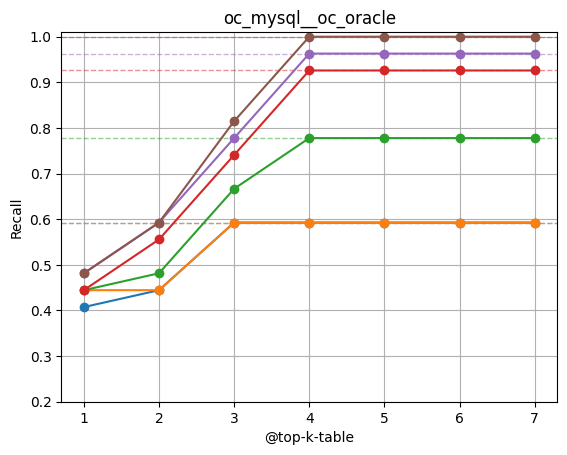

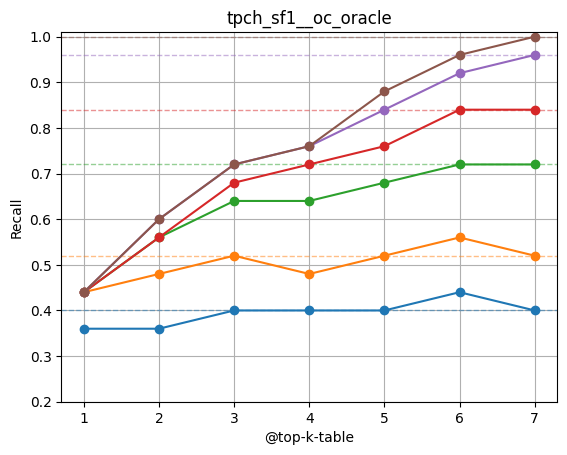

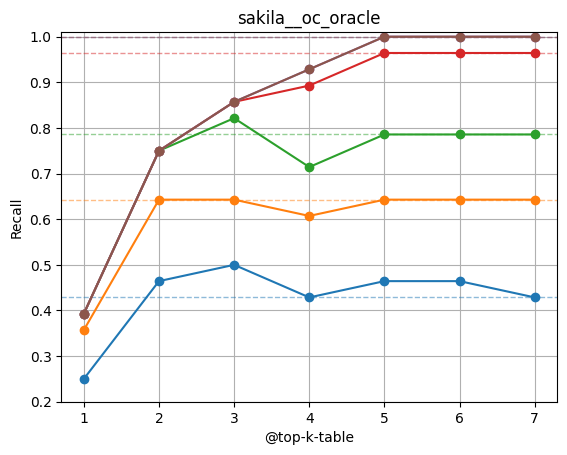

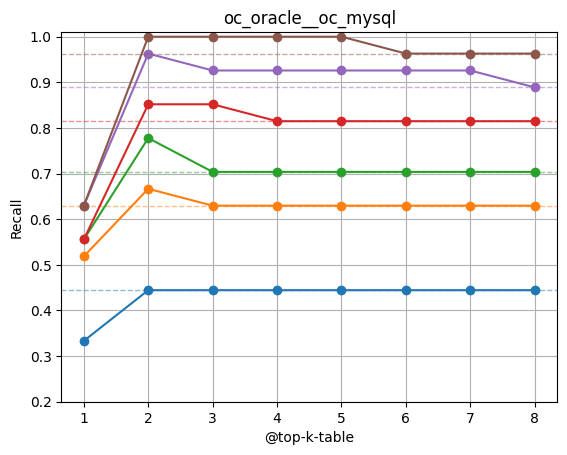

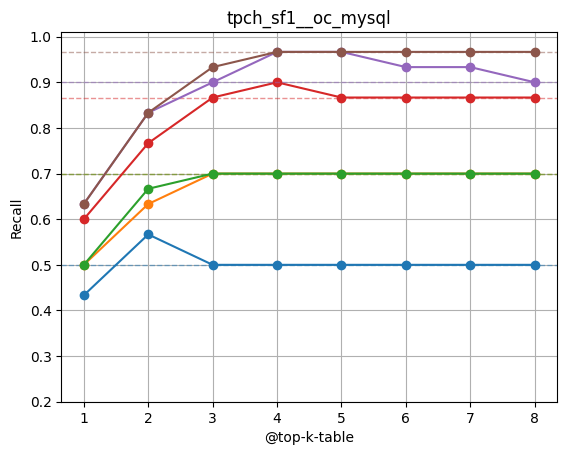

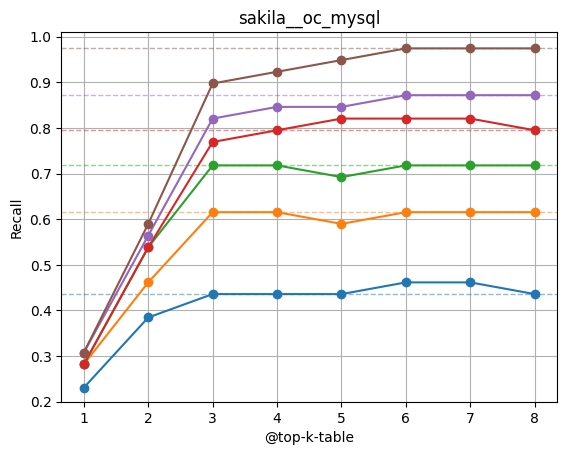

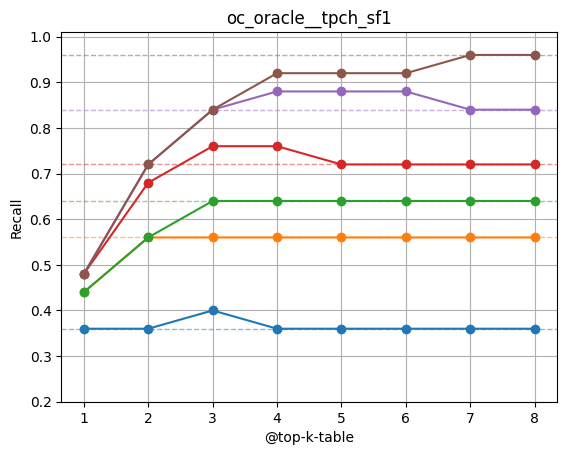

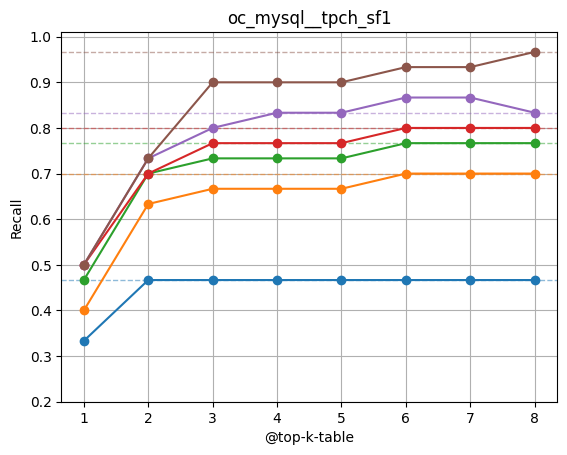

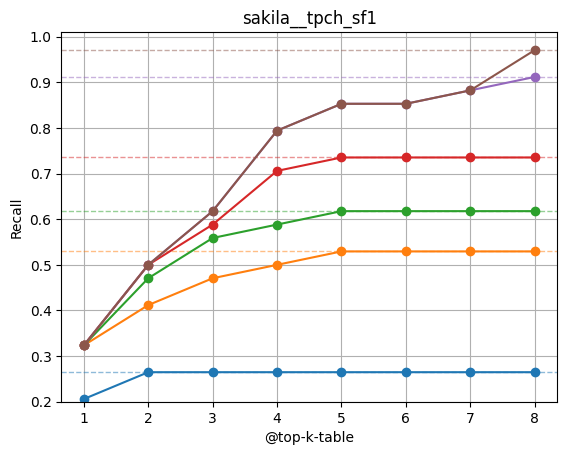

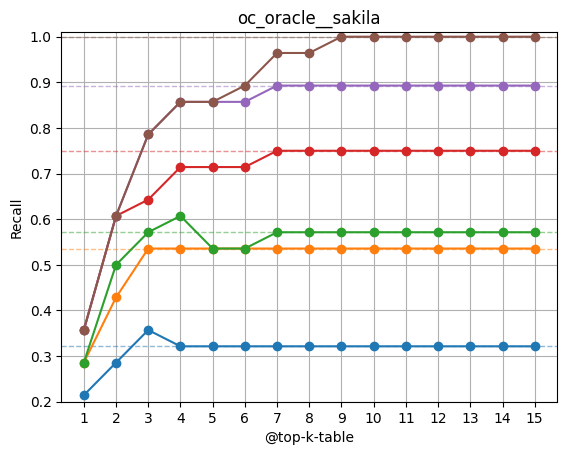

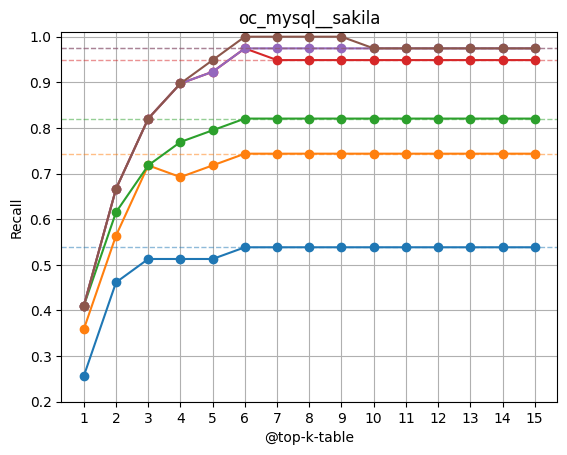

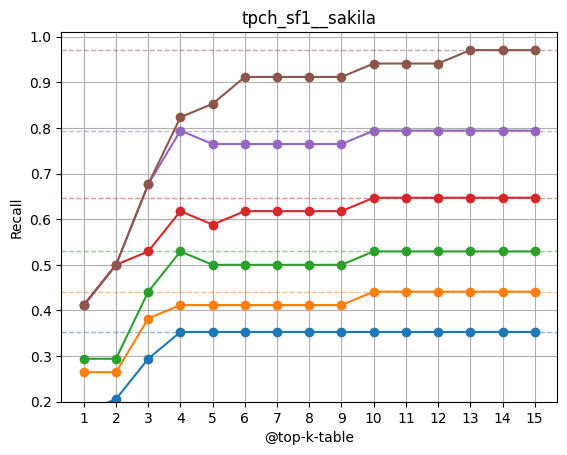

In [134]:
for i in np.arange(len(list_entities_a)):
    df_tmp = evaluate_summary(list_entities_a[i], list_entities_b[i], table_predicts[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    plot_performance_by_table_k(df_tmp, top_ks, title=gt_keys[i], legend=False)


In [ ]:
for i in np.arange(len(list_entities_a)):
    df_tmp = evaluate_summary(list_entities_a[i], list_entities_b[i], table_predicts[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    plot_performance_by_table_k(df_tmp, top_ks, title=gt_keys[i], legend=False, metric='map')

In [2609]:
# plot_performance_by_table_k(df_tmp, top_ks, title="", legend=True, metric='map')

## b.2) Pair-Wise Transfer-Learning

In [250]:
def semantic_column_table_mtl(in_channels=768, hidden_units=512, out_table_pred=8, dropout_rate=0.2, l2_reg=0.001):
    column_embeddings = Input(shape=(in_channels,), name='column_embeddings')

    hidden = tf.keras.layers.Dense(hidden_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg), name="hidden_1")(column_embeddings)
    if dropout_rate:
        hidden = tf.keras.layers.Dropout(dropout_rate)(hidden)
    
    hidden = tf.keras.layers.Dense(int(hidden_units/2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg), name="hidden_2")(hidden)
    if dropout_rate:
        hidden = tf.keras.layers.Dropout(dropout_rate)(hidden)
    
    pred_table = tf.keras.layers.Dense(out_table_pred, activation='sigmoid', name="pred_table")(hidden) 

    model = Model(inputs=column_embeddings, outputs=pred_table)

    return model

In [251]:
def semantic_column_table_attention(in_channels=5376, hidden_units=256, out_table_pred=8, dropout_rate=0.5, l2_reg=0.001):
    
    # 1. Input Layer: (Batch, 5376)
    column_embeddings_flat = Input(shape=(in_channels,), name='column_embeddings_flat')

    # 2. Reshape to Sequence: (Batch, 7, 768)
    column_embeddings_seq = Reshape((int(in_channels/768), 768), name='reshape_sequence')(column_embeddings_flat)
    
    # 3. Create Query/Apply Self-Attention
    query = Dense(768, name='attention_query')(column_embeddings_seq)
    
    # The Attention layer now outputs a list: [attention_output, attention_scores]
    attention_output_list = tf.keras.layers.Attention(use_scale=True, name='attention_layer')(
        [query, column_embeddings_seq],
        return_attention_scores=True
    )
    
    # Unpack the list outputs
    attention_output_seq = attention_output_list[0]
    attention_scores = attention_output_list[1] # This is the tensor (Batch, 7, 7)
    
    # Aggregate context vector for prediction path
    hidden = GlobalAveragePooling1D(name='global_average_pooling')(attention_output_seq) 
    
    if dropout_rate:
        hidden = Dropout(dropout_rate, name='dropout_context')(hidden)

    # 4. Classification Head (Prediction Model Path)
    hidden = Dense(hidden_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg), name="hidden_1")(hidden)
    
    pred_table = Dense(out_table_pred, activation='sigmoid', name="pred_table")(hidden) 

    pred_model = Model(inputs=column_embeddings_flat, outputs=pred_table, name='Prediction_Model')
    
    scorer_model = Model(inputs=column_embeddings_flat, outputs=attention_scores, name='Scorer_Model')

    return pred_model, scorer_model

In [252]:
def combine_mtl_data(Xa, Ya, Xb, Yb):
    """Combines features (X) and labels (Y) for Multi-Task Learning with Schema ID."""
    
    num_tables_a = Ya.shape[1]
    num_tables_b = Yb.shape[1]
    
    # --- 1. Prepare Features (X) ---
    X_mtl = np.concatenate([Xa, Xb], axis=0)
    
    # --- 2. Prepare Labels (Y) with Masking ---
    
    # Create padding matrices
    padding_a = np.zeros((Ya.shape[0], num_tables_b), dtype=Ya.dtype) # Pad Y_A with zeros for Y_B's tables
    padding_b = np.zeros((Yb.shape[0], num_tables_a), dtype=Yb.dtype) # Pad Y_B with zeros for Y_A's tables

    # Concatenate Y_A: [Y_A | 0_B]
    Y_mtl_a = np.concatenate([Ya, padding_a], axis=1)
    
    # Concatenate Y_B: [0_A | Y_B]
    Y_mtl_b = np.concatenate([padding_b, Yb], axis=1)
    
    # Final combined labels (Y)
    Y_mtl = np.concatenate([Y_mtl_a, Y_mtl_b], axis=0)
    
    return X_mtl, Y_mtl, num_tables_a, num_tables_b

In [253]:
def masked_focal_loss_mtl(gamma=2.0, alpha=0.9, N_A=None):
    """Focal Loss adapted for Multi-Task Learning with zeroed-out labels."""
    if N_A is None:
        raise ValueError("N_A (number of tables in Schema A) must be provided for masking.")
        
    alpha_tensor = tf.constant(alpha, dtype=tf.float32)

    def masked_focal_loss_fn(y_true, y_pred):
        # The total loss is calculated only where y_true is NOT zero.
        # This relies on the property: y_true * log(y_pred) is zero if y_true is zero.
        
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # 1. Calculate Standard BCE Terms
        # The loss for the masked segment (e.g., Schema B part for a Schema A column) 
        # is inherently zero because Y_true is zero in that segment.
        bce = y_true * tf.math.log(y_pred)
        bce += (1 - y_true) * tf.math.log(1 - y_pred)
        
        # 2. Calculate Focal Loss terms
        pt = tf.exp(bce)
        focal_loss_raw = -alpha_tensor * (1. - pt)**gamma * bce
        
        # 3. Apply the final mask: Only consider the loss where y_true > 0
        # A simple weight map where 1 is applied to the segment with known labels
        # and 0 is applied to the masked segment.
        
        # Create a mask that is 1 for the first N_A columns, 0 for the rest
        mask_A = tf.concat([tf.ones([N_A], dtype=tf.float32), 
                            tf.zeros([tf.shape(y_true)[1] - N_A], dtype=tf.float32)], axis=0)
        
        # Create a mask that is 0 for the first N_A columns, 1 for the rest
        mask_B = tf.concat([tf.zeros([N_A], dtype=tf.float32), 
                            tf.ones([tf.shape(y_true)[1] - N_A], dtype=tf.float32)], axis=0)
        
        # Determine if each sample in the batch is from Schema A or Schema B
        # This is based on where the labels are non-zero.
        is_from_A = tf.reduce_any(y_true[:, :N_A] > 0, axis=1, keepdims=True)
        is_from_B = tf.logical_not(is_from_A)

        # Apply the correct mask to the raw focal loss for each sample in the batch
        mask_per_sample = tf.where(is_from_A, mask_A, mask_B)
        
        # Scale the loss by the mask: loss is zeroed out for the inter-schema segment
        total_focal_loss = focal_loss_raw * mask_per_sample

        # Sum the loss for each sample across all tables (j dimension)
        loss_per_sample = tf.reduce_sum(total_focal_loss, axis=-1)

        # Return the mean loss across the batch (i dimension)
        # Keras automatically handles the batch dimension for the final reduction, 
        # but explicitly using tf.reduce_mean here is safer for custom functions.
        return tf.reduce_mean(loss_per_sample) 

    return masked_focal_loss_fn

In [254]:
def train_semantic_column_mtl(entities_a, entities_b, alpha=0.9, epochs=100, batch_size=16, dropout_rate=0.2, hidden_units=512, l2_reg=0.001, learning_rate=0.001, attention=False, serialization=vserialization):

    
    # 1. Combine Data and Get Metrics
    Xa = get_entity_signatures(entities_a, "text_sequence")
    Ya = get_entity_signatures(entities_a, "parent_onehot")
    
    print("================================")
    print("Schema A")
    num_columns_a = len(Xa)
    print("#Columns: " + str(num_columns_a))
    embedding_size_a = len(Xa[0])
    print("#Embedding: " + str(embedding_size_a))
    num_tables_a = len(Ya[0])
    print("#Tables/Classes: " + str(num_tables_a))
    print("Column to Table Class Count:")
    print(sorted(list(set([entity.parent_id for entity in entities_a if entity.hops == 0]))))
    print(np.ndarray.sum(Ya, axis=0))


    Xb = get_entity_signatures(entities_b, "text_sequence")
    Yb = get_entity_signatures(entities_b, "parent_onehot")

    print("================================")
    print("Schema B")
    num_columns_b = len(Xb)
    print("#Columns: " + str(num_columns_b))
    embedding_size_b = len(Xb[0])
    print("#Embedding: " + str(embedding_size_b))
    num_tables_b = len(Yb[0])
    print("#Tables/Classes: " + str(num_tables_b))
    print("Column to Table Class Count:")
    print(sorted(list(set([entity.parent_id for entity in entities_b if entity.hops == 0]))))
    print(np.ndarray.sum(Yb, axis=0))


    X_mtl, Y_mtl, num_tables_a, num_tables_b = combine_mtl_data(Xa, Ya, Xb, Yb)
    
    print("================================")
    print("Combined")
    num_columns_mtl = len(X_mtl)
    print("#Columns: " + str(num_columns_mtl))
    total_tables = num_tables_a + num_tables_b
    print("#Tables/Classes: " + str(total_tables))
    print("Column to Table Class Count:")
    print(sorted(list(set([entity.parent_id for entity in entities_a if entity.hops == 0]))))
    print(sorted(list(set([entity.parent_id for entity in entities_b if entity.hops == 0]))))
    print(np.ndarray.sum(Y_mtl, axis=0))
    
    embedding_size = X_mtl.shape[1]


    # 2. Stratified Split (Split the combined data using the Y_mtl labels)
    # Use a standard 80/20 split.
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_mtl, Y_mtl, test_size=0.2, random_state=42, 
        stratify=[''.join(str(int(i)) for i in row) for row in Y_mtl]
    )

    # 3. Instantiate and Compile Model (Use the adjusted parameters)
    if attention:
        model, scorer = semantic_column_table_attention(
            in_channels=embedding_size, 
            out_table_pred=total_tables, 
            hidden_units=hidden_units, 
            dropout_rate=dropout_rate,
            l2_reg=l2_reg)
    else:
        model = semantic_column_table_mtl(
            in_channels=embedding_size, 
            out_table_pred=total_tables, 
            hidden_units=hidden_units, 
            dropout_rate=dropout_rate,
            l2_reg=l2_reg)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=masked_focal_loss_mtl(gamma=2.0, alpha=alpha, N_A=num_tables_a),
        metrics=['precision', 'recall']
    )

    # 4. Train Model
    history = model.fit(
        X_train, Y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=1,
        validation_data=(X_val, Y_val)
    )
    
    print(f"\nTraining Complete. Total Tables: {total_tables}. Model size: {model.count_params()} parameters.")

    if attention:
        print("\n Mean Attention Weights")
        raw_scores = scorer.predict(X_val)
        mean_scores_per_sample = np.mean(raw_scores, axis=1)
        mean_attention_weights = np.mean(mean_scores_per_sample, axis=0)
        feature_labels_weights_dict = dict(zip(serialization, ['%.2f' % mod_weight for mod_weight in mean_attention_weights]))
        print(feature_labels_weights_dict)
        if len(mean_attention_weights) == len(serialization):
            plt.figure(figsize=(10, 2))
            sns.heatmap(
                mean_attention_weights.reshape(1, -1), # Reshape for horizontal plot
                annot=True,
                fmt=".3f",
                cmap="viridis",
                yticklabels=['Mean Weight'],
                xticklabels=serialization,
                cbar=False
            )
            plt.title('Mean Attention Weights Across Semantic Modalities (Validation Set)')
            plt.show()
        
    return model


In [255]:
def train_semantic_column_mtl_kfold(entities_a, entities_b, alpha=0.9, epochs=100, batch_size=16, n_splits=5, dropout_rate=0.2, hidden_units=512, l2_reg=0.001, learning_rate=0.001, random_state=42, attention=False):
    # 1. Combine Data and Get Metrics
    Xa = get_entity_signatures(entities_a, "text_sequence")
    Ya = get_entity_signatures(entities_a, "parent_onehot")
    Xb = get_entity_signatures(entities_b, "text_sequence")
    Yb = get_entity_signatures(entities_b, "parent_onehot")
    
    # Combined Data
    X_mtl, Y_mtl, num_tables_a, num_tables_b = combine_mtl_data(Xa, Ya, Xb, Yb)
    
    # Printing Information (kept from your original code)
    print("================================")
    print("Schema A")
    print(f"#Columns: {len(Xa)}")
    print(f"#Embedding: {len(Xa[0])}")
    print(f"#Tables/Classes: {num_tables_a}")
    print("================================")
    print("Schema B")
    print(f"#Columns: {len(Xb)}")
    print(f"#Embedding: {len(Xb[0])}")
    print(f"#Tables/Classes: {num_tables_b}")
    print("================================")
    print("Combined")
    num_columns_mtl = len(X_mtl)
    print(f"#Columns: {num_columns_mtl}")
    total_tables = num_tables_a + num_tables_b
    print(f"#Tables/Classes: {total_tables}")
    # print(np.ndarray.sum(Y_mtl, axis=0)) # Kept for debugging/info
    
    embedding_size = X_mtl.shape[1]
    
    # Dictionary to store the trained models
    ensemble_models = {} 
    
    # Proxy for stratification: Create a unique string representation of the multi-label vector
    # This is essential for StratifiedKFold in a multi-label setting.
    y_stratify_proxy = [''.join(str(int(i)) for i in row) for row in Y_mtl]

    # Initialize Stratified K-Fold
    # Using the StratifiedKFold method from your single-schema code
    if random_state:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    for fold, (train_index, val_index) in enumerate(skf.split(X_mtl, y_stratify_proxy)):
        print(f"\n--- Training Fold {fold+1}/{n_splits} ---")

        # Split combined data
        X_train, X_val = X_mtl[train_index], X_mtl[val_index]
        Y_train, Y_val = Y_mtl[train_index], Y_mtl[val_index]

        # 2. Instantiate and Compile Model (Fresh model for each fold)
        # Assuming the model function is accessible:
        if attention:
            model = semantic_column_table_attention(
            in_channels=embedding_size, 
            out_table_pred=total_tables, 
            hidden_units=hidden_units, 
            dropout_rate=dropout_rate,
            l2_reg=l2_reg)
        else:
            model = semantic_column_table_mtl(
            in_channels=embedding_size, 
            out_table_pred=total_tables, 
            hidden_units=hidden_units, 
            dropout_rate=dropout_rate,
            l2_reg=l2_reg)
        
        # Compile with the custom MTL loss
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=masked_focal_loss_mtl(gamma=2.0, alpha=alpha, N_A=num_tables_a), # N_A is crucial
            metrics=['precision', 'recall']
        )

        # 3. Train Model
        history = model.fit(
            X_train, Y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=0,
            validation_data=(X_val, Y_val),
            shuffle=True
        )
        
        # 4. Store Model (as requested by your previous logic)
        ensemble_models[f'model_{fold+1}'] = model
        
        # Optionally, print final validation metrics for the fold
        val_loss, val_precision, val_recall = model.evaluate(X_val, Y_val, verbose=0)
        print(f"Fold {fold+1} Validation Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
    
    print(f"\nTraining Complete. Total Tables: {total_tables}. Trained {n_splits} models.")
    return ensemble_models

In [256]:
def column_table_predictions_mtl_ensemble(entities_source, schema_target_name, df_graph, ensemble_models, source_schema_id='a', prob_column_verbose="id", meta=False):
    
    # Get the column headers (table names for the target schema)
    prob_cols = df_graph[(df_graph.schema == schema_target_name) & 
                         (df_graph.type == "table")][prob_column_verbose].values
    
    Xa = get_entity_signatures(entities_source, "text_sequence")
    Ya = get_entity_signatures(entities_source, "parent_onehot")
    num_tables_source = len(Ya[0]) # This is N_A if source_schema_id='a', and N_B if 'b'

    # --- 1. Select Source Entities and Slicing Indices ---
    if source_schema_id == 'a':
        slice_start = num_tables_source
        slice_end = num_tables_source + len(prob_cols)
        
    elif source_schema_id == 'b':
        slice_start = 0
        slice_end = len(prob_cols)
            
    # --- 2. Prepare Input Features (X) and Predict (Ensemble) --- 
    
    # Initialize a tensor to accumulate predictions
    all_predictions_target = []

    for model_name, model in ensemble_models.items():
        # Predict using the single model
        predictions_mtl = model.predict(Xa, verbose=0)
        
        # Slice accordingly for the target schema
        predictions_target_single = predictions_mtl[:, slice_start:slice_end]
        all_predictions_target.append(predictions_target_single)

    # Average the predictions across all models
    if all_predictions_target:
        # Stack the predictions and compute the mean across the model axis (axis=0)
        predictions_target = np.mean(np.stack(all_predictions_target, axis=0), axis=0)
    else:
        # Handle case where ensemble is empty
        return pd.DataFrame() 
    
    # --- 3. Create Output DataFrame --- 
    table_predict_schema = pd.DataFrame(
        data=predictions_target,
        columns=prob_cols
    )
        
    table_predict_schema.insert(loc=0, column='id_a', value=get_entity_signatures(entities_source, "entity_id"))

    # --- 3. Add Metadata and Top-K Ranking ---
    if meta:

        table_predict_schema.insert(loc=1, column='name_a', value=get_entity_signatures(entities_source, "name"))
        table_predict_schema.insert(loc=2, column='parent_id_a', value=get_entity_signatures(entities_source, "parent_id"))
        table_predict_schema.insert(loc=3, column='parent_name_a', value=[get_entity_name_by_id(parent_id, df_graph) for parent_id in get_entity_signatures(entities_source, "parent_id")])
        table_predict_schema.insert(loc=4, column='schema_a', value=get_entity_signatures(entities_source, "schema"))
        
        # Ranking (Your existing logic adapted)
        table_predict_schema['ranked_tables'] = table_predict_schema[prob_cols].apply(
            lambda row: get_top_k_ranks(row, k=len(prob_cols), prob_cols=prob_cols), axis=1
        )
        
        for i in np.arange(len(prob_cols)):
            table_predict_schema[f'top_{i+1}'] = table_predict_schema['ranked_tables'].str[i]
        
        table_predict_schema = table_predict_schema.drop(columns=['ranked_tables'])

    return table_predict_schema

#### OC-ORACLE <-> MYSQL

In [362]:
cross_ensemble_ocoracle_ocmysql_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser, entities_ocmysql_augmented_hop1_ser)

Schema A
#Columns: 156
#Embedding: 768
#Tables/Classes: 7
Schema B
#Columns: 173
#Embedding: 768
#Tables/Classes: 8
Combined
#Columns: 329
#Tables/Classes: 15

--- Training Fold 1/5 ---
Fold 1 Validation Loss: 0.4458, Precision: 0.4487, Recall: 0.6250

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.4340, Precision: 0.4570, Recall: 0.6509

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.4622, Precision: 0.4194, Recall: 0.5702

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.4459, Precision: 0.4408, Recall: 0.6091

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.4387, Precision: 0.4710, Recall: 0.6404

Training Complete. Total Tables: 15. Trained 5 models.


In [ ]:
#single model
cross_model_ocoracle_ocmysql = train_semantic_column_mtl(entities_ocoracle_augmented_hop1_ser, entities_ocmysql_augmented_hop1_ser)

In [574]:
tmp_results = []

matching_keys = ['oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'sakila__oc_oracle', 
                 'oc_oracle__oc_mysql', 'tpch_sf1__oc_mysql', 'sakila__oc_mysql', 
                 'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'sakila__tpch_sf1',
                 'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila']

tmp_table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, {"a":cross_model_ocoracle_ocmysql}, source_schema_id="b", prob_column_verbose="id", meta=True)
tmp_table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, {"a":cross_model_ocoracle_ocmysql}, source_schema_id="a", prob_column_verbose="id", meta=True)

df_tmp = column_table_matches(tmp_table_predict_ocoracle_ocmysql_cross_b, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
tmp_results.append([matching_keys[0], "recall"] + recall_plot)

df_tmp = column_table_matches(tmp_table_predict_ocoracle_ocmysql_cross_a, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
tmp_results.append([matching_keys[3], "recall"] + recall_plot)

tmp_df_table_cross_prediction_results = pd.DataFrame(data=tmp_results, columns=["schemas_column_table_pred", "metric", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8"])
tmp_df_table_cross_prediction_results

schemas_column_table_pred  metric  top_1  top_2  top_3  top_4  top_5  top_6  \
0       oc_mysql__oc_oracle  recall  0.481  0.593  0.815  1.000  1.000  1.000   
1       oc_oracle__oc_mysql  recall  0.714  1.000  1.000  1.000  1.000  1.000   

   top_7  top_8  
0  1.000    NaN  
1  1.000  1.000

In [540]:
column_table_predictions_mtl_ensemble(get_raw_entities(entities_ocmysql_augmented_hop1_ser), "OC_ORACLE", df_OC3HR, {"a":cross_model_ocoracle_ocmysql}, source_schema_id="b", prob_column_verbose="name", meta=True)

id_a                  name_a parent_id_a parent_name_a  schema_a  \
0    entity_96          CUSTOMERNUMBER   entity_95     CUSTOMERS  OC_MYSQL   
1    entity_97            CUSTOMERNAME   entity_95     CUSTOMERS  OC_MYSQL   
2    entity_98         CONTACTLASTNAME   entity_95     CUSTOMERS  OC_MYSQL   
3    entity_99        CONTACTFIRSTNAME   entity_95     CUSTOMERS  OC_MYSQL   
4   entity_100                   PHONE   entity_95     CUSTOMERS  OC_MYSQL   
5   entity_101            ADDRESSLINE1   entity_95     CUSTOMERS  OC_MYSQL   
6   entity_102            ADDRESSLINE2   entity_95     CUSTOMERS  OC_MYSQL   
7   entity_103                    CITY   entity_95     CUSTOMERS  OC_MYSQL   
8   entity_104                   STATE   entity_95     CUSTOMERS  OC_MYSQL   
9   entity_105              POSTALCODE   entity_95     CUSTOMERS  OC_MYSQL   
10  entity_106                 COUNTRY   entity_95     CUSTOMERS  OC_MYSQL   
11  entity_107  SALESREPEMPLOYEENUMBER   entity_95     CUSTOMERS  OC_MYSQL   
12  entity_108             CREDITLIMIT   entity_95     CUSTOMERS  OC_MYSQL   
13  entity_110          EMPLOYEENUMBER  entity_109     EMPLOYEES  OC_MYSQL   
14  entity_111                LASTNAME  entity_109     EMPLOYEES  OC_MYSQL   
15  entity_112               FIRSTNAME  entity_109     EMPLOYEES  OC_MYSQL   
16  entity_113               EXTENSION  entity_109     EMPLOYEES  OC_MYSQL   
17  entity_114                   EMAIL  entity_109     EMPLOYEES  OC_MYSQL   
18  entity_115              OFFICECODE  entity_109     EMPLOYEES  OC_MYSQL   
19  entity_116               REPORTSTO  entity_109     EMPLOYEES  OC_MYSQL   
20  entity_117                JOBTITLE  entity_109     EMPLOYEES  OC_MYSQL   
21  entity_119              OFFICECODE  entity_118       OFFICES  OC_MYSQL   
22  entity_120                    CITY  entity_118       OFFICES  OC_MYSQL   
23  entity_121                   PHONE  entity_118       OFFICES  OC_MYSQL   
24  entity_122            ADDRESSLINE1  entity_118       OFFICES  OC_MYSQL   
25  entity_123            ADDRESSLINE2  entity_118       OFFICES  OC_MYSQL   
26  entity_124                   STATE  entity_118       OFFICES  OC_MYSQL   
27  entity_125                 COUNTRY  entity_118       OFFICES  OC_MYSQL   
28  entity_126              POSTALCODE  entity_118       OFFICES  OC_MYSQL   
29  entity_127               TERRITORY  entity_118       OFFICES  OC_MYSQL   
30  entity_129             ORDERNUMBER  entity_128  ORDERDETAILS  OC_MYSQL   
31  entity_130             PRODUCTCODE  entity_128  ORDERDETAILS  OC_MYSQL   
32  entity_131         QUANTITYORDERED  entity_128  ORDERDETAILS  OC_MYSQL   
33  entity_132               PRICEEACH  entity_128  ORDERDETAILS  OC_MYSQL   
34  entity_133         ORDERLINENUMBER  entity_128  ORDERDETAILS  OC_MYSQL   
35  entity_135             ORDERNUMBER  entity_134        ORDERS  OC_MYSQL   
36  entity_136               ORDERDATE  entity_134        ORDERS  OC_MYSQL   
37  entity_137            REQUIREDDATE  entity_134        ORDERS  OC_MYSQL   
38  entity_138             SHIPPEDDATE  entity_134        ORDERS  OC_MYSQL   
39  entity_139                  STATUS  entity_134        ORDERS  OC_MYSQL   
40  entity_140                COMMENTS  entity_134        ORDERS  OC_MYSQL   
41  entity_141          CUSTOMERNUMBER  entity_134        ORDERS  OC_MYSQL   
42  entity_143          CUSTOMERNUMBER  entity_142      PAYMENTS  OC_MYSQL   
43  entity_144             CHECKNUMBER  entity_142      PAYMENTS  OC_MYSQL   
44  entity_145             PAYMENTDATE  entity_142      PAYMENTS  OC_MYSQL   
45  entity_146                  AMOUNT  entity_142      PAYMENTS  OC_MYSQL   
46  entity_148             PRODUCTLINE  entity_147  PRODUCTLINES  OC_MYSQL   
47  entity_149         TEXTDESCRIPTION  entity_147  PRODUCTLINES  OC_MYSQL   
48  entity_150         HTMLDESCRIPTION  entity_147  PRODUCTLINES  OC_MYSQL   
49  entity_151                   IMAGE  entity_147  PRODUCTLINES  OC_MYSQL   
50  entity_153             PRODU

In [689]:
# column_table_predictions_mtl_ensemble(entities_ocoracle, "OC_MYSQL", df_OC3HR, {"a":cross_model_ocoracle_ocmysql}, source_schema_id="a", prob_column_verbose="name", meta=True)

In [691]:
# cross_ensemble_ocoracle_ocmysql = train_semantic_column_mtl_kfold(entities_ocoracle_augmented, entities_ocmysql_augmented)

#### OC_ORACLE <-> TPCH

In [347]:
cross_ensemble_ocoracle_tpch_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser, entities_tpch_augmented_hop1_ser)

Schema A
#Columns: 156
#Embedding: 768
#Tables/Classes: 7
Schema B
#Columns: 180
#Embedding: 768
#Tables/Classes: 8
Combined
#Columns: 336
#Tables/Classes: 15

--- Training Fold 1/5 ---
Fold 1 Validation Loss: 0.5618, Precision: 0.5200, Recall: 0.6610

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.5324, Precision: 0.5347, Recall: 0.6754

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.5432, Precision: 0.5504, Recall: 0.6283

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.5357, Precision: 0.5000, Recall: 0.6283

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.5391, Precision: 0.5267, Recall: 0.7182

Training Complete. Total Tables: 15. Trained 5 models.


#### OC_ORACLE <-> SAKILA

In [348]:
cross_ensemble_ocoracle_sakila_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser, entities_sakila_augmented_hop1_ser)

Schema A
#Columns: 156
#Embedding: 768
#Tables/Classes: 7
Schema B
#Columns: 312
#Embedding: 768
#Tables/Classes: 15
Combined
#Columns: 468
#Tables/Classes: 22

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.6400, Precision: 0.4773, Recall: 0.5122

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.6379, Precision: 0.4568, Recall: 0.4568

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.6499, Precision: 0.4412, Recall: 0.4545

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.6452, Precision: 0.4624, Recall: 0.4598

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.6313, Precision: 0.4785, Recall: 0.4937

Training Complete. Total Tables: 22. Trained 5 models.


#### OC_MYSQL <-> TPCH

In [349]:
cross_ensemble_ocmysql_tpch_hop1 = train_semantic_column_mtl_kfold(entities_ocmysql_augmented_hop1_ser, entities_tpch_augmented_hop1_ser)

Schema A
#Columns: 173
#Embedding: 768
#Tables/Classes: 8
Schema B
#Columns: 180
#Embedding: 768
#Tables/Classes: 8
Combined
#Columns: 353
#Tables/Classes: 16

--- Training Fold 1/5 ---
Fold 1 Validation Loss: 0.5396, Precision: 0.4875, Recall: 0.6393

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.5136, Precision: 0.5060, Recall: 0.7798

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.5329, Precision: 0.5030, Recall: 0.6885

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.5221, Precision: 0.5430, Recall: 0.6833

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.5057, Precision: 0.4971, Recall: 0.7699

Training Complete. Total Tables: 16. Trained 5 models.


In [350]:
# column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1, source_schema_id="a", prob_column_verbose="name", meta=True)

#### OC_MYSQL <-> Sakila

In [351]:
cross_ensemble_ocmysql_sakila_hop1 = train_semantic_column_mtl_kfold(entities_ocmysql_augmented_hop1_ser, entities_sakila_augmented_hop1_ser)

Schema A
#Columns: 173
#Embedding: 768
#Tables/Classes: 8
Schema B
#Columns: 312
#Embedding: 768
#Tables/Classes: 15
Combined
#Columns: 485
#Tables/Classes: 23

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.6093, Precision: 0.5000, Recall: 0.5212

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.6236, Precision: 0.5326, Recall: 0.5939

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.6381, Precision: 0.4860, Recall: 0.5088

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.6296, Precision: 0.5491, Recall: 0.5491

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.6155, Precision: 0.5241, Recall: 0.5210

Training Complete. Total Tables: 23. Trained 5 models.


#### TPCH <-> Sakila

In [352]:
cross_ensemble_tpch_sakila_hop1 = train_semantic_column_mtl_kfold(entities_tpch_augmented_hop1_ser, entities_sakila_augmented_hop1_ser)

Schema A
#Columns: 180
#Embedding: 768
#Tables/Classes: 8
Schema B
#Columns: 312
#Embedding: 768
#Tables/Classes: 15
Combined
#Columns: 492
#Tables/Classes: 23

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.6051, Precision: 0.5506, Recall: 0.5765

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.6264, Precision: 0.5714, Recall: 0.4941

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.6245, Precision: 0.6718, Recall: 0.4972

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.6158, Precision: 0.5625, Recall: 0.6000

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.5988, Precision: 0.5449, Recall: 0.5673

Training Complete. Total Tables: 23. Trained 5 models.


### Non-Augmented

In [278]:
cross_ensemble_ocoracle_ocmysql = train_semantic_column_mtl_kfold(entities_ocoracle_ser, entities_ocmysql_ser)
cross_ensemble_ocoracle_tpch = train_semantic_column_mtl_kfold(entities_ocoracle_ser, entities_tpch_ser)
cross_ensemble_ocoracle_sakila = train_semantic_column_mtl_kfold(entities_ocoracle_ser, entities_sakila_ser)
cross_ensemble_ocmysql_tpch = train_semantic_column_mtl_kfold(entities_ocmysql_ser, entities_tpch_ser)
cross_ensemble_ocmysql_sakila = train_semantic_column_mtl_kfold(entities_ocmysql_ser, entities_sakila_ser)
cross_ensemble_tpch_sakila = train_semantic_column_mtl_kfold(entities_tpch_ser, entities_sakila_ser)

Schema A
#Columns: 43
#Embedding: 768
#Tables/Classes: 7
Schema B
#Columns: 59
#Embedding: 768
#Tables/Classes: 8
Combined
#Columns: 102
#Tables/Classes: 15

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3951, Precision: 0.3571, Recall: 0.7143

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3690, Precision: 0.4828, Recall: 0.6667

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.2933, Precision: 0.4872, Recall: 0.9500

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3473, Precision: 0.4324, Recall: 0.8000

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3069, Precision: 0.4516, Recall: 0.7000

Training Complete. Total Tables: 15. Trained 5 models.
Schema A
#Columns: 43
#Embedding: 768
#Tables/Classes: 7
Schema B
#Columns: 61
#Embedding: 768
#Tables/Classes: 8
Combined
#Columns: 104
#Tables/Classes: 15

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.2350, Precision: 0.5122, Recall: 1.0000

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3578, Precision: 0.5152, Recall: 0.8095

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.2808, Precision: 0.5625, Recall: 0.8571

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.2563, Precision: 0.4872, Recall: 0.9048

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.2164, Precision: 0.6071, Recall: 0.8500

Training Complete. Total Tables: 15. Trained 5 models.
Schema A
#Columns: 43
#Embedding: 768
#Tables/Classes: 7
Schema B
#Columns: 70
#Embedding: 768
#Tables/Classes: 15
Combined
#Columns: 113
#Tables/Classes: 22

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.4476, Precision: 0.3636, Recall: 0.5217

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3426, Precision: 0.4474, Recall: 0.7391

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3831, Precision: 0.5000, Recall: 0.6522

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.4236, Precision: 0.4688, Recall: 0.6818

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3659, Precision: 0.4839, Recall: 0.6818

Training Complete. Total Tables: 22. Trained 5 models.
Schema A
#Columns: 59
#Embedding: 768
#Tables/Classes: 8
Schema B
#Columns: 61
#Embedding: 768
#Tables/Classes: 8
Combined
#Columns: 120
#Tables/Classes: 16

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.2444, Precision: 0.5610, Recall: 0.9583

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3121, Precision: 0.5556, Recall: 0.8333

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.2430, Precision: 0.4783, Recall: 0.9167

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.2814, Precision: 0.5714, Recall: 0.8333

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3191, Precision: 0.5667, Recall: 0.7083

Training Complete. Total Tables: 16. Trained 5 models.
Schema A
#Columns: 59
#Embedding: 768
#Tables/Classes: 8
Schema B
#Columns: 70
#Embedding: 768
#Tables/Classes: 15
Combined
#Columns: 129
#Tables/Classes: 23

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3812, Precision: 0.5455, Recall: 0.6923

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3581, Precision: 0.5526, Recall: 0.8077

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.4316, Precision: 0.5625, Recall: 0.6923

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.4059, Precision: 0.4857, Recall: 0.6538

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.5257, Precision: 0.4286, Recall: 0.6000

Training Complete. Total Tables: 23. Trained 5 models.
Schema A
#Columns: 61
#Embedding: 768
#Tables/Classes: 8
Schema B
#Columns: 70
#Embedding: 768
#Tables/Classes: 15
Combined
#Columns: 131
#Tables/Classes: 23

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3596, Precision: 0.5143, Recall: 0.6667

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.4351, Precision: 0.4545, Recall: 0.5769

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3853, Precision: 0.5000, Recall: 0.6923

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3621, Precision: 0.5312, Recall: 0.6538

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3995, Precision: 0.5882, Recall: 0.7692

Training Complete. Total Tables: 23. Trained 5 models.


### exCHP

In [ ]:
# cross_ensemble_ocoracle_ocmysql_hop1_exCHP = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser_exCHP, entities_ocmysql_augmented_hop1_ser_exCHP)
# cross_ensemble_ocoracle_tpch_hop1_exCHP = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser_exCHP, entities_tpch_augmented_hop1_ser_exCHP)
# cross_ensemble_ocoracle_sakila_hop1_exCHP = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser_exCHP, entities_sakila_augmented_hop1_ser_exCHP)
# cross_ensemble_ocmysql_tpch_hop1_exCHP = train_semantic_column_mtl_kfold(entities_ocmysql_augmented_hop1_ser_exCHP, entities_tpch_augmented_hop1_ser_exCHP)
# cross_ensemble_ocmysql_sakila_hop1_exCHP = train_semantic_column_mtl_kfold(entities_ocmysql_augmented_hop1_ser_exCHP, entities_sakila_augmented_hop1_ser_exCHP)
# cross_ensemble_tpch_sakila_hop1_exCHP = train_semantic_column_mtl_kfold(entities_tpch_augmented_hop1_ser_exCHP, entities_sakila_augmented_hop1_ser_exCHP)

Schema A
#Columns: 156
#Embedding: 768
#Tables/Classes: 7
Schema B
#Columns: 312
#Embedding: 768
#Tables/Classes: 15
Combined
#Columns: 468
#Tables/Classes: 22

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3366, Precision: 0.5371, Recall: 0.7500

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3093, Precision: 0.5439, Recall: 0.8025

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3533, Precision: 0.5261, Recall: 0.7333

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3532, Precision: 0.5541, Recall: 0.7356

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3274, Precision: 0.5195, Recall: 0.7595

Training Complete. Total Tables: 22. Trained 5 models.


### Table Prediction Evaluation

In [279]:
vis_pred_columns=["id_a", "name_a", "parent_id_a", "parent_name_a",	"schema_a", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7",  "top_8", "top_9", "top_14", "top_15"]

In [372]:
results = []

table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_ocmysql_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_tpch_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)

table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocoracle_ocmysql_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)

table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_ocoracle_tpch_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_tpch_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)      

table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "SAKILA", df_OC3HR, cross_ensemble_ocoracle_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "SAKILA", df_OC3HR, cross_ensemble_ocmysql_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_tpch_ser, "SAKILA", df_OC3HR, cross_ensemble_tpch_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
  

In [280]:
# default without augmentation
results = []

table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_ocmysql, source_schema_id="b", prob_column_verbose="id", meta=True)
table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_tpch, source_schema_id="b", prob_column_verbose="id", meta=True)
table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_sakila, source_schema_id="b", prob_column_verbose="id", meta=True)

table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocoracle_ocmysql, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_tpch, source_schema_id="b", prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_sakila, source_schema_id="b", prob_column_verbose="id", meta=True)

table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_ocoracle_tpch, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_ocmysql_tpch, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_tpch_sakila, source_schema_id="b", prob_column_verbose="id", meta=True)      

table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "SAKILA", df_OC3HR, cross_ensemble_ocoracle_sakila, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "SAKILA", df_OC3HR, cross_ensemble_ocmysql_sakila, source_schema_id="a", prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_tpch_ser, "SAKILA", df_OC3HR, cross_ensemble_tpch_sakila, source_schema_id="a", prob_column_verbose="id", meta=True)
  

In [ ]:
#_exCHP
# results = []

# table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_ensemble(entities_ocmysql_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_ocmysql_hop1_exCHP, source_schema_id="b", prob_column_verbose="id", meta=True)
# table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_tpch_hop1_exCHP, source_schema_id="b", prob_column_verbose="id", meta=True)
# table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_sakila_hop1_exCHP, source_schema_id="b", prob_column_verbose="id", meta=True)

# table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_ocoracle_ocmysql_hop1_exCHP, source_schema_id="a", prob_column_verbose="id", meta=True)
# table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1_exCHP, source_schema_id="b", prob_column_verbose="id", meta=True)
# table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_sakila_hop1_exCHP, source_schema_id="b", prob_column_verbose="id", meta=True)

# table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_ocoracle_tpch_hop1_exCHP, source_schema_id="a", prob_column_verbose="id", meta=True)
# table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1_exCHP, source_schema_id="a", prob_column_verbose="id", meta=True)
# table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_tpch_sakila_hop1_exCHP, source_schema_id="b", prob_column_verbose="id", meta=True)      

# table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_ocoracle_sakila_hop1_exCHP, source_schema_id="a", prob_column_verbose="id", meta=True)
# table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_ocmysql_sakila_hop1_exCHP, source_schema_id="a", prob_column_verbose="id", meta=True)
# table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_tpch_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_tpch_sakila_hop1_exCHP, source_schema_id="a", prob_column_verbose="id", meta=True)
  

In [281]:
results = []

matching_keys = ['oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'sakila__oc_oracle', 
                 'oc_oracle__oc_mysql', 'tpch_sf1__oc_mysql', 'sakila__oc_mysql', 
                 'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'sakila__tpch_sf1',
                 'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila']


df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_cross_b, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[0], "precision"] + precision_plot)  
results.append([matching_keys[0], "recall"] + recall_plot)
results.append([matching_keys[0], "f1"] + f1_plot)

df_tmp = column_table_matches(table_predict_ocoracle_tpch_cross_b, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[1], "precision"] + precision_plot)  
results.append([matching_keys[1], "recall"] + recall_plot)
results.append([matching_keys[1], "f1"] + f1_plot)

#sakila_ocoracle
df_tmp = column_table_matches(table_predict_ocoracle_sakila_cross_b, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[2], "precision"] + precision_plot)  
results.append([matching_keys[2], "recall"] + recall_plot)
results.append([matching_keys[2], "f1"] + f1_plot)

############################################################

df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_cross_a, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[3], "precision"] + precision_plot)  
results.append([matching_keys[3], "recall"] + recall_plot)
results.append([matching_keys[3], "f1"] + f1_plot)


df_tmp = column_table_matches(table_predict_ocmysql_tpch_cross_b, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[4], "precision"] + precision_plot)  
results.append([matching_keys[4], "recall"] + recall_plot)
results.append([matching_keys[4], "f1"] + f1_plot)

#sakila_ocmysql
df_tmp = column_table_matches(table_predict_ocmysql_sakila_cross_b, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[5], "precision"] + precision_plot)  
results.append([matching_keys[5], "recall"] + recall_plot)
results.append([matching_keys[5], "f1"] + f1_plot)

############################################################

#oc_oracle__tpch_sf1
df_tmp = column_table_matches(table_predict_ocoracle_tpch_cross_a, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[6], "precision"] + precision_plot)  
results.append([matching_keys[6], "recall"] + recall_plot)
results.append([matching_keys[6], "f1"] + f1_plot)

#oc_mysql__tpch_sf1
df_tmp = column_table_matches(table_predict_ocmysql_tpch_cross_a, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[7], "precision"] + precision_plot)  
results.append([matching_keys[7], "recall"] + recall_plot)
results.append([matching_keys[7], "f1"] + f1_plot)

#sakila__tpch_sf1
df_tmp = column_table_matches(table_predict_tpch_sakila_cross_b, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[8], "precision"] + precision_plot)  
results.append([matching_keys[8], "recall"] + recall_plot)
results.append([matching_keys[8], "f1"] + f1_plot)

############################################################

#oc_oracle__sakila
df_tmp = column_table_matches(table_predict_ocoracle_sakila_cross_a, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[9], "precision"] + precision_plot)  
results.append([matching_keys[9], "recall"] + recall_plot) 
results.append([matching_keys[9], "f1"] + f1_plot)

#oc_mysql__sakila
df_tmp = column_table_matches(table_predict_ocmysql_sakila_cross_a, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[10], "precision"] + precision_plot)  
results.append([matching_keys[10], "recall"] + recall_plot)
results.append([matching_keys[10], "f1"] + f1_plot)

#tpch_sf1__sakila
df_tmp = column_table_matches(table_predict_tpch_sakila_cross_a, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[11], "precision"] + precision_plot)  
results.append([matching_keys[11], "recall"] + recall_plot)
results.append([matching_keys[11], "f1"] + f1_plot)

######################################


df_table_cross_prediction_results = pd.DataFrame(data=results, columns=["schemas_column_table_pred", "metric", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8",
                                                                            "top_9", "top_10", "top_11", "top_12", "top_13", "top_14", "top_15", "top_16"])
# df_table_prediction_results_a95_hop2.fillna(1, inplace=True)

In [282]:
df_table_cross_prediction_results[df_table_cross_prediction_results.metric=="recall"]

schemas_column_table_pred  metric  top_1  top_2  top_3  top_4  top_5  \
1        oc_mysql__oc_oracle  recall  0.630  0.704  0.963  1.000  1.000   
4        tpch_sf1__oc_oracle  recall  0.640  0.880  0.920  0.960  0.960   
7          sakila__oc_oracle  recall  0.679  0.750  1.000  1.000  1.000   
10       oc_oracle__oc_mysql  recall  0.952  0.952  1.000  1.000  1.000   
13        tpch_sf1__oc_mysql  recall  0.500  0.542  0.708  0.917  1.000   
16          sakila__oc_mysql  recall  0.667  0.872  0.923  0.923  0.974   
19       oc_oracle__tpch_sf1  recall  0.720  0.840  0.920  0.960  0.960   
22        oc_mysql__tpch_sf1  recall  0.600  0.700  0.833  0.867  1.000   
25          sakila__tpch_sf1  recall  0.441  0.735  0.912  1.000  1.000   
28         oc_oracle__sakila  recall  0.571  0.762  0.857  0.857  0.952   
31          oc_mysql__sakila  recall  0.641  0.872  0.897  0.923  0.949   
34          tpch_sf1__sakila  recall  0.444  0.741  0.889  0.963  1.000   

    top_6  top_7  top_8  top_9  top_10  top_11  top_12  top_13  top_14  \
1   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
4   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
7   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
10  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
13  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
16  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
19  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
22  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
25  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
28  1.000  1.000  1.000  1.000   1.000   1.000   1.000   1.000   1.000   
31  0.974  0.974  0.974  1.000   1.000   1.000   1.000   1.000   1.000   
34  1.000  1.000  1.000  1.000   1.000   1.000   1.000   1.000   1.000   

    top_15  top_16  
1      NaN     NaN  
4      NaN     NaN  
7      NaN     NaN  
10     NaN     NaN  
13     NaN     NaN  
16     NaN     NaN  
19     NaN     NaN  
22     NaN     NaN  
25     NaN     NaN  
28   1.000   1.000  
31   1.000   1.000  
34   1.000   1.000

In [286]:
df_table_cross_prediction_results_recall = df_table_cross_prediction_results[df_table_cross_prediction_results.metric=="recall"]

In [287]:
# Mean(sakila!=target)
pd.DataFrame(data=df_table_cross_prediction_results_recall[~df_table_cross_prediction_results_recall.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.648  0.775  0.909  0.958  0.988  1.000  1.000  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [288]:
# Mean(sakila =target)
pd.DataFrame(data=df_table_cross_prediction_results_recall[df_table_cross_prediction_results_recall.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.552  0.791  0.881  0.914  0.967  0.991  0.991  0.991  1.000   1.000   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

In [289]:
# Mean(all)
pd.DataFrame(data=df_table_cross_prediction_results_recall.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.624  0.779  0.902  0.947  0.983  0.998  0.998  0.997  1.000   1.000   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

In [ ]:
def semcti_pairwise_evaluation(iter=10, serialization="vserialization", augmented=True):
    path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerReference_dmax1/'
    for i in range(iter):

        if serialization == "vserialization":
            if augmented:            
                cross_ensemble_ocoracle_ocmysql_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser, entities_ocmysql_augmented_hop1_ser, random_state=i)
                cross_ensemble_ocoracle_tpch_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser, entities_tpch_augmented_hop1_ser, random_state=i)
                cross_ensemble_ocoracle_sakila_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser, entities_sakila_augmented_hop1_ser, random_state=i)
                cross_ensemble_ocmysql_tpch_hop1 = train_semantic_column_mtl_kfold(entities_ocmysql_augmented_hop1_ser, entities_tpch_augmented_hop1_ser, random_state=i)
                cross_ensemble_ocmysql_sakila_hop1 = train_semantic_column_mtl_kfold(entities_ocmysql_augmented_hop1_ser, entities_sakila_augmented_hop1_ser, random_state=i)
                cross_ensemble_tpch_sakila_hop1 = train_semantic_column_mtl_kfold(entities_tpch_augmented_hop1_ser, entities_sakila_augmented_hop1_ser, random_state=i)
            else:
                cross_ensemble_ocoracle_ocmysql_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_ser, entities_ocmysql_ser, random_state=i)
                cross_ensemble_ocoracle_tpch_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_ser, entities_tpch_ser, random_state=i)
                cross_ensemble_ocoracle_sakila_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_ser, entities_sakila_ser, random_state=i)
                cross_ensemble_ocmysql_tpch_hop1 = train_semantic_column_mtl_kfold(entities_ocmysql_ser, entities_tpch_ser, random_state=i)
                cross_ensemble_ocmysql_sakila_hop1 = train_semantic_column_mtl_kfold(entities_ocmysql_ser, entities_sakila_ser, random_state=i)
                cross_ensemble_tpch_sakila_hop1 = train_semantic_column_mtl_kfold(entities_tpch_ser, entities_sakila_ser, random_state=i)

            table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_ocmysql_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
            table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_tpch_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
            table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)

            table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocoracle_ocmysql_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)

            table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_ocoracle_tpch_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_tpch_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)      

            table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser, "SAKILA", df_OC3HR, cross_ensemble_ocoracle_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser, "SAKILA", df_OC3HR, cross_ensemble_ocmysql_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_tpch_ser, "SAKILA", df_OC3HR, cross_ensemble_tpch_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
        
        if serialization == "vserialization_exCHP":
            cross_ensemble_ocoracle_ocmysql_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser_exCHP, entities_ocmysql_augmented_hop1_ser_exCHP, random_state=i)
            cross_ensemble_ocoracle_tpch_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser_exCHP, entities_tpch_augmented_hop1_ser_exCHP, random_state=i)
            cross_ensemble_ocoracle_sakila_hop1 = train_semantic_column_mtl_kfold(entities_ocoracle_augmented_hop1_ser_exCHP, entities_sakila_augmented_hop1_ser_exCHP, random_state=i)
            cross_ensemble_ocmysql_tpch_hop1 = train_semantic_column_mtl_kfold(entities_ocmysql_augmented_hop1_ser_exCHP, entities_tpch_augmented_hop1_ser_exCHP, random_state=i)
            cross_ensemble_ocmysql_sakila_hop1 = train_semantic_column_mtl_kfold(entities_ocmysql_augmented_hop1_ser_exCHP, entities_sakila_augmented_hop1_ser_exCHP, random_state=i)
            cross_ensemble_tpch_sakila_hop1 = train_semantic_column_mtl_kfold(entities_tpch_augmented_hop1_ser_exCHP, entities_sakila_augmented_hop1_ser_exCHP, random_state=i)

            table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_ensemble(entities_ocmysql_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_ocmysql_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
            table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_tpch_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
            table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_ocoracle_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)

            table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_ocoracle_ocmysql_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_ensemble(entities_tpch_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_ocmysql_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)

            table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_ocoracle_tpch_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_ocmysql_tpch_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_ensemble(entities_sakila_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_tpch_sakila_hop1, source_schema_id="b", prob_column_verbose="id", meta=True)      

            table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocoracle_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_ocoracle_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_ocmysql_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_ocmysql_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_ensemble(entities_tpch_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_tpch_sakila_hop1, source_schema_id="a", prob_column_verbose="id", meta=True)

        results = []
        

        df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_cross_b, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[0], "precision"] + precision_plot)  
        results.append([matching_keys[0], "recall"] + recall_plot)
        results.append([matching_keys[0], "f1"] + f1_plot)

        df_tmp = column_table_matches(table_predict_ocoracle_tpch_cross_b, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[1], "precision"] + precision_plot)  
        results.append([matching_keys[1], "recall"] + recall_plot)
        results.append([matching_keys[1], "f1"] + f1_plot)

        #sakila_ocoracle
        df_tmp = column_table_matches(table_predict_ocoracle_sakila_cross_b, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[2], "precision"] + precision_plot)  
        results.append([matching_keys[2], "recall"] + recall_plot)
        results.append([matching_keys[2], "f1"] + f1_plot)

        ############################################################

        df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_cross_a, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[3], "precision"] + precision_plot)  
        results.append([matching_keys[3], "recall"] + recall_plot)
        results.append([matching_keys[3], "f1"] + f1_plot)


        df_tmp = column_table_matches(table_predict_ocmysql_tpch_cross_b, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[4], "precision"] + precision_plot)  
        results.append([matching_keys[4], "recall"] + recall_plot)
        results.append([matching_keys[4], "f1"] + f1_plot)

        #sakila_ocmysql
        df_tmp = column_table_matches(table_predict_ocmysql_sakila_cross_b, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[5], "precision"] + precision_plot)  
        results.append([matching_keys[5], "recall"] + recall_plot)
        results.append([matching_keys[5], "f1"] + f1_plot)

        ############################################################

        #oc_oracle__tpch_sf1
        df_tmp = column_table_matches(table_predict_ocoracle_tpch_cross_a, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[6], "precision"] + precision_plot)  
        results.append([matching_keys[6], "recall"] + recall_plot)
        results.append([matching_keys[6], "f1"] + f1_plot)

        #oc_mysql__tpch_sf1
        df_tmp = column_table_matches(table_predict_ocmysql_tpch_cross_a, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[7], "precision"] + precision_plot)  
        results.append([matching_keys[7], "recall"] + recall_plot)
        results.append([matching_keys[7], "f1"] + f1_plot)

        #sakila__tpch_sf1
        df_tmp = column_table_matches(table_predict_tpch_sakila_cross_b, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[8], "precision"] + precision_plot)  
        results.append([matching_keys[8], "recall"] + recall_plot)
        results.append([matching_keys[8], "f1"] + f1_plot)

        ############################################################

        #oc_oracle__sakila
        df_tmp = column_table_matches(table_predict_ocoracle_sakila_cross_a, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[9], "precision"] + precision_plot)  
        results.append([matching_keys[9], "recall"] + recall_plot) 
        results.append([matching_keys[9], "f1"] + f1_plot)

        #oc_mysql__sakila
        df_tmp = column_table_matches(table_predict_ocmysql_sakila_cross_a, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[10], "precision"] + precision_plot)  
        results.append([matching_keys[10], "recall"] + recall_plot)
        results.append([matching_keys[10], "f1"] + f1_plot)

        #tpch_sf1__sakila
        df_tmp = column_table_matches(table_predict_tpch_sakila_cross_a, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[11], "precision"] + precision_plot)  
        results.append([matching_keys[11], "recall"] + recall_plot)
        results.append([matching_keys[11], "f1"] + f1_plot)

        
        df_semcti_pairwise_eval = pd.DataFrame(data=results, columns=["schemas_column_table_pred", "metric", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8",
                                                                      "top_9", "top_10", "top_11", "top_12", "top_13", "top_14", "top_15", "top_16"])
        
        eval_file_name = "semcti_pairwise_"+str(i)+".csv"
        print(eval_file_name)
        df_semcti_pairwise_eval.to_csv(path+eval_file_name, index=False)
    

In [ ]:
semcti_pairwise_evaluation(10)

In [ ]:
semcti_pairwise_evaluation(10, serialization="vserialization_exCHP")

In [ ]:
semcti_pairwise_evaluation(10, serialization="vserialization", augmented=False)
#148 min

In [ ]:
path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerReference_dmax2/'
# path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerValues_dmax2/'
# path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerReference_dmax1/'

# Run the aggregation
df_semcti_pairwise_mean, df_semcti_pairwise_std, df_semcti_pairwise_formatted = aggregate_recall_results(path, iter_count=10, approach="pairwise")

# df_semcti_pairwise_mean.to_csv(path+"df_semcti_pairwise_mean.csv", index=False)
# df_semcti_pairwise_std.to_csv(path+"df_semcti_pairwise_std.csv", index=False)
# df_semcti_pairwise_formatted.to_csv(path+"df_semcti_pairwise_formatted.csv", index=False)


Loading 10 files from: C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results/


In [ ]:
# Pairwise 
df_semcti_pairwise_formatted

schemas_column_table_pred  metric          top_1          top_2  \
0        oc_mysql__oc_oracle  recall    0.667 ± 0.0    0.7 ± 0.027   
10       tpch_sf1__oc_oracle  recall  0.648 ± 0.017  0.856 ± 0.034   
7          sakila__oc_oracle  recall    0.7 ± 0.018   0.75 ± 0.029   
3        oc_oracle__oc_mysql  recall  0.938 ± 0.032   0.962 ± 0.02   
9         tpch_sf1__oc_mysql  recall   0.488 ± 0.02  0.579 ± 0.054   
6           sakila__oc_mysql  recall  0.667 ± 0.021  0.879 ± 0.012   
5        oc_oracle__tpch_sf1  recall  0.656 ± 0.021  0.804 ± 0.023   
2         oc_mysql__tpch_sf1  recall   0.64 ± 0.026  0.703 ± 0.011   
8           sakila__tpch_sf1  recall  0.418 ± 0.023  0.703 ± 0.058   
4          oc_oracle__sakila  recall  0.624 ± 0.027    0.7 ± 0.045   
1           oc_mysql__sakila  recall  0.633 ± 0.057  0.874 ± 0.028   
11          tpch_sf1__sakila  recall  0.396 ± 0.039  0.678 ± 0.068   

            top_3          top_4          top_5          top_6          top_7  \
0     0.963 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
10  0.912 ± 0.017  0.956 ± 0.013  0.972 ± 0.019      1.0 ± 0.0      1.0 ± 0.0   
7   0.993 ± 0.015  0.996 ± 0.011      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
3   0.995 ± 0.015      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
9   0.762 ± 0.056    0.9 ± 0.053  0.996 ± 0.013      1.0 ± 0.0      1.0 ± 0.0   
6   0.918 ± 0.011  0.933 ± 0.018  0.992 ± 0.012      1.0 ± 0.0      1.0 ± 0.0   
5   0.952 ± 0.017     0.96 ± 0.0     0.96 ± 0.0  0.996 ± 0.013      1.0 ± 0.0   
2   0.857 ± 0.022  0.913 ± 0.032  0.963 ± 0.033  0.987 ± 0.017      1.0 ± 0.0   
8   0.894 ± 0.015  0.979 ± 0.024      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
4   0.838 ± 0.033    0.857 ± 0.0  0.948 ± 0.027  0.957 ± 0.027  0.967 ± 0.023   
1     0.897 ± 0.0  0.931 ± 0.012  0.946 ± 0.015  0.972 ± 0.008  0.985 ± 0.013   
11  0.885 ± 0.027  0.941 ± 0.036   0.97 ± 0.016  0.978 ± 0.019  0.993 ± 0.016   

            top_8          top_9         top_10     top_11     top_12  \
0       nan ± nan      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
10      nan ± nan      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
7       nan ± nan      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
3       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
9       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
6       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
5       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
2       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
8       1.0 ± 0.0      nan ± nan      nan ± nan  nan ± nan  nan ± nan   
4   0.986 ± 0.023  0.995 ± 0.015  0.995 ± 0.015  1.0 ± 0.0  1.0 ± 0.0   
1   0.997 ± 0.008      1.0 ± 0.0      1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0   
11  0.996 ± 0.012  0.996 ± 0.012  0.996 ± 0.012  1.0 ± 0.0  1.0 ± 0.0   

       top_13     top_14     top_15     top_16  
0   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
10  nan ± nan  nan ± nan  nan ± nan  nan ± nan  
7   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
3   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
9   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
6   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
5   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
2   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
8   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
4   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
1   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
11  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0

In [ ]:
# Pairwise Mean(sakila!=target)
pd.DataFrame(data=df_semcti_pairwise_mean[~df_semcti_pairwise_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.647  0.771  0.916  0.960  0.987  0.998  1.000  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [ ]:
# Pairwise Mean(sakila=target)
pd.DataFrame(data=df_semcti_pairwise_mean[df_semcti_pairwise_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.551  0.751  0.874  0.910  0.955  0.969  0.981  0.993  0.997   0.997   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

In [ ]:
# Pairwise  Mean(all)
pd.DataFrame(data=df_semcti_pairwise_mean.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.623  0.766  0.906  0.947  0.979  0.991  0.995  0.998  0.997   0.997   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

In [ ]:
# Pairwise Std Mean(all) 
pd.DataFrame(data=df_semcti_pairwise_std.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.025  0.034  0.019  0.017  0.011  0.007  0.004  0.005  0.009   0.009   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.000   0.000   0.000   0.000   0.000   0.000

In [305]:
# ⊕ Pairwise 
df_semcti_pairwise_formatted

schemas_column_table_pred  metric          top_1          top_2  \
0        oc_mysql__oc_oracle  recall  0.515 ± 0.012  0.648 ± 0.059   
10       tpch_sf1__oc_oracle  recall   0.596 ± 0.03  0.688 ± 0.017   
7          sakila__oc_oracle  recall  0.704 ± 0.017  0.857 ± 0.051   
3        oc_oracle__oc_mysql  recall  0.729 ± 0.032   0.962 ± 0.03   
9         tpch_sf1__oc_mysql  recall   0.488 ± 0.02  0.717 ± 0.051   
6           sakila__oc_mysql  recall  0.587 ± 0.057  0.777 ± 0.017   
5        oc_oracle__tpch_sf1  recall  0.648 ± 0.041  0.852 ± 0.027   
2         oc_mysql__tpch_sf1  recall    0.7 ± 0.022  0.847 ± 0.017   
8           sakila__tpch_sf1  recall   0.35 ± 0.022  0.721 ± 0.037   
4          oc_oracle__sakila  recall  0.557 ± 0.023  0.605 ± 0.023   
1           oc_mysql__sakila  recall  0.533 ± 0.029  0.828 ± 0.024   
11          tpch_sf1__sakila  recall   0.356 ± 0.05  0.578 ± 0.036   

            top_3          top_4          top_5          top_6          top_7  \
0   0.807 ± 0.023      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
10  0.956 ± 0.013      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
7   0.921 ± 0.023  0.971 ± 0.028      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
3       1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
9     0.9 ± 0.022      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
6     0.949 ± 0.0    0.949 ± 0.0  0.997 ± 0.008      1.0 ± 0.0      1.0 ± 0.0   
5   0.948 ± 0.019     0.96 ± 0.0     0.96 ± 0.0  0.984 ± 0.021      1.0 ± 0.0   
2       0.9 ± 0.0  0.937 ± 0.011   0.96 ± 0.014  0.977 ± 0.016  0.993 ± 0.014   
8   0.876 ± 0.012      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
4   0.786 ± 0.034     0.81 ± 0.0  0.838 ± 0.025   0.867 ± 0.02   0.91 ± 0.042   
1   0.895 ± 0.008    0.949 ± 0.0    0.949 ± 0.0    0.949 ± 0.0  0.977 ± 0.015   
11   0.837 ± 0.05  0.941 ± 0.031  0.967 ± 0.027  0.985 ± 0.019  0.996 ± 0.012   

            top_8          top_9         top_10       top_11     top_12  \
0       nan ± nan      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
10      nan ± nan      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
7       nan ± nan      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
3       1.0 ± 0.0      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
9       1.0 ± 0.0      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
6       1.0 ± 0.0      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
5       1.0 ± 0.0      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
2       1.0 ± 0.0      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
8       1.0 ± 0.0      nan ± nan      nan ± nan    nan ± nan  nan ± nan   
4   0.938 ± 0.023  0.948 ± 0.015  0.957 ± 0.015  0.99 ± 0.02  1.0 ± 0.0   
1   0.997 ± 0.008      1.0 ± 0.0      1.0 ± 0.0    1.0 ± 0.0  1.0 ± 0.0   
11      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0    1.0 ± 0.0  1.0 ± 0.0   

       top_13     top_14     top_15     top_16  
0   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
10  nan ± nan  nan ± nan  nan ± nan  nan ± nan  
7   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
3   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
9   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
6   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
5   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
2   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
8   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
4   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
1   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
11  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0

In [306]:
# ⊕ Pairwise Mean(sakila!=target)
pd.DataFrame(data=df_semcti_pairwise_mean[~df_semcti_pairwise_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.591  0.785  0.918  0.980  0.991  0.996  0.999  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [307]:
# ⊕ Pairwise Mean(sakila=target)
pd.DataFrame(data=df_semcti_pairwise_mean[df_semcti_pairwise_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.482  0.670  0.839  0.900  0.918  0.934  0.961  0.979  0.983   0.986   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.997   1.000   1.000   1.000   1.000   1.000

In [308]:
# ⊕ Pairwise Mean(all)
pd.DataFrame(data=df_semcti_pairwise_mean.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.563  0.757  0.898  0.960  0.973  0.980  0.990  0.993  0.983   0.986   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.997   1.000   1.000   1.000   1.000   1.000

In [309]:
# ⊕ Pairwise Std Mean(all) 
pd.DataFrame(data=df_semcti_pairwise_std.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.030  0.032  0.017  0.006  0.006  0.006  0.007  0.003  0.005   0.005   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.007   0.000   0.000   0.000   0.000   0.000

### Table Blocking Evaluation

In [247]:
list_entities_a_exCHP = [entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP]
list_entities_b_exCHP = [entities_ocoracle_ser_exCHP, entities_ocoracle_ser_exCHP, entities_ocoracle_ser_exCHP,
                         entities_ocmysql_ser_exCHP, entities_ocmysql_ser_exCHP, entities_ocmysql_ser_exCHP,
                         entities_tpch_ser_exCHP, entities_tpch_ser_exCHP, entities_tpch_ser_exCHP,
                         entities_sakila_ser_exCHP, entities_sakila_ser_exCHP, entities_sakila_ser_exCHP]

In [248]:
table_predicts = [table_predict_ocoracle_ocmysql_cross_b, table_predict_ocoracle_tpch_cross_b, table_predict_ocoracle_sakila_cross_b,
                  table_predict_ocoracle_ocmysql_cross_a, table_predict_ocmysql_tpch_cross_b, table_predict_ocmysql_sakila_cross_b,
                  table_predict_ocoracle_tpch_cross_a, table_predict_ocmysql_tpch_cross_a, table_predict_tpch_sakila_cross_b,
                  table_predict_ocoracle_sakila_cross_a, table_predict_ocmysql_sakila_cross_a, table_predict_tpch_sakila_cross_a]

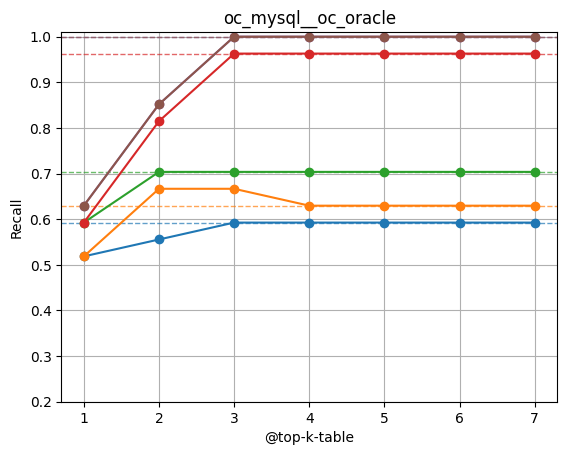

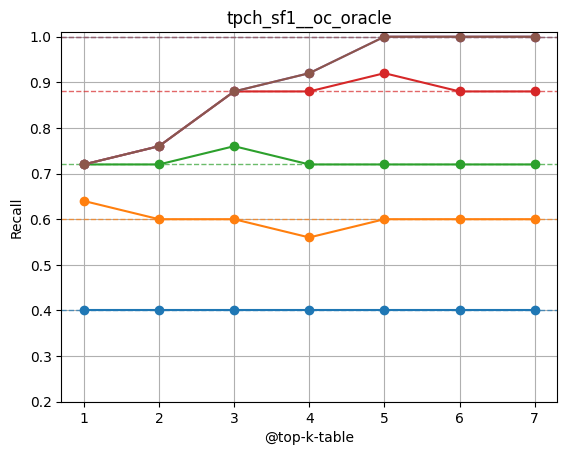

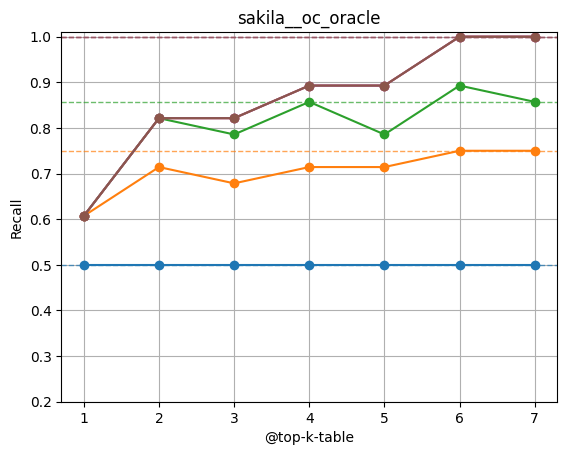

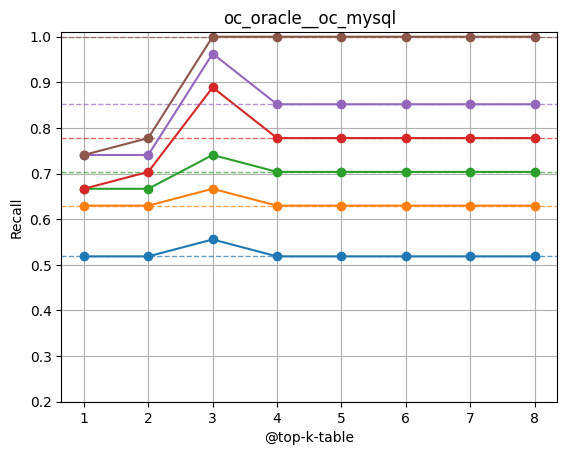

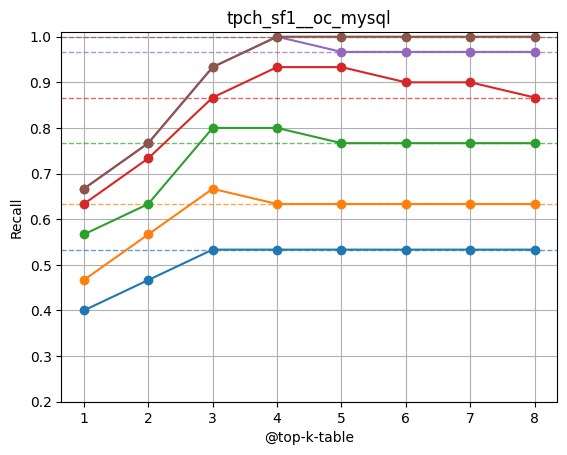

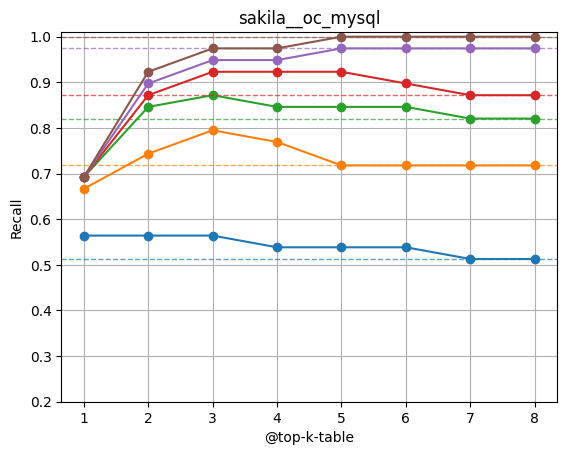

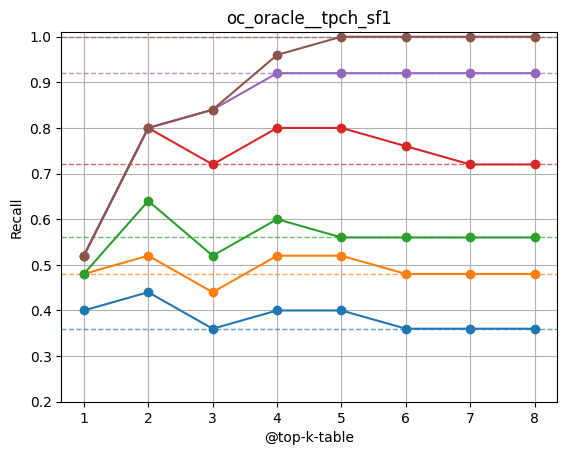

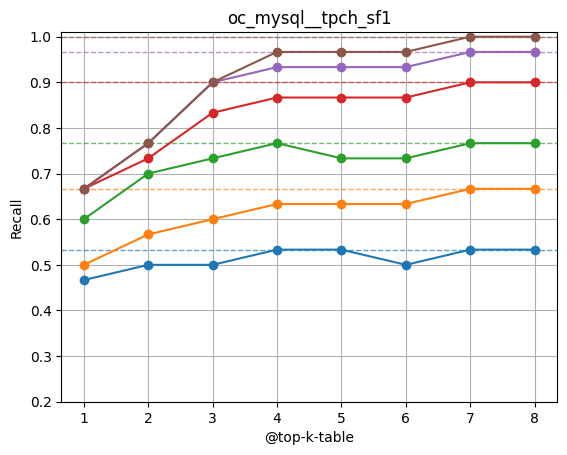

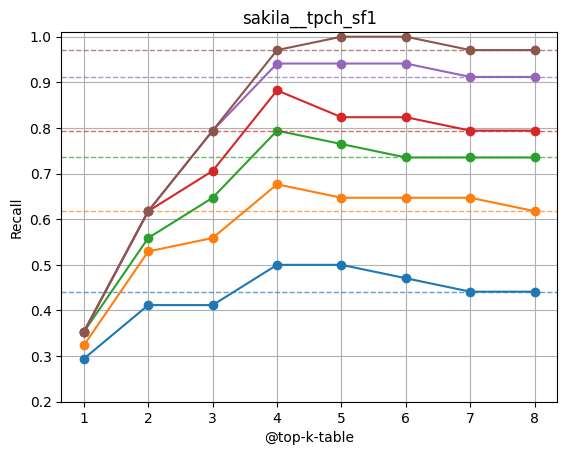

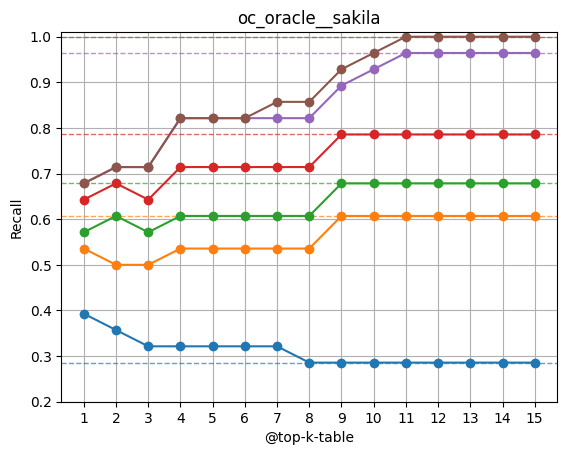

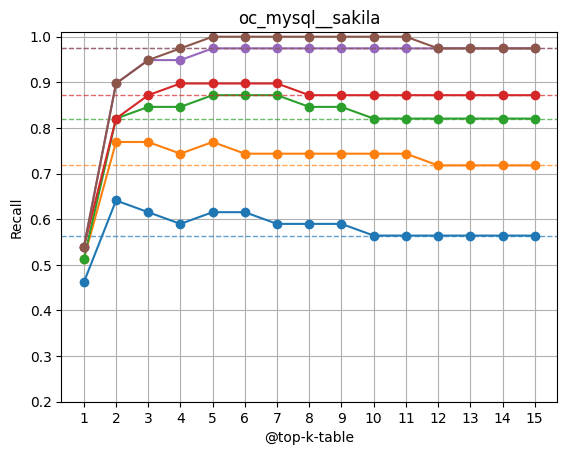

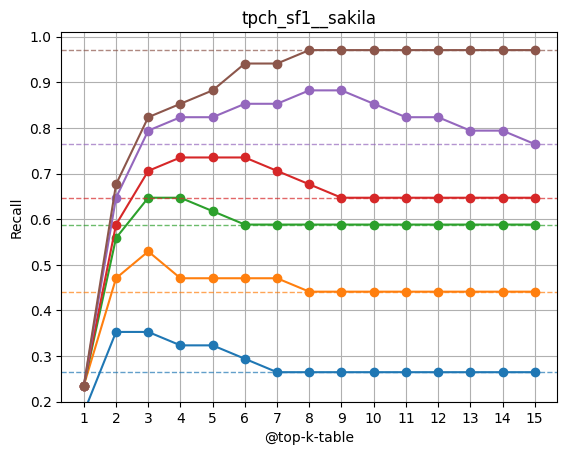

In [249]:
for i in np.arange(len(list_entities_a_exCHP)):
    df_tmp = evaluate_summary(list_entities_a_exCHP[i], list_entities_b_exCHP[i], table_predicts[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    plot_performance_by_table_k(df_tmp, top_ks, title=gt_keys[i], metric='recall', legend=False)

In [ ]:
for i in np.arange(len(list_entities_a_exCHP)):
    df_tmp = evaluate_summary(list_entities_a_exCHP[i], list_entities_b_exCHP[i], table_predicts[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    plot_performance_by_table_k(df_tmp, top_ks, title=gt_keys[i], metric='map', legend=False)

## b.3) Complete Transfer-Learning

In [246]:
def combine_global_mtl_data(schema_data):
    """Combines features (X) and labels (Y) for Global Multi-Task Learning."""
    
    table_sizes = [data['num_tables'] for data in schema_data]
    total_tables = sum(table_sizes)
    
    X_mtl_list = []
    Y_mtl_list = []
    
    # Calculate the padding segments for each schema
    for i, data in enumerate(schema_data):
        Xa = data['X']
        Ya = data['Y']
        
        # 1. Prepare Features
        X_mtl_list.append(Xa)
        
        # 2. Prepare Labels (Y) with Padding
        
        # --- Pre-padding (zeros for schemas 1 to i-1) ---
        pre_padding_size = sum(table_sizes[:i])
        pre_padding = np.zeros((Ya.shape[0], pre_padding_size), dtype=Ya.dtype)
        
        # --- Post-padding (zeros for schemas i+1 to N) ---
        post_padding_size = sum(table_sizes[i+1:])
        post_padding = np.zeros((Ya.shape[0], post_padding_size), dtype=Ya.dtype)

        # Concatenate: [0_pre | Y_i | 0_post]
        Y_i_padded = np.concatenate([pre_padding, Ya, post_padding], axis=1)
        
        Y_mtl_list.append(Y_i_padded)

    # Final concatenation
    X_mtl = np.concatenate(X_mtl_list, axis=0)
    Y_mtl = np.concatenate(Y_mtl_list, axis=0)
    
    return X_mtl, Y_mtl, table_sizes

In [247]:
def masked_focal_loss_global(gamma=2.0, alpha=0.9, table_sizes=None):
    """Focal Loss adapted for Global Multi-Task Learning with dynamic segmentation."""
    if table_sizes is None or not table_sizes:
        raise ValueError("table_sizes (list of N_i) must be provided for masking.")
        
    alpha_tensor = tf.constant(alpha, dtype=tf.float32)
    num_schemas = len(table_sizes)
    
    # Pre-calculate segment boundaries (start indices)
    # [0, T1, T1+T2, T1+T2+T3, ...]
    segment_starts = np.cumsum([0] + table_sizes).tolist()
    
    def masked_focal_loss_fn(y_true, y_pred):
        
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        # 1. Calculate Focal Loss terms (raw, unmasked)
        bce = y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred)
        pt = tf.exp(bce)
        focal_loss_raw = -alpha_tensor * (1. - pt)**gamma * bce
        
        # 2. Dynamic Mask Calculation
        
        # Initialize the final mask tensor
        batch_size = tf.shape(y_true)[0]
        mask = tf.zeros_like(y_true, dtype=tf.float32)
        
        # Iterate over all possible schemas (i=0 to N-1)
        for i in range(num_schemas):
            start_idx = segment_starts[i]
            end_idx = segment_starts[i+1]
            
            # Check if this sample originates from Schema i (based on non-zero labels in its segment)
            # is_from_i shape: (batch_size, 1)
            is_from_i = tf.reduce_any(y_true[:, start_idx:end_idx] > 0, axis=1, keepdims=True)
            
            # Create a 1D tensor for the current segment [0, 0, ..., 1, 1, ..., 0]
            segment_mask_1D = tf.concat([
                tf.zeros([start_idx], dtype=tf.float32), 
                tf.ones([table_sizes[i]], dtype=tf.float32),
                tf.zeros([tf.shape(y_true)[1] - end_idx], dtype=tf.float32)
            ], axis=0)
            
            # Expand mask to (batch_size, total_tables) and broadcast with is_from_i
            segment_mask_expanded = tf.expand_dims(segment_mask_1D, axis=0)
            
            # Use tf.where to build the full mask by selecting where is_from_i is True
            # We add the new segment mask to the existing mask
            mask = tf.where(
                is_from_i, 
                tf.ones_like(mask, dtype=tf.float32) * segment_mask_expanded, # Create the full mask row
                mask
            )
        
        # 3. Apply and Reduce Loss
        total_focal_loss = focal_loss_raw * mask
        loss_per_sample = tf.reduce_sum(total_focal_loss, axis=-1)
        
        return tf.reduce_mean(loss_per_sample)

    return masked_focal_loss_fn

In [248]:
def train_global_semantic_column_mtl_kfold(entities_list, alpha=0.9, epochs=100, batch_size=16, n_splits=5, dropout_rate=0.2, hidden_units=512, l2_reg=0.001, learning_rate=0.001, random_state=42):
    # --- 1. Global Data Combination and Metrics ---
    
    # 1.1 Extract X, Y, and Table Sizes for all schemas
    schema_data = []
    for entities in entities_list:
        X = get_entity_signatures(entities, "text_sequence")
        Y = get_entity_signatures(entities, "parent_onehot")
        schema_data.append({'X': X, 'Y': Y, 'num_tables': Y.shape[1], 'num_columns': len(X)})
        
    # 1.2 Combine data using the global function (defined below)
    X_mtl, Y_mtl, table_sizes = combine_global_mtl_data(schema_data)
    
    # Printing Information
    print("================================")
    print(f"Global MTL Model ({len(entities_list)} Schemas)")
    
    total_tables = sum(table_sizes)
    print(f"#Schemas: {len(entities_list)}")
    print(f"#Columns (Total): {len(X_mtl)}")
    print(f"#Tables/Classes (Total): {total_tables}")
    print(f"Table Sizes: {table_sizes}")
    print("================================")
    
    embedding_size = X_mtl.shape[1]
    
    # Dictionary to store the trained models
    ensemble_models = {} 
    
    # Proxy for stratification: Create a unique string representation of the multi-label vector
    y_stratify_proxy = [''.join(str(int(i)) for i in row) for row in Y_mtl]

    # Initialize Stratified K-Fold
    if random_state:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    for fold, (train_index, val_index) in enumerate(skf.split(X_mtl, y_stratify_proxy)):
        print(f"\n--- Training Fold {fold+1}/{n_splits} ---")

        # Split combined data
        X_train, X_val = X_mtl[train_index], X_mtl[val_index]
        Y_train, Y_val = Y_mtl[train_index], Y_mtl[val_index]

        # 2. Instantiate and Compile Model 
        model = semantic_column_table_mtl(in_channels=embedding_size, out_table_pred=total_tables, hidden_units=hidden_units, dropout_rate=dropout_rate, l2_reg=l2_reg)
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=masked_focal_loss_global(gamma=2.0, alpha=alpha, table_sizes=table_sizes), 
            metrics=['precision', 'recall']
        )

        # 3. Train Model
        history = model.fit(
            X_train, Y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=0,
            validation_data=(X_val, Y_val),
            shuffle=True
        )
        
        # 4. Store Model 
        ensemble_models[f'model_{fold+1}'] = model
        
        val_loss, val_precision, val_recall = model.evaluate(X_val, Y_val, verbose=0)
        print(f"Fold {fold+1} Validation Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
    
    print(f"\nTraining Complete. Total Tables: {total_tables}. Trained {n_splits} models.")
    return ensemble_models

#### Training

In [257]:
cross_ensemble = train_global_semantic_column_mtl_kfold([entities_ocoracle_ser,
                                                         entities_ocmysql_ser,
                                                         entities_tpch_ser,
                                                         entities_sakila_ser])

Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3486, Precision: 0.2446, Recall: 0.7234

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3479, Precision: 0.2179, Recall: 0.7234

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3307, Precision: 0.2590, Recall: 0.7660

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3579, Precision: 0.2388, Recall: 0.6957

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3193, Precision: 0.2556, Recall: 0.7391

Training Complete. Total Tables: 38. Trained 5 models.


In [299]:
cross_ensemble_hop1 = train_global_semantic_column_mtl_kfold([entities_ocoracle_augmented_hop1_ser, entities_ocmysql_augmented_hop1_ser,
                                                              entities_tpch_augmented_hop1_ser, entities_sakila_augmented_hop1_ser])

Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 821
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3633, Precision: 0.2634, Recall: 0.7633

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3740, Precision: 0.2606, Recall: 0.7463

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3911, Precision: 0.2686, Recall: 0.6886

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3803, Precision: 0.2587, Recall: 0.7102

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3844, Precision: 0.2617, Recall: 0.7553

Training Complete. Total Tables: 38. Trained 5 models.


In [122]:
cross_ensemble_hop1_exCHP = train_global_semantic_column_mtl_kfold([entities_ocoracle_augmented_hop1_ser_exCHP, entities_ocmysql_augmented_hop1_ser_exCHP,
                                                                    entities_tpch_augmented_hop1_ser_exCHP, entities_sakila_augmented_hop1_ser_exCHP])

Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 821
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3110, Precision: 0.2887, Recall: 0.7915

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3000, Precision: 0.3006, Recall: 0.7647

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3319, Precision: 0.2989, Recall: 0.7820

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3321, Precision: 0.3132, Recall: 0.7703

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3188, Precision: 0.2939, Recall: 0.7660

Training Complete. Total Tables: 38. Trained 5 models.


In [274]:
cross_ensemble = train_global_semantic_column_mtl_kfold([entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP])

Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3502, Precision: 0.2558, Recall: 0.7021

--- Training Fold 2/5 ---


#### Table Prediction Evaluation

In [259]:
dict_schema_table_prediction_mask = {
    "OC_ORACLE": [0, 7],
    "OC_MYSQL": [7, 15],
    "TPCH_SF1": [15, 23],
    "SAKILA": [23, 38]
}

In [ ]:
def column_table_predictions_mtl_global_ensemble(
    entities_source, 
    schema_target_name, 
    df_graph, 
    ensemble_models, 
    prob_column_verbose="id", 
    meta=False
):
    
    # --- 1. Determine Slicing Boundaries based on Target Schema ---
    
    # The mask dictionary holds [start_index, end_index] for the target schema
    mask_indices = dict_schema_table_prediction_mask[schema_target_name]
    slice_start = mask_indices[0]
    slice_end = mask_indices[1]
    
    # 1.2 Get the column headers (table names for the target schema)
    prob_cols_df = df_graph[(df_graph.schema == schema_target_name) & 
                            (df_graph.type == "table")][prob_column_verbose]
    prob_cols = prob_cols_df.values

    
    # --- 2. Prepare Input Features and Predict (Ensemble) --- 
    Xa = get_entity_signatures(entities_source, "text_sequence")
    
    all_predictions_target = []

    for model_name, model in ensemble_models.items():
        # Predict using the single global model
        predictions_mtl = model.predict(Xa, verbose=0)
        
        # Slice according to the pre-determined global index range
        predictions_target_single = predictions_mtl[:, slice_start:slice_end]
        all_predictions_target.append(predictions_target_single)

    # Average the predictions across all models
    if all_predictions_target:
        # Stack the predictions and compute the mean across the model axis (axis=0)
        predictions_target = np.mean(np.stack(all_predictions_target, axis=0), axis=0)
    else:
        return pd.DataFrame() 
    
    # --- 3. Create Output DataFrame --- 
    table_predict_schema = pd.DataFrame(
        data=predictions_target,
        columns=prob_cols
    )

    table_predict_schema.insert(loc=0, column='id_a', value=get_entity_signatures(entities_source, "entity_id"))

    # --- 4. Add Metadata and Top-K Ranking ---
    if meta:
        
        table_predict_schema.insert(loc=1, column='name_a', value=get_entity_signatures(entities_source, "name"))
        table_predict_schema.insert(loc=2, column='parent_id_a', value=get_entity_signatures(entities_source, "parent_id"))
        table_predict_schema.insert(loc=3, column='parent_name_a', value=[get_entity_name_by_id(parent_id, df_graph) for parent_id in get_entity_signatures(entities_source, "parent_id")])
        table_predict_schema.insert(loc=4, column='schema_a', value=get_entity_signatures(entities_source, "schema"))
        
        # Ranking
        table_predict_schema['ranked_tables'] = table_predict_schema[prob_cols].apply(
            lambda row: get_top_k_ranks(row, k=len(prob_cols), prob_cols=prob_cols), axis=1
        )
        
        for i in np.arange(len(prob_cols)):
            table_predict_schema[f'top_{i+1}'] = table_predict_schema['ranked_tables'].str[i]
        
        table_predict_schema = table_predict_schema.drop(columns=['ranked_tables'])

    return table_predict_schema

In [613]:
# column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "SAKILA", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="name", meta=True)[vis_pred_columns].head(40)

In [261]:
#default verbose without augmentation
results = []

table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "OC_ORACLE", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "OC_ORACLE", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)

table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "OC_MYSQL", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "OC_MYSQL", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)

table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "TPCH_SF1", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "TPCH_SF1", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)      

table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "SAKILA", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "SAKILA", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "SAKILA", df_OC3HR, cross_ensemble, prob_column_verbose="id", meta=True)
  

In [300]:
#default verbose
results = []

table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)

table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)

table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)      

table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "SAKILA", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "SAKILA", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "SAKILA", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
  

In [262]:
results = []

matching_keys = ['oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'sakila__oc_oracle', 
                 'oc_oracle__oc_mysql', 'tpch_sf1__oc_mysql', 'sakila__oc_mysql', 
                 'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'sakila__tpch_sf1',
                 'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila']


df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_cross_b, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[0], "precision"] + precision_plot)  
results.append([matching_keys[0], "recall"] + recall_plot)
results.append([matching_keys[0], "f1"] + f1_plot)

df_tmp = column_table_matches(table_predict_ocoracle_tpch_cross_b, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[1], "precision"] + precision_plot)  
results.append([matching_keys[1], "recall"] + recall_plot)
results.append([matching_keys[1], "f1"] + f1_plot)

#sakila_ocoracle
df_tmp = column_table_matches(table_predict_ocoracle_sakila_cross_b, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[2], "precision"] + precision_plot)  
results.append([matching_keys[2], "recall"] + recall_plot)
results.append([matching_keys[2], "f1"] + f1_plot)

############################################################

df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_cross_a, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[3], "precision"] + precision_plot)  
results.append([matching_keys[3], "recall"] + recall_plot)
results.append([matching_keys[3], "f1"] + f1_plot)


df_tmp = column_table_matches(table_predict_ocmysql_tpch_cross_b, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[4], "precision"] + precision_plot)  
results.append([matching_keys[4], "recall"] + recall_plot)
results.append([matching_keys[4], "f1"] + f1_plot)

#sakila_ocmysql
df_tmp = column_table_matches(table_predict_ocmysql_sakila_cross_b, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[5], "precision"] + precision_plot)  
results.append([matching_keys[5], "recall"] + recall_plot)
results.append([matching_keys[5], "f1"] + f1_plot)

############################################################

#oc_oracle__tpch_sf1
df_tmp = column_table_matches(table_predict_ocoracle_tpch_cross_a, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[6], "precision"] + precision_plot)  
results.append([matching_keys[6], "recall"] + recall_plot)
results.append([matching_keys[6], "f1"] + f1_plot)

#oc_mysql__tpch_sf1
df_tmp = column_table_matches(table_predict_ocmysql_tpch_cross_a, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[7], "precision"] + precision_plot)  
results.append([matching_keys[7], "recall"] + recall_plot)
results.append([matching_keys[7], "f1"] + f1_plot)

#sakila__tpch_sf1
df_tmp = column_table_matches(table_predict_tpch_sakila_cross_b, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[8], "precision"] + precision_plot)  
results.append([matching_keys[8], "recall"] + recall_plot)
results.append([matching_keys[8], "f1"] + f1_plot)

############################################################

#oc_oracle__sakila
df_tmp = column_table_matches(table_predict_ocoracle_sakila_cross_a, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[9], "precision"] + precision_plot)  
results.append([matching_keys[9], "recall"] + recall_plot) 
results.append([matching_keys[9], "f1"] + f1_plot)

#oc_mysql__sakila
df_tmp = column_table_matches(table_predict_ocmysql_sakila_cross_a, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[10], "precision"] + precision_plot)  
results.append([matching_keys[10], "recall"] + recall_plot)
results.append([matching_keys[10], "f1"] + f1_plot)

#tpch_sf1__sakila
df_tmp = column_table_matches(table_predict_tpch_sakila_cross_a, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[11], "precision"] + precision_plot)  
results.append([matching_keys[11], "recall"] + recall_plot)
results.append([matching_keys[11], "f1"] + f1_plot)

######################################


df_table_cross_prediction_results = pd.DataFrame(data=results, columns=["schemas_column_table_pred", "metric", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8",
                                                                            "top_9", "top_10", "top_11", "top_12", "top_13", "top_14", "top_15", "top_16"])
# df_table_prediction_results_a95_hop2.fillna(1, inplace=True)

In [263]:
df_table_cross_prediction_results[df_table_cross_prediction_results.metric=="recall"]

schemas_column_table_pred  metric  top_1  top_2  top_3  top_4  top_5  \
1        oc_mysql__oc_oracle  recall  0.667  0.704  1.000  1.000  1.000   
4        tpch_sf1__oc_oracle  recall  0.560  0.800  0.960  0.960  0.960   
7          sakila__oc_oracle  recall  0.679  0.679  0.929  0.929  0.964   
10       oc_oracle__oc_mysql  recall  0.857  0.952  1.000  1.000  1.000   
13        tpch_sf1__oc_mysql  recall  0.500  0.625  0.875  1.000  1.000   
16          sakila__oc_mysql  recall  0.615  0.923  0.974  0.974  0.974   
19       oc_oracle__tpch_sf1  recall  0.680  0.880  0.960  0.960  0.960   
22        oc_mysql__tpch_sf1  recall  0.633  0.800  0.967  1.000  1.000   
25          sakila__tpch_sf1  recall  0.471  0.618  0.765  1.000  1.000   
28         oc_oracle__sakila  recall  0.571  0.714  0.810  0.810  0.857   
31          oc_mysql__sakila  recall  0.513  0.846  0.872  0.923  0.949   
34          tpch_sf1__sakila  recall  0.370  0.667  0.889  0.963  0.963   

    top_6  top_7  top_8  top_9  top_10  top_11  top_12  top_13  top_14  \
1   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
4   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
7   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
10  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
13  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
16  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
19  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
22  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
25  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
28  0.952  0.952  0.952  0.952   1.000   1.000   1.000   1.000   1.000   
31  0.974  0.974  0.974  1.000   1.000   1.000   1.000   1.000   1.000   
34  1.000  1.000  1.000  1.000   1.000   1.000   1.000   1.000   1.000   

    top_15  top_16  
1      NaN     NaN  
4      NaN     NaN  
7      NaN     NaN  
10     NaN     NaN  
13     NaN     NaN  
16     NaN     NaN  
19     NaN     NaN  
22     NaN     NaN  
25     NaN     NaN  
28   1.000   1.000  
31   1.000   1.000  
34   1.000   1.000

In [264]:
df_table_cross_prediction_results_recall=df_table_cross_prediction_results[df_table_cross_prediction_results.metric=="recall"]

In [266]:
#Mean(sakila!=target)
pd.DataFrame(data=df_table_cross_prediction_results_recall[~df_table_cross_prediction_results_recall.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.629  0.776  0.937  0.980  0.984  1.000  1.000  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [267]:
#Mean(sakila = target)
pd.DataFrame(data=df_table_cross_prediction_results_recall[df_table_cross_prediction_results_recall.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.485  0.742  0.857  0.899  0.923  0.976  0.976  0.976  0.984   1.000   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

In [265]:
#Mean(all)
pd.DataFrame(data=df_table_cross_prediction_results_recall.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.593  0.767  0.917  0.960  0.969  0.994  0.994  0.992  0.984   1.000   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   1.000   1.000   1.000   1.000   1.000   1.000

In [ ]:
def semcti_global_evaluation(iter=10, serialization= "vserialization", augmented=True):
    # path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerReference_dmax2/'
    path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerValues_dmax2/'
    for i in range(iter):

        if serialization == "vserialization":
            if augmented:
                cross_ensemble_hop1 = train_global_semantic_column_mtl_kfold([entities_ocoracle_augmented_hop1_ser, entities_ocmysql_augmented_hop1_ser, entities_tpch_augmented_hop1_ser, entities_sakila_augmented_hop1_ser], random_state=None)
            else:
                cross_ensemble_hop1 = train_global_semantic_column_mtl_kfold([entities_ocoracle_ser, entities_ocmysql_ser, entities_tpch_ser, entities_sakila_ser], random_state=None)


            table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)

            table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)

            table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)      

            table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser, "SAKILA", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser, "SAKILA", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_tpch_ser, "SAKILA", df_OC3HR, cross_ensemble_hop1, prob_column_verbose="id", meta=True)


        #_exCHP
        if serialization == "vserialization_exCHP":
            cross_ensemble_hop1_exCHP = train_global_semantic_column_mtl_kfold([entities_ocoracle_augmented_hop1_ser_exCHP, entities_ocmysql_augmented_hop1_ser_exCHP,
                                                                                entities_tpch_augmented_hop1_ser_exCHP, entities_sakila_augmented_hop1_ser_exCHP], random_state=None)
            
            table_predict_ocoracle_ocmysql_cross_b = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)
            table_predict_ocoracle_tpch_cross_b = column_table_predictions_mtl_global_ensemble(entities_tpch_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)
            table_predict_ocoracle_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser_exCHP, "OC_ORACLE", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)

            table_predict_ocoracle_ocmysql_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_tpch_cross_b = column_table_predictions_mtl_global_ensemble(entities_tpch_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser_exCHP, "OC_MYSQL", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)

            table_predict_ocoracle_tpch_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_tpch_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_cross_b = column_table_predictions_mtl_global_ensemble(entities_sakila_ser_exCHP, "TPCH_SF1", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)      

            table_predict_ocoracle_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocoracle_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)
            table_predict_ocmysql_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_ocmysql_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)
            table_predict_tpch_sakila_cross_a = column_table_predictions_mtl_global_ensemble(entities_tpch_ser_exCHP, "SAKILA", df_OC3HR, cross_ensemble_hop1_exCHP, prob_column_verbose="id", meta=True)


        results = []


        df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_cross_b, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[0], "precision"] + precision_plot)  
        results.append([matching_keys[0], "recall"] + recall_plot)
        results.append([matching_keys[0], "f1"] + f1_plot)

        df_tmp = column_table_matches(table_predict_ocoracle_tpch_cross_b, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[1], "precision"] + precision_plot)  
        results.append([matching_keys[1], "recall"] + recall_plot)
        results.append([matching_keys[1], "f1"] + f1_plot)

        #sakila_ocoracle
        df_tmp = column_table_matches(table_predict_ocoracle_sakila_cross_b, top_k_table=7)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
        results.append([matching_keys[2], "precision"] + precision_plot)  
        results.append([matching_keys[2], "recall"] + recall_plot)
        results.append([matching_keys[2], "f1"] + f1_plot)

        ############################################################

        df_tmp = column_table_matches(table_predict_ocoracle_ocmysql_cross_a, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[3], "precision"] + precision_plot)  
        results.append([matching_keys[3], "recall"] + recall_plot)
        results.append([matching_keys[3], "f1"] + f1_plot)


        df_tmp = column_table_matches(table_predict_ocmysql_tpch_cross_b, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[4], "precision"] + precision_plot)  
        results.append([matching_keys[4], "recall"] + recall_plot)
        results.append([matching_keys[4], "f1"] + f1_plot)

        #sakila_ocmysql
        df_tmp = column_table_matches(table_predict_ocmysql_sakila_cross_b, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[5], "precision"] + precision_plot)  
        results.append([matching_keys[5], "recall"] + recall_plot)
        results.append([matching_keys[5], "f1"] + f1_plot)

        ############################################################

        #oc_oracle__tpch_sf1
        df_tmp = column_table_matches(table_predict_ocoracle_tpch_cross_a, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[6], "precision"] + precision_plot)  
        results.append([matching_keys[6], "recall"] + recall_plot)
        results.append([matching_keys[6], "f1"] + f1_plot)

        #oc_mysql__tpch_sf1
        df_tmp = column_table_matches(table_predict_ocmysql_tpch_cross_a, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[7], "precision"] + precision_plot)  
        results.append([matching_keys[7], "recall"] + recall_plot)
        results.append([matching_keys[7], "f1"] + f1_plot)

        #sakila__tpch_sf1
        df_tmp = column_table_matches(table_predict_tpch_sakila_cross_b, top_k_table=8)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
        results.append([matching_keys[8], "precision"] + precision_plot)  
        results.append([matching_keys[8], "recall"] + recall_plot)
        results.append([matching_keys[8], "f1"] + f1_plot)

        ############################################################

        #oc_oracle__sakila
        df_tmp = column_table_matches(table_predict_ocoracle_sakila_cross_a, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[9], "precision"] + precision_plot)  
        results.append([matching_keys[9], "recall"] + recall_plot) 
        results.append([matching_keys[9], "f1"] + f1_plot)

        #oc_mysql__sakila
        df_tmp = column_table_matches(table_predict_ocmysql_sakila_cross_a, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[10], "precision"] + precision_plot)  
        results.append([matching_keys[10], "recall"] + recall_plot)
        results.append([matching_keys[10], "f1"] + f1_plot)

        #tpch_sf1__sakila
        df_tmp = column_table_matches(table_predict_tpch_sakila_cross_a, top_k_table=15)
        precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__sakila"], top_k=16, sim_metric="top", return_metrics=True)
        results.append([matching_keys[11], "precision"] + precision_plot)  
        results.append([matching_keys[11], "recall"] + recall_plot)
        results.append([matching_keys[11], "f1"] + f1_plot)


        ############################################################

        df_semcti_global_eval = pd.DataFrame(data=results, columns=["schemas_column_table_pred", "metric", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8",
                                                                        "top_9", "top_10", "top_11", "top_12", "top_13", "top_14", "top_15", "top_16"])
        
        eval_file_name = "semcti_global_"+str(i)+".csv"
        print(eval_file_name)
        df_semcti_global_eval.to_csv(path+eval_file_name, index=False)
    

In [ ]:
semcti_global_evaluation(10)
# 72 min

In [ ]:
semcti_global_evaluation(iter=10, serialization= "vserialization_exCHP")

In [269]:
semcti_global_evaluation(iter=10, serialization= "vserialization", augmented=False)

Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3698, Precision: 0.2158, Recall: 0.6383

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3841, Precision: 0.2370, Recall: 0.6809

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3298, Precision: 0.2661, Recall: 0.7021

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3322, Precision: 0.2519, Recall: 0.7391

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3728, Precision: 0.2313, Recall: 0.6739

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_0.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3109, Precision: 0.2748, Recall: 0.7660

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3069, Precision: 0.2617, Recall: 0.8298

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3678, Precision: 0.2742, Recall: 0.7234

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3937, Precision: 0.2013, Recall: 0.6739

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3340, Precision: 0.2576, Recall: 0.7391

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_1.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3351, Precision: 0.2463, Recall: 0.7021

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.4075, Precision: 0.2319, Recall: 0.6809

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3261, Precision: 0.2378, Recall: 0.7234

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3531, Precision: 0.2361, Recall: 0.7391

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3034, Precision: 0.2685, Recall: 0.8696

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_2.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3504, Precision: 0.2532, Recall: 0.8298

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3711, Precision: 0.2432, Recall: 0.7660

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3450, Precision: 0.2500, Recall: 0.7234

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3189, Precision: 0.2483, Recall: 0.7826

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3141, Precision: 0.2500, Recall: 0.6957

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_3.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3071, Precision: 0.2583, Recall: 0.8298

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3561, Precision: 0.2500, Recall: 0.6596

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3582, Precision: 0.2319, Recall: 0.6809

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3781, Precision: 0.2361, Recall: 0.7391

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3387, Precision: 0.2378, Recall: 0.7391

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_4.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.2975, Precision: 0.2483, Recall: 0.7872

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3064, Precision: 0.2748, Recall: 0.7660

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3789, Precision: 0.2574, Recall: 0.7447

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3788, Precision: 0.2128, Recall: 0.6522

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3793, Precision: 0.2336, Recall: 0.6957

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_5.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3160, Precision: 0.2411, Recall: 0.7234

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3127, Precision: 0.2483, Recall: 0.7660

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3916, Precision: 0.2308, Recall: 0.7021

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3726, Precision: 0.2426, Recall: 0.7174

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3253, Precision: 0.2518, Recall: 0.7609

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_6.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3422, Precision: 0.2400, Recall: 0.7660

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3459, Precision: 0.2647, Recall: 0.7660

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3423, Precision: 0.2222, Recall: 0.6383

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3172, Precision: 0.2258, Recall: 0.7609

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3709, Precision: 0.2500, Recall: 0.6957

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_7.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3376, Precision: 0.2615, Recall: 0.7234

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3631, Precision: 0.2615, Recall: 0.7234

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3902, Precision: 0.2519, Recall: 0.7021

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3735, Precision: 0.2481, Recall: 0.7174

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3135, Precision: 0.2667, Recall: 0.7826

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_8.csv
Global MTL Model (4 Schemas)
#Schemas: 4
#Columns (Total): 233
#Tables/Classes (Total): 38
Table Sizes: [7, 8, 8, 15]

--- Training Fold 1/5 ---


c:\Users\leona\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1 Validation Loss: 0.3475, Precision: 0.2595, Recall: 0.7234

--- Training Fold 2/5 ---
Fold 2 Validation Loss: 0.3463, Precision: 0.2339, Recall: 0.6170

--- Training Fold 3/5 ---
Fold 3 Validation Loss: 0.3852, Precision: 0.2319, Recall: 0.6809

--- Training Fold 4/5 ---
Fold 4 Validation Loss: 0.3187, Precision: 0.2393, Recall: 0.8478

--- Training Fold 5/5 ---
Fold 5 Validation Loss: 0.3776, Precision: 0.2339, Recall: 0.6304

Training Complete. Total Tables: 38. Trained 5 models.
semcti_global_9.csv


In [ ]:
path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerReference_dmax2/'
# path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerValues_dmax2/'
# path = 'C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_SerReference_dmax1/'

# Run the aggregation
df_semcti_global_mean, df_semcti_global_std, df_semcti_global_formatted = aggregate_recall_results(path, iter_count=10, approach="global")

# df_semcti_global_mean.to_csv(path+"df_semcti_global_mean.csv", index=False)
# df_semcti_global_std.to_csv(path+"df_semcti_global_std.csv", index=False)
# df_semcti_global_formatted.to_csv(path+"df_semcti_global_formatted.csv", index=False)


Loading 10 files from: C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results/


In [329]:
# Complete
df_semcti_global_formatted

schemas_column_table_pred  metric          top_1          top_2  \
0        oc_mysql__oc_oracle  recall  0.663 ± 0.012  0.707 ± 0.012   
10       tpch_sf1__oc_oracle  recall  0.516 ± 0.044  0.792 ± 0.025   
7          sakila__oc_oracle  recall  0.679 ± 0.029  0.711 ± 0.026   
3        oc_oracle__oc_mysql  recall  0.871 ± 0.032  0.957 ± 0.015   
9         tpch_sf1__oc_mysql  recall  0.492 ± 0.018  0.629 ± 0.013   
6           sakila__oc_mysql  recall  0.644 ± 0.019  0.897 ± 0.017   
5        oc_oracle__tpch_sf1  recall   0.64 ± 0.027  0.868 ± 0.027   
2         oc_mysql__tpch_sf1  recall    0.633 ± 0.0  0.773 ± 0.034   
8           sakila__tpch_sf1  recall  0.426 ± 0.029  0.615 ± 0.038   
4          oc_oracle__sakila  recall  0.581 ± 0.038  0.714 ± 0.022   
1           oc_mysql__sakila  recall  0.597 ± 0.047  0.846 ± 0.024   
11          tpch_sf1__sakila  recall  0.393 ± 0.047   0.678 ± 0.05   

            top_3          top_4          top_5          top_6          top_7  \
0   0.989 ± 0.018      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
10     0.96 ± 0.0     0.96 ± 0.0     0.96 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
7    0.932 ± 0.02  0.946 ± 0.019    0.964 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
3   0.967 ± 0.023      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
9   0.892 ± 0.045  0.992 ± 0.018      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
6   0.964 ± 0.013  0.979 ± 0.011  0.987 ± 0.014      1.0 ± 0.0      1.0 ± 0.0   
5      0.96 ± 0.0     0.96 ± 0.0     0.96 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
2    0.91 ± 0.016   0.97 ± 0.011  0.983 ± 0.018      1.0 ± 0.0      1.0 ± 0.0   
8   0.765 ± 0.031  0.976 ± 0.012  0.979 ± 0.014      1.0 ± 0.0      1.0 ± 0.0   
4   0.757 ± 0.035  0.805 ± 0.015  0.862 ± 0.042  0.929 ± 0.034  0.938 ± 0.023   
1   0.892 ± 0.016  0.926 ± 0.008  0.951 ± 0.019  0.974 ± 0.012  0.992 ± 0.012   
11  0.807 ± 0.057  0.893 ± 0.027  0.967 ± 0.021  0.996 ± 0.012      1.0 ± 0.0   

            top_8        top_9         top_10         top_11         top_12  \
0       nan ± nan    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
10      nan ± nan    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
7       nan ± nan    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
3       1.0 ± 0.0    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
9       1.0 ± 0.0    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
6       1.0 ± 0.0    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
5       1.0 ± 0.0    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
2       1.0 ± 0.0    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
8       1.0 ± 0.0    nan ± nan      nan ± nan      nan ± nan      nan ± nan   
4     0.952 ± 0.0  0.952 ± 0.0  0.971 ± 0.025  0.995 ± 0.015  0.995 ± 0.015   
1   0.997 ± 0.008    1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
11      1.0 ± 0.0    1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   

       top_13     top_14     top_15     top_16  
0   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
10  nan ± nan  nan ± nan  nan ± nan  nan ± nan  
7   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
3   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
9   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
6   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
5   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
2   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
8   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
4   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
1   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
11  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0

In [330]:
# Complete Mean(sakila!=target)
pd.DataFrame(data=df_semcti_global_mean[~df_semcti_global_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.618  0.772  0.926  0.976  0.982  1.000  1.000  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [331]:
# Complete Mean(sakila = target)
pd.DataFrame(data=df_semcti_global_mean[df_semcti_global_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.524  0.746  0.819  0.874  0.927  0.966  0.977  0.983  0.984   0.990   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.998   0.998   1.000   1.000   1.000   1.000

In [332]:
# Complete Mean(all)
pd.DataFrame(data=df_semcti_global_mean.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.595  0.766  0.900  0.951  0.968  0.992  0.994  0.994  0.984   0.990   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.998   0.998   1.000   1.000   1.000   1.000

In [333]:
# Complete Std Mean(all)
pd.DataFrame(data=df_semcti_global_std.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.028  0.025  0.023  0.010  0.011  0.005  0.003  0.001  0.000   0.008   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.005   0.005   0.000   0.000   0.000   0.000

In [335]:
# ⊕ Complete
df_semcti_global_formatted

schemas_column_table_pred  metric          top_1          top_2  \
0        oc_mysql__oc_oracle  recall  0.626 ± 0.027  0.733 ± 0.023   
10       tpch_sf1__oc_oracle  recall  0.796 ± 0.035  0.884 ± 0.013   
7          sakila__oc_oracle  recall  0.682 ± 0.046    0.9 ± 0.037   
3        oc_oracle__oc_mysql  recall  0.824 ± 0.068  0.948 ± 0.015   
9         tpch_sf1__oc_mysql  recall  0.496 ± 0.013  0.688 ± 0.029   
6           sakila__oc_mysql  recall  0.446 ± 0.013  0.767 ± 0.008   
5        oc_oracle__tpch_sf1  recall  0.776 ± 0.028  0.908 ± 0.019   
2         oc_mysql__tpch_sf1  recall   0.68 ± 0.017   0.89 ± 0.016   
8           sakila__tpch_sf1  recall  0.329 ± 0.012  0.571 ± 0.021   
4          oc_oracle__sakila  recall    0.524 ± 0.0   0.71 ± 0.035   
1           oc_mysql__sakila  recall   0.423 ± 0.03  0.828 ± 0.042   
11          tpch_sf1__sakila  recall  0.378 ± 0.052  0.674 ± 0.046   

            top_3          top_4          top_5          top_6          top_7  \
0   0.819 ± 0.054      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
10  0.948 ± 0.019  0.992 ± 0.017      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
7   0.957 ± 0.015    0.964 ± 0.0    0.964 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
3   0.986 ± 0.023      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
9     0.917 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
6   0.972 ± 0.008    0.974 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
5      0.96 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
2   0.993 ± 0.014      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
8   0.868 ± 0.021  0.988 ± 0.015      1.0 ± 0.0      1.0 ± 0.0      1.0 ± 0.0   
4   0.729 ± 0.039  0.767 ± 0.027  0.795 ± 0.023  0.814 ± 0.015  0.843 ± 0.032   
1     0.9 ± 0.008  0.946 ± 0.008  0.951 ± 0.008  0.969 ± 0.011      1.0 ± 0.0   
11  0.822 ± 0.034   0.93 ± 0.037  0.978 ± 0.026      1.0 ± 0.0      1.0 ± 0.0   

            top_8        top_9        top_10         top_11        top_12  \
0       nan ± nan    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
10      nan ± nan    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
7       nan ± nan    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
3       1.0 ± 0.0    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
9       1.0 ± 0.0    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
6       1.0 ± 0.0    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
5       1.0 ± 0.0    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
2       1.0 ± 0.0    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
8       1.0 ± 0.0    nan ± nan     nan ± nan      nan ± nan     nan ± nan   
4   0.876 ± 0.033  0.905 ± 0.0  0.91 ± 0.015  0.933 ± 0.033  0.976 ± 0.04   
1       1.0 ± 0.0    1.0 ± 0.0     1.0 ± 0.0      1.0 ± 0.0     1.0 ± 0.0   
11      1.0 ± 0.0    1.0 ± 0.0     1.0 ± 0.0      1.0 ± 0.0     1.0 ± 0.0   

       top_13     top_14     top_15     top_16  
0   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
10  nan ± nan  nan ± nan  nan ± nan  nan ± nan  
7   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
3   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
9   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
6   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
5   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
2   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
8   nan ± nan  nan ± nan  nan ± nan  nan ± nan  
4   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
1   1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  
11  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0  1.0 ± 0.0

In [336]:
# ⊕ Complete Mean(sakila!=target)
pd.DataFrame(data=df_semcti_global_mean[~df_semcti_global_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.628  0.810  0.935  0.991  0.996  1.000  1.000  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [337]:
# ⊕ Complete Mean(sakila = target)
pd.DataFrame(data=df_semcti_global_mean[df_semcti_global_mean.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.442  0.737  0.817  0.881  0.908  0.928  0.948  0.959  0.968   0.970   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.978   0.992   1.000   1.000   1.000   1.000

In [338]:
# ⊕ Complete Mean(all)
pd.DataFrame(data=df_semcti_global_mean.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.582  0.792  0.906  0.963  0.974  0.982  0.987  0.986  0.968   0.970   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.978   0.992   1.000   1.000   1.000   1.000

In [339]:
# ⊕ Complete Std Mean(all)
pd.DataFrame(data=df_semcti_global_std.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.028  0.025  0.020  0.009  0.005  0.002  0.003  0.004  0.000   0.005   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.011   0.013   0.000   0.000   0.000   0.000

### Table Blocking Evaluation

In [308]:
table_predicts = [table_predict_ocoracle_ocmysql_cross_b, table_predict_ocoracle_tpch_cross_b, table_predict_ocoracle_sakila_cross_b,
                  table_predict_ocoracle_ocmysql_cross_a, table_predict_ocmysql_tpch_cross_b, table_predict_ocmysql_sakila_cross_b,
                  table_predict_ocoracle_tpch_cross_a, table_predict_ocmysql_tpch_cross_a, table_predict_tpch_sakila_cross_b,
                  table_predict_ocoracle_sakila_cross_a, table_predict_ocmysql_sakila_cross_a, table_predict_tpch_sakila_cross_a]

In [309]:
list_entities_a = [entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP,
                   entities_ocoracle_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP,
                   entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_sakila_ser_exCHP,
                   entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP]
list_entities_b = [entities_ocoracle_ser_exCHP, entities_ocoracle_ser_exCHP, entities_ocoracle_ser_exCHP,
                   entities_ocmysql_ser_exCHP, entities_ocmysql_ser_exCHP, entities_ocmysql_ser_exCHP,
                   entities_tpch_ser_exCHP, entities_tpch_ser_exCHP, entities_tpch_ser_exCHP,
                   entities_sakila_ser_exCHP, entities_sakila_ser_exCHP, entities_sakila_ser_exCHP]

list_entities_a_exCHP = [entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP]
list_entities_b_exCHP = [entities_ocoracle_ser_exCHP, entities_ocoracle_ser_exCHP, entities_ocoracle_ser_exCHP,
                         entities_ocmysql_ser_exCHP, entities_ocmysql_ser_exCHP, entities_ocmysql_ser_exCHP,
                         entities_tpch_ser_exCHP, entities_tpch_ser_exCHP, entities_tpch_ser_exCHP,
                         entities_sakila_ser_exCHP, entities_sakila_ser_exCHP, entities_sakila_ser_exCHP]

oc_mysql__oc_oracle


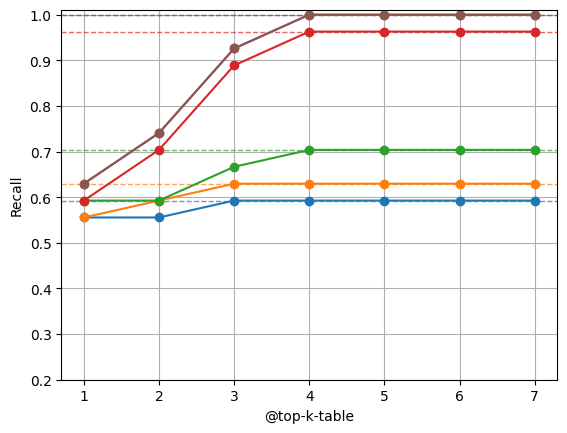

tpch_sf1__oc_oracle


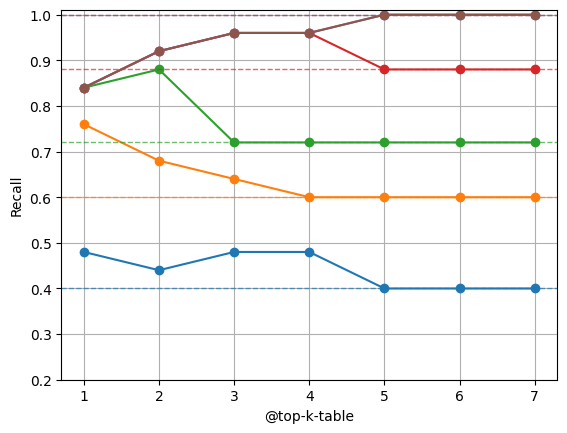

sakila__oc_oracle


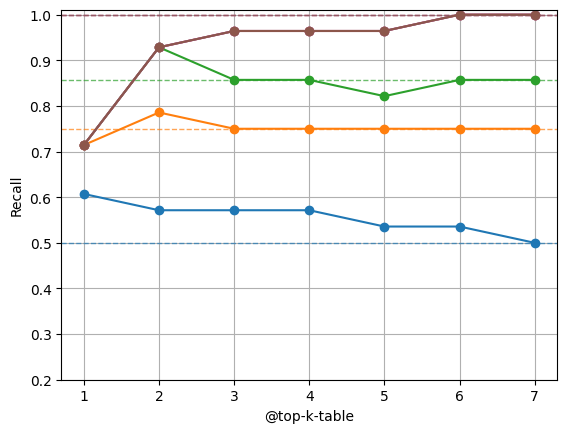

oc_oracle__oc_mysql


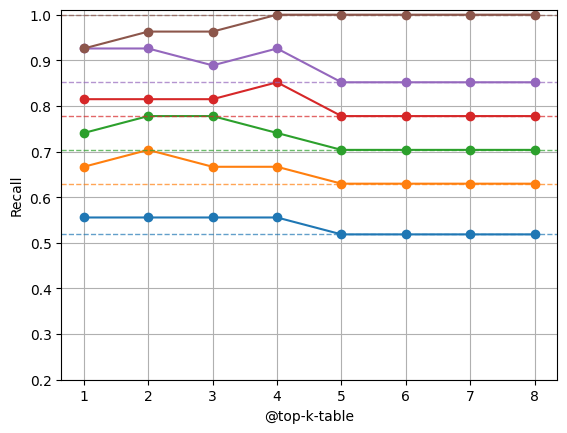

tpch_sf1__oc_mysql


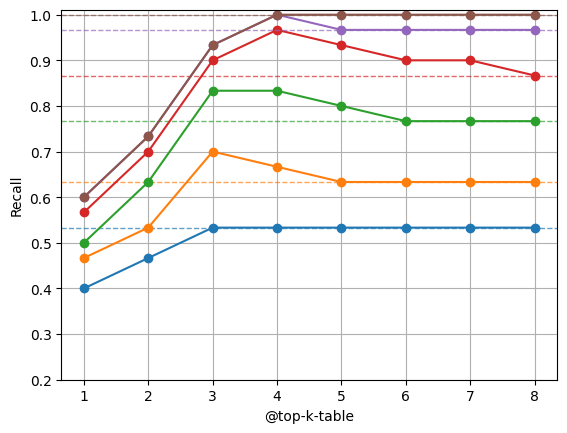

sakila__oc_mysql


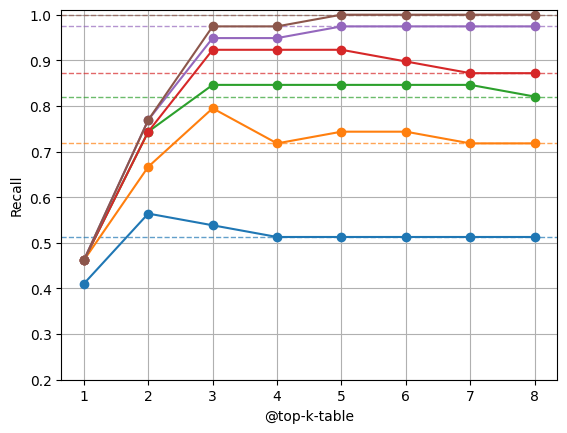

oc_oracle__tpch_sf1


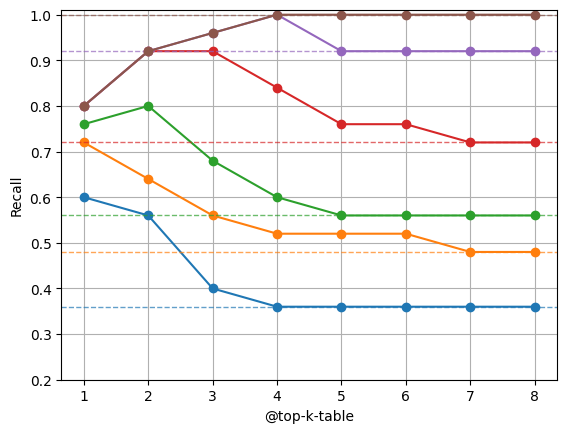

oc_mysql__tpch_sf1


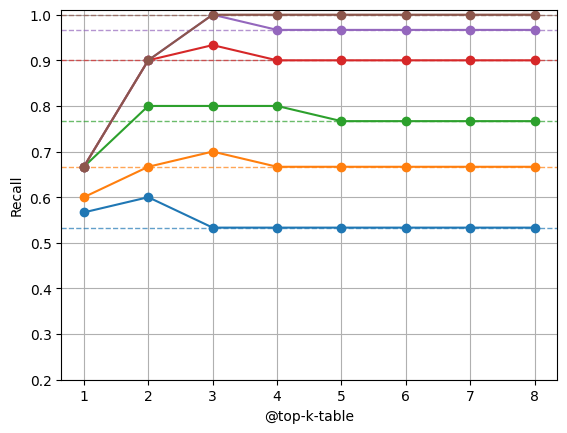

sakila__tpch_sf1


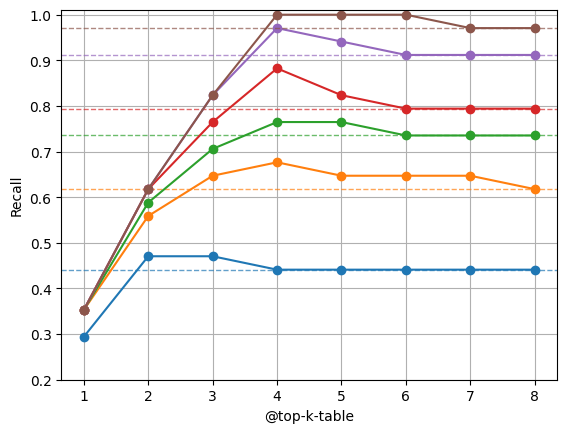

oc_oracle__sakila


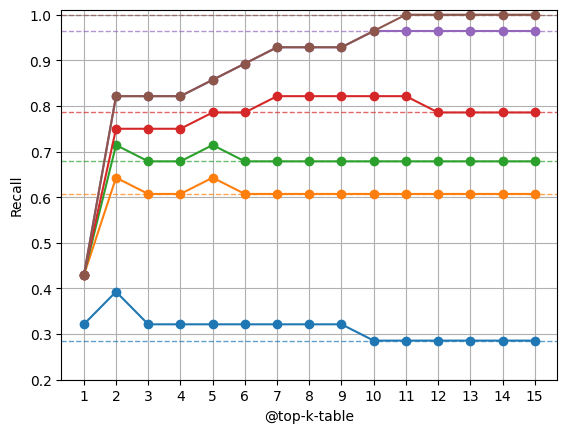

oc_mysql__sakila


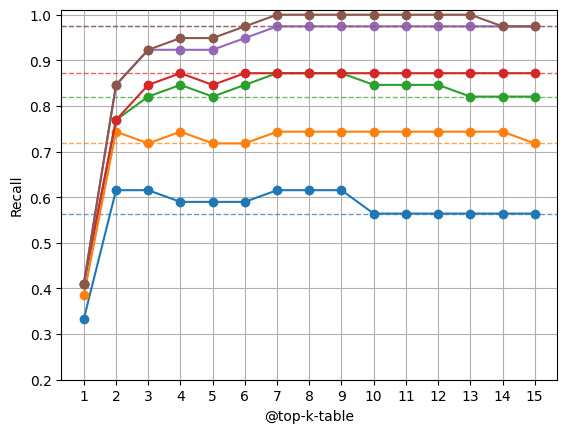

tpch_sf1__sakila


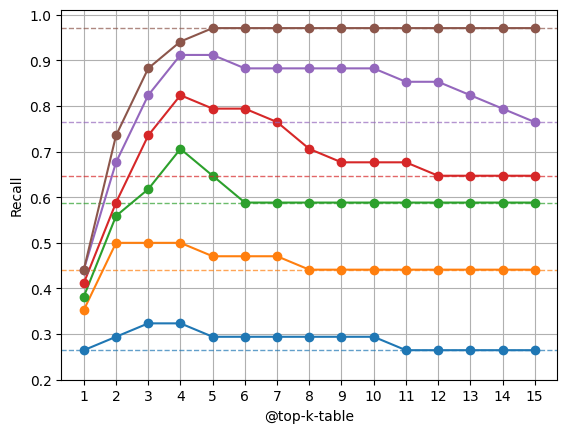

In [310]:
for i in np.arange(len(list_entities_a_exCHP)):
    df_tmp = evaluate_summary(list_entities_a_exCHP[i], list_entities_b_exCHP[i], table_predicts[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    # plot_performance_by_table_k(df_tmp, top_ks, title=gt_keys[i], metric='recall', legend=False)
    print(gt_keys[i])
    plot_performance_by_table_k(df_tmp, top_ks, title=None, metric='recall', legend=False)

oc_mysql__oc_oracle


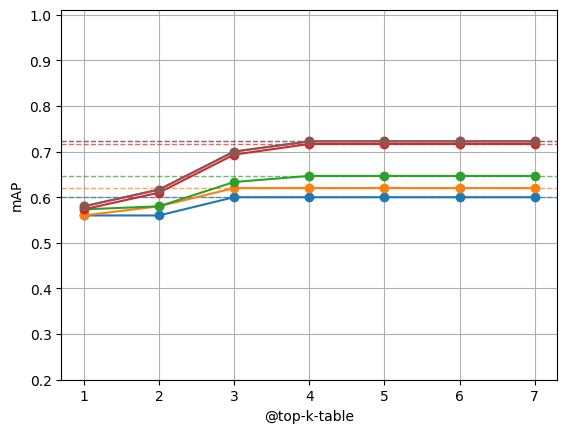

tpch_sf1__oc_oracle


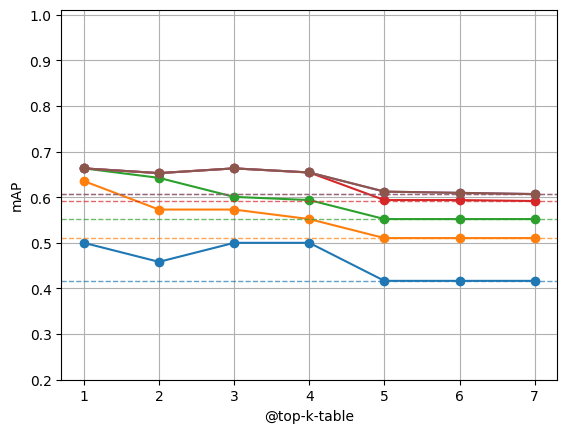

sakila__oc_oracle


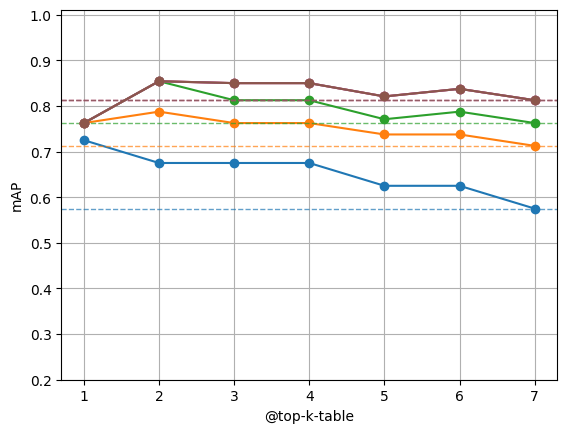

oc_oracle__oc_mysql


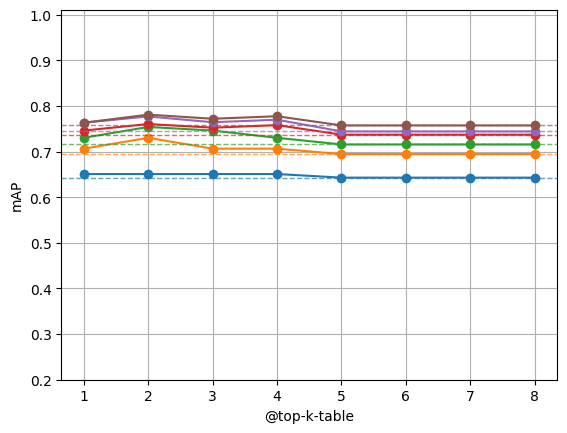

tpch_sf1__oc_mysql


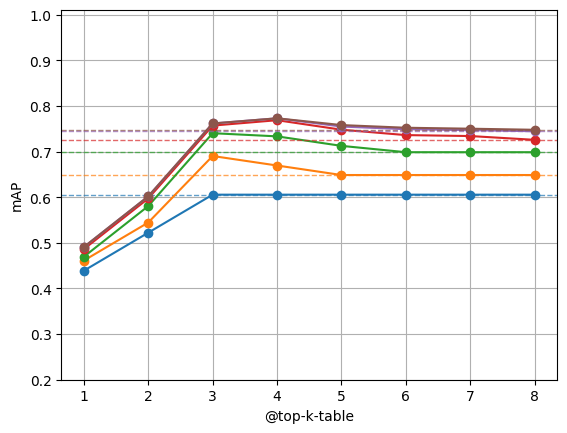

sakila__oc_mysql


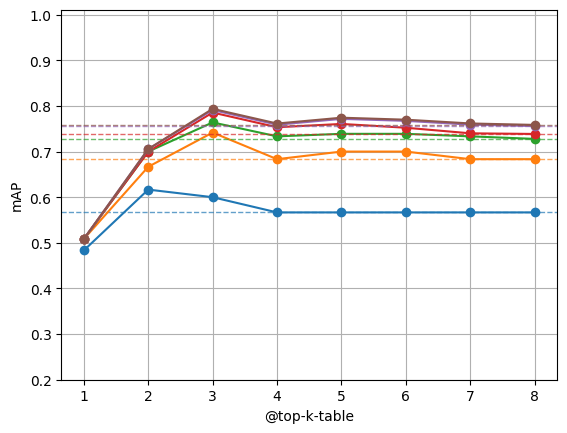

oc_oracle__tpch_sf1


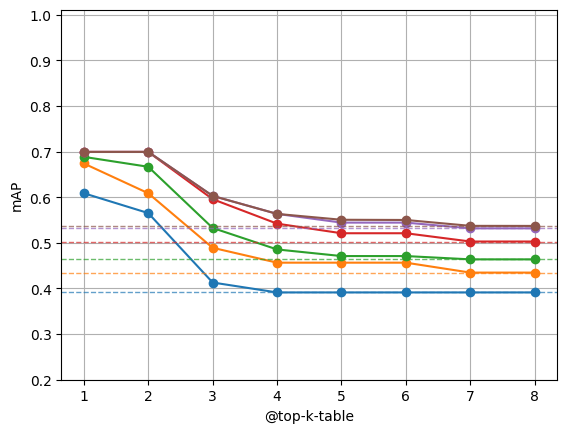

oc_mysql__tpch_sf1


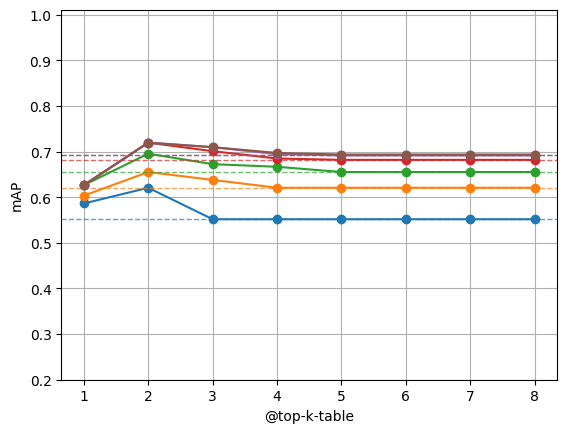

sakila__tpch_sf1


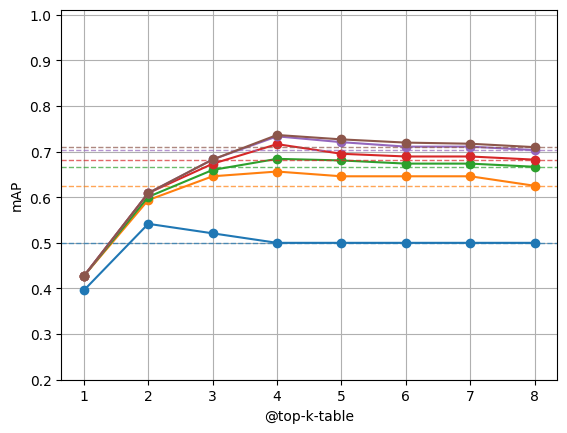

oc_oracle__sakila


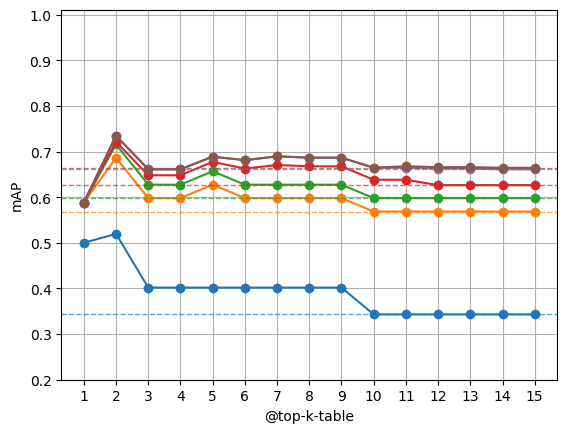

oc_mysql__sakila


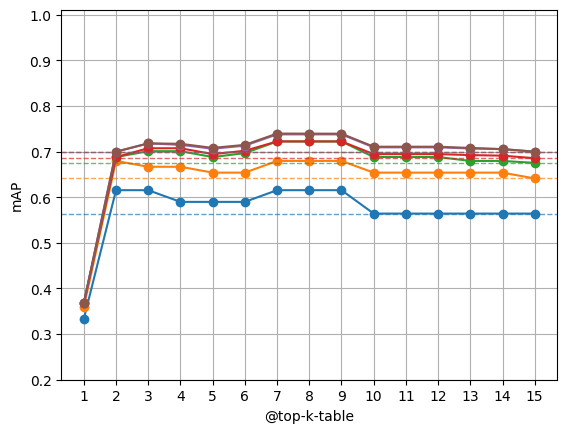

tpch_sf1__sakila


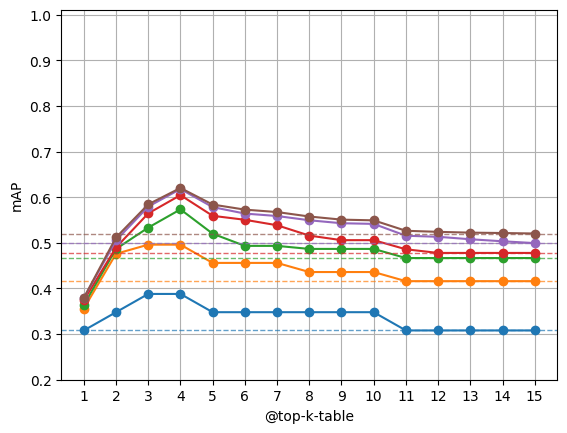

In [311]:
for i in np.arange(len(list_entities_a_exCHP)):
    df_tmp = evaluate_summary(list_entities_a_exCHP[i], list_entities_b_exCHP[i], table_predicts[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    # plot_performance_by_table_k(df_tmp, top_ks, title=gt_keys[i], metric='recall', legend=False)
    print(gt_keys[i])
    plot_performance_by_table_k(df_tmp, top_ks, title=None, metric='map', legend=False)

# 3. Impact Study: Serialization for Blocking and Matching

In [ ]:
vserialization=["column_vsequence", "parent_vsequence", "dtype_vsequence", "constraint_vsequence", "instance_vsequence", "childrens_vsequence", "parents_vsequence"]

vserialization_exCHP =["column_vsequence", "parent_vsequence", "dtype_vsequence", "constraint_vsequence", "instance_vsequence"]

vserialization_exICHP=["column_vsequence", "parent_vsequence", "dtype_vsequence", "constraint_vsequence"]

vserialization_magneto=["column_vsequence", "dtype_vsequence", "constraint_vsequence", "instance_vsequence"]

In [60]:
entities_ocoracle_ser = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_ORACLE")], serialization=vserialization, concat="serialization", verbose=True)

entities_ocmysql_ser = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_MYSQL")], serialization=vserialization, concat="serialization", verbose=True)

entities_tpch_ser = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="TPCH_SF1")], serialization=vserialization, concat="serialization", verbose=True)

entities_sakila_ser = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="SAKILA")], serialization=vserialization, concat="serialization", verbose=True)

[CLS] Column: EMAIL_ADDRESS [SEP] Table: CUSTOMERS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {dania.grizzard@internalmail, adan.lamica@internalmail, frank.perez@internalmail, margaret.bennett@internalmail, james.smith@internalmail} [SEP] Weak Tables: ORDERS SHIPMENTS [SEP] Strong Tables: None
{'entity_44': 0, 'entity_48': 1, 'entity_53': 2, 'entity_60': 3, 'entity_66': 4, 'entity_76': 5, 'entity_82': 6}
[CLS] Column: CUSTOMERNAME [SEP] Table: CUSTOMERS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {L'ordine Souveniers, Online Mini Collectables, Gift Depot Inc., Warburg Exchange, NatÃ¯Â¿Â½rlich Autos} [SEP] Weak Tables: ORDERS PAYMENTS [SEP] Strong Tables: EMPLOYEES
{'entity_95': 0, 'entity_109': 1, 'entity_118': 2, 'entity_128': 3, 'entity_134': 4, 'entity_142': 5, 'entity_147': 6, 'entity_152': 7}
[CLS] Column: C_NAME [SEP] Table: CUSTOMER [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {Customer#000000004, Customer#000000005, Customer#000000006, 

In [61]:
entities_ocoracle_ser_exCHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_ORACLE")], serialization=vserialization_exCHP, concat="serialization", verbose=True)

entities_ocmysql_ser_exCHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_MYSQL")], serialization=vserialization_exCHP, concat="serialization", verbose=True)

entities_tpch_ser_exCHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="TPCH_SF1")], serialization=vserialization_exCHP, concat="serialization", verbose=True)

entities_sakila_ser_exCHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="SAKILA")], serialization=vserialization_exCHP, concat="serialization", verbose=True)

[CLS] Column: EMAIL_ADDRESS [SEP] Table: CUSTOMERS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {dania.grizzard@internalmail, adan.lamica@internalmail, frank.perez@internalmail, margaret.bennett@internalmail, james.smith@internalmail}
{'entity_44': 0, 'entity_48': 1, 'entity_53': 2, 'entity_60': 3, 'entity_66': 4, 'entity_76': 5, 'entity_82': 6}
[CLS] Column: CUSTOMERNAME [SEP] Table: CUSTOMERS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {L'ordine Souveniers, Online Mini Collectables, Gift Depot Inc., Warburg Exchange, NatÃ¯Â¿Â½rlich Autos}
{'entity_95': 0, 'entity_109': 1, 'entity_118': 2, 'entity_128': 3, 'entity_134': 4, 'entity_142': 5, 'entity_147': 6, 'entity_152': 7}
[CLS] Column: C_NAME [SEP] Table: CUSTOMER [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {Customer#000000004, Customer#000000005, Customer#000000006, Customer#000000007, Customer#000000008}
{'entity_207': 0, 'entity_216': 1, 'entity_233': 2, 'entity_238': 3, 'entity_248': 4, 'e

In [95]:
entities_ocoracle_ser_exICHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_ORACLE")], serialization=vserialization_exICHP, concat="serialization", verbose=True)

entities_ocmysql_ser_exICHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_MYSQL")], serialization=vserialization_exICHP, concat="serialization", verbose=True)

entities_tpch_ser_exICHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="TPCH_SF1")], serialization=vserialization_exICHP, concat="serialization", verbose=True)

entities_sakila_ser_exICHP = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="SAKILA")], serialization=vserialization_exICHP, concat="serialization", verbose=True)

[CLS] Column: EMAIL_ADDRESS [SEP] Table: CUSTOMERS [SEP] Type: VARCHAR2 [SEP] Constraint: None
{'entity_44': 0, 'entity_48': 1, 'entity_53': 2, 'entity_60': 3, 'entity_66': 4, 'entity_76': 5, 'entity_82': 6}
[CLS] Column: CUSTOMERNAME [SEP] Table: CUSTOMERS [SEP] Type: VARCHAR2 [SEP] Constraint: None
{'entity_95': 0, 'entity_109': 1, 'entity_118': 2, 'entity_128': 3, 'entity_134': 4, 'entity_142': 5, 'entity_147': 6, 'entity_152': 7}
[CLS] Column: C_NAME [SEP] Table: CUSTOMER [SEP] Type: VARCHAR2 [SEP] Constraint: None
{'entity_207': 0, 'entity_216': 1, 'entity_233': 2, 'entity_238': 3, 'entity_248': 4, 'entity_258': 5, 'entity_264': 6, 'entity_268': 7}
[CLS] Column: FIRST_NAME [SEP] Table: ACTOR [SEP] Type: VARCHAR2 [SEP] Constraint: None
{'entity_277': 0, 'entity_281': 1, 'entity_289': 2, 'entity_292': 3, 'entity_296': 4, 'entity_299': 5, 'entity_308': 6, 'entity_321': 7, 'entity_324': 8, 'entity_327': 9, 'entity_331': 10, 'entity_334': 11, 'entity_341': 12, 'entity_348': 13, 'entity

In [58]:
entities_ocoracle_ser_magneto = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_ORACLE")], serialization=vserialization_magneto, concat="serialization", verbose=True)

entities_ocmysql_ser_magneto = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="OC_MYSQL")], serialization=vserialization_magneto, concat="serialization", verbose=True)

entities_tpch_ser_magneto = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="TPCH_SF1")], serialization=vserialization_magneto, concat="serialization", verbose=True)

entities_sakila_ser_magneto = get_entities_from_df(df_OC3HR[(df_OC3HR.type=="column") & (df_OC3HR.schema=="SAKILA")], serialization=vserialization_magneto, concat="serialization", verbose=True)

[CLS] Column: EMAIL_ADDRESS [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {dania.grizzard@internalmail, adan.lamica@internalmail, frank.perez@internalmail, margaret.bennett@internalmail, james.smith@internalmail}
{'entity_44': 0, 'entity_48': 1, 'entity_53': 2, 'entity_60': 3, 'entity_66': 4, 'entity_76': 5, 'entity_82': 6}
[CLS] Column: CUSTOMERNAME [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {L'ordine Souveniers, Online Mini Collectables, Gift Depot Inc., Warburg Exchange, NatÃ¯Â¿Â½rlich Autos}
{'entity_95': 0, 'entity_109': 1, 'entity_118': 2, 'entity_128': 3, 'entity_134': 4, 'entity_142': 5, 'entity_147': 6, 'entity_152': 7}
[CLS] Column: C_NAME [SEP] Type: VARCHAR2 [SEP] Constraint: None [SEP] Values: {Customer#000000004, Customer#000000005, Customer#000000006, Customer#000000007, Customer#000000008}
{'entity_207': 0, 'entity_216': 1, 'entity_233': 2, 'entity_238': 3, 'entity_248': 4, 'entity_258': 5, 'entity_264': 6, 'entity_268': 7}
[CLS] Column: FIRST

In [64]:
top_ks = [1, 2, 3, 5, 10, 20]

gt_keys = ['oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'sakila__oc_oracle', 
           'oc_oracle__oc_mysql', 'tpch_sf1__oc_mysql', 'sakila__oc_mysql',
           'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'sakila__tpch_sf1',
           'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila']

list_entities_a_magneto = [entities_ocmysql_ser_magneto, entities_tpch_ser_magneto, entities_sakila_ser_magneto,
                         entities_ocoracle_ser_magneto, entities_tpch_ser_magneto, entities_sakila_ser_magneto,
                         entities_ocoracle_ser_magneto, entities_ocmysql_ser_magneto, entities_sakila_ser_magneto,
                         entities_ocoracle_ser_magneto, entities_ocmysql_ser_magneto, entities_tpch_ser_magneto]
list_entities_b_magneto = [entities_ocoracle_ser_magneto, entities_ocoracle_ser_magneto, entities_ocoracle_ser_magneto,
                         entities_ocmysql_ser_magneto, entities_ocmysql_ser_magneto, entities_ocmysql_ser_magneto,
                         entities_tpch_ser_magneto, entities_tpch_ser_magneto, entities_tpch_ser_magneto,
                         entities_sakila_ser_magneto, entities_sakila_ser_magneto, entities_sakila_ser_magneto]

list_entities_a = [entities_ocmysql_ser, entities_tpch_ser, entities_sakila_ser,
                   entities_ocoracle_ser, entities_tpch_ser, entities_sakila_ser,
                   entities_ocoracle_ser, entities_ocmysql_ser, entities_sakila_ser,
                   entities_ocoracle_ser, entities_ocmysql_ser, entities_tpch_ser]
list_entities_b = [entities_ocoracle_ser, entities_ocoracle_ser, entities_ocoracle_ser,
                   entities_ocmysql_ser, entities_ocmysql_ser, entities_ocmysql_ser,
                   entities_tpch_ser, entities_tpch_ser, entities_tpch_ser,
                   entities_sakila_ser, entities_sakila_ser, entities_sakila_ser]

list_entities_a_exCHP = [entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_tpch_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_sakila_ser_exCHP,
                         entities_ocoracle_ser_exCHP, entities_ocmysql_ser_exCHP, entities_tpch_ser_exCHP]
list_entities_b_exCHP = [entities_ocoracle_ser_exCHP, entities_ocoracle_ser_exCHP, entities_ocoracle_ser_exCHP,
                         entities_ocmysql_ser_exCHP, entities_ocmysql_ser_exCHP, entities_ocmysql_ser_exCHP,
                         entities_tpch_ser_exCHP, entities_tpch_ser_exCHP, entities_tpch_ser_exCHP,
                         entities_sakila_ser_exCHP, entities_sakila_ser_exCHP, entities_sakila_ser_exCHP]

list_entities_a_exICHP = [entities_ocmysql_ser_exICHP, entities_tpch_ser_exICHP, entities_sakila_ser_exICHP,
                         entities_ocoracle_ser_exICHP, entities_tpch_ser_exICHP, entities_sakila_ser_exICHP,
                         entities_ocoracle_ser_exICHP, entities_ocmysql_ser_exICHP, entities_sakila_ser_exICHP,
                         entities_ocoracle_ser_exICHP, entities_ocmysql_ser_exICHP, entities_tpch_ser_exICHP]
list_entities_b_exICHP = [entities_ocoracle_ser_exICHP, entities_ocoracle_ser_exICHP, entities_ocoracle_ser_exICHP,
                         entities_ocmysql_ser_exICHP, entities_ocmysql_ser_exICHP, entities_ocmysql_ser_exICHP,
                         entities_tpch_ser_exICHP, entities_tpch_ser_exICHP, entities_tpch_ser_exICHP,
                         entities_sakila_ser_exICHP, entities_sakila_ser_exICHP, entities_sakila_ser_exICHP]

### Recall

oc_mysql__oc_oracle


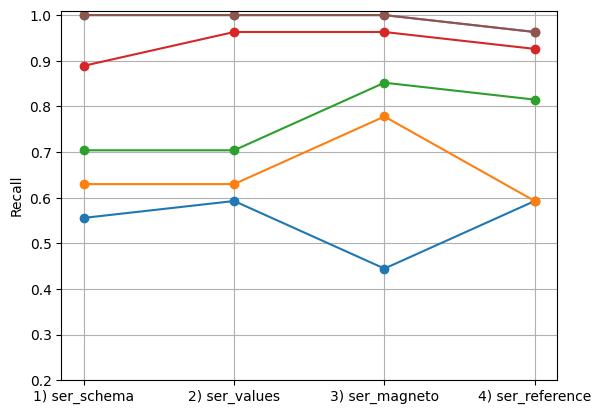

C:\Users\leona\AppData\Local\Temp\ipykernel_55520\2738521835.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_serialization_comparison = pd.concat([df_serialization_comparison, df_tmp], ignore_index=True)


tpch_sf1__oc_oracle


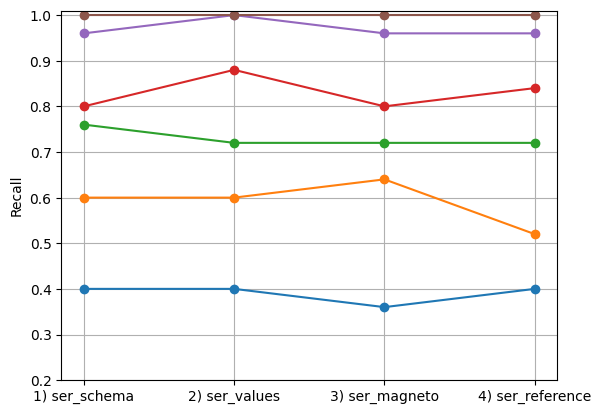

sakila__oc_oracle


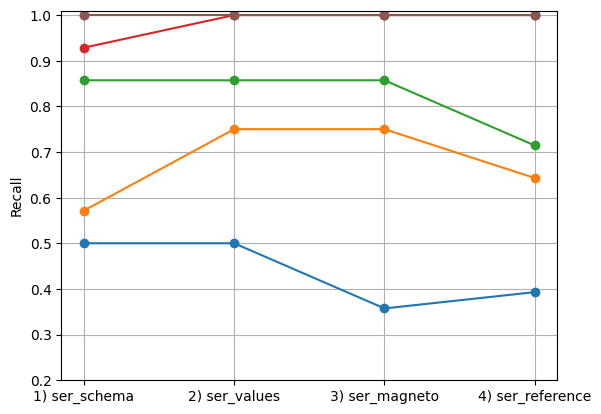

oc_oracle__oc_mysql


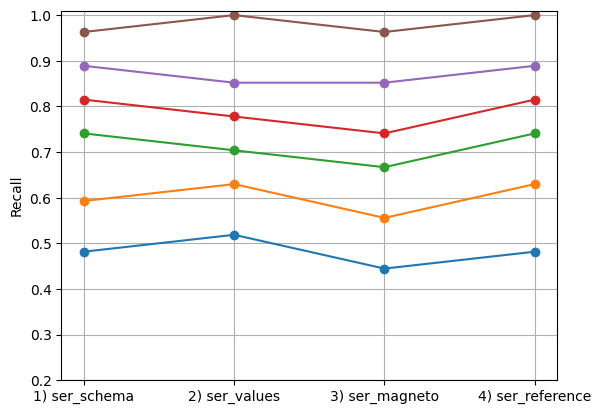

tpch_sf1__oc_mysql


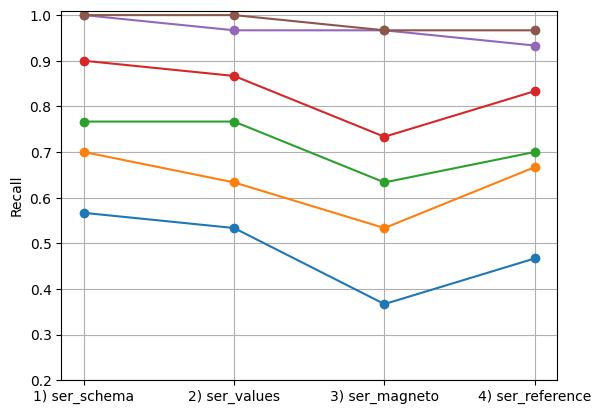

sakila__oc_mysql


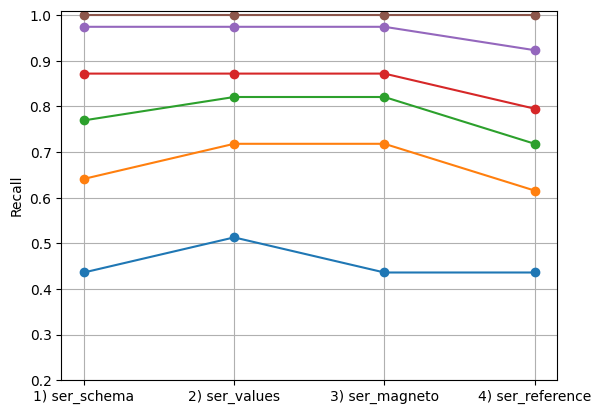

oc_oracle__tpch_sf1


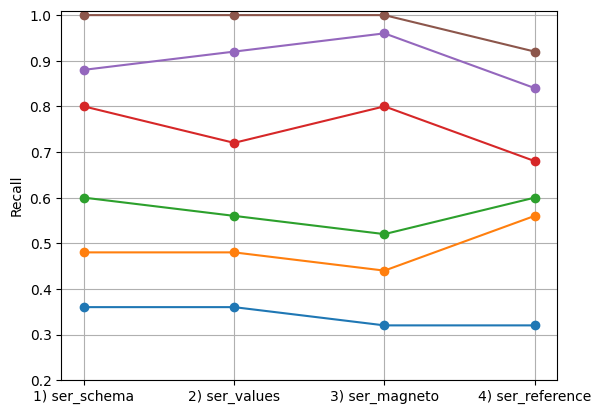

oc_mysql__tpch_sf1


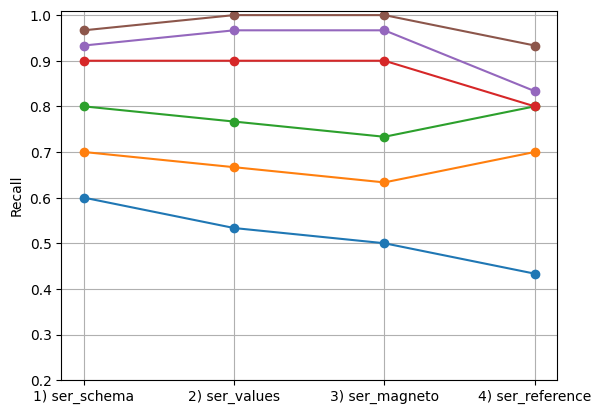

sakila__tpch_sf1


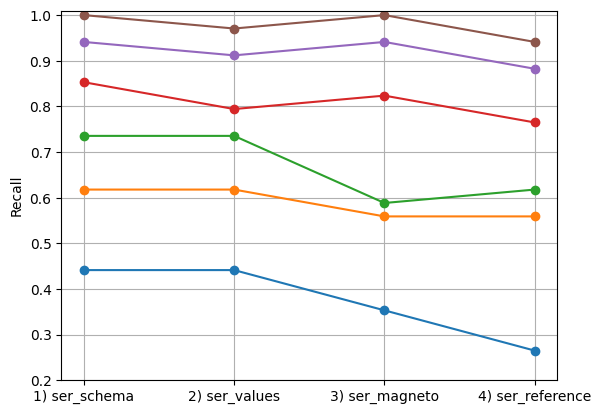

oc_oracle__sakila


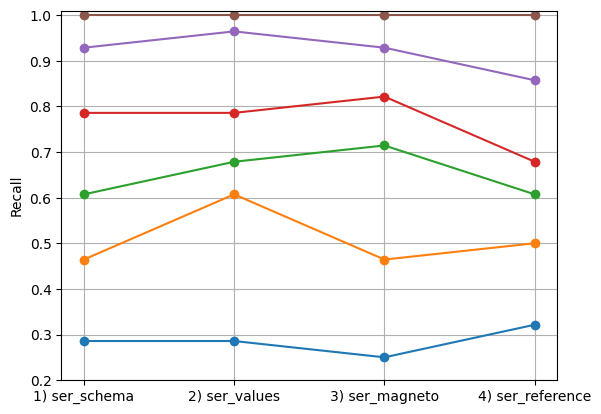

oc_mysql__sakila


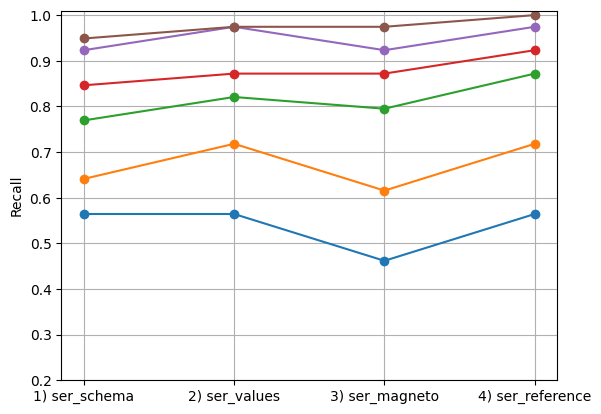

tpch_sf1__sakila


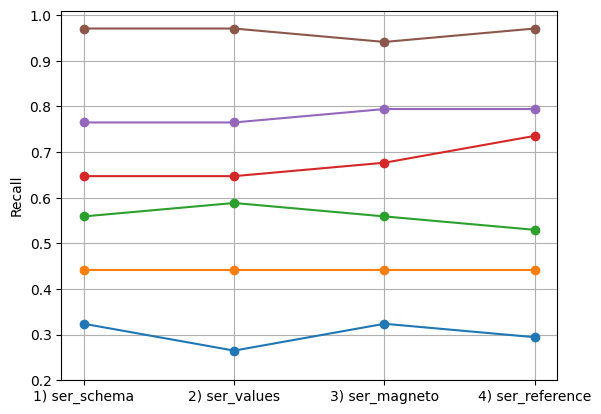

In [96]:
df_serialization_comparison = pd.DataFrame(data=None, columns=["method", "schema_A", "schema_B", "top_k_table", "top_k", "matches", "recall", "mrr", "map"])

for i in np.arange(len(list_entities_a)):
    df_tmp_exICHP = evaluate_summary_baseline(list_entities_a_exICHP[i], list_entities_b_exICHP[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    df_tmp_exICHP.top_k_table = "1) ser_schema"
    df_tmp_default = evaluate_summary_baseline(list_entities_a_exCHP[i], list_entities_b_exCHP[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    df_tmp_default.top_k_table = "2) ser_values"
    df_tmp_magneto = evaluate_summary_baseline(list_entities_a_magneto[i], list_entities_b_magneto[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    df_tmp_magneto.top_k_table = "3) ser_magneto"
    df_tmp_strongweak = evaluate_summary_baseline(list_entities_a[i], list_entities_b[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    df_tmp_strongweak.top_k_table = "4) ser_reference"
    df_tmp = pd.concat([df_tmp_magneto, df_tmp_exICHP, df_tmp_default, df_tmp_strongweak], ignore_index=True)
    print(gt_keys[i])
    plot_performance_by_table_k(df_tmp, top_ks, title=None, metric='recall', xlabel=None, legend=False, horizontal_baseline=False)
    df_serialization_comparison = pd.concat([df_serialization_comparison, df_tmp], ignore_index=True)

In [97]:
df_serialization_comparison.to_csv("C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_serialization/df_serialization_comparison.csv", index=False)
df_serialization_comparison.head(30)

method  schema_A   schema_B       top_k_table top_k matches    recall  \
0     LSH  OC_MYSQL  OC_ORACLE    3) ser_magneto     1      59  0.444444   
1     LSH  OC_MYSQL  OC_ORACLE    3) ser_magneto     2     118  0.777778   
2     LSH  OC_MYSQL  OC_ORACLE    3) ser_magneto     3     177  0.851852   
3     LSH  OC_MYSQL  OC_ORACLE    3) ser_magneto     5     295  0.962963   
4     LSH  OC_MYSQL  OC_ORACLE    3) ser_magneto    10     590  1.000000   
5     LSH  OC_MYSQL  OC_ORACLE    3) ser_magneto    20    1180  1.000000   
6     LSH  OC_MYSQL  OC_ORACLE     1) ser_schema     1      59  0.555556   
7     LSH  OC_MYSQL  OC_ORACLE     1) ser_schema     2     118  0.629630   
8     LSH  OC_MYSQL  OC_ORACLE     1) ser_schema     3     177  0.703704   
9     LSH  OC_MYSQL  OC_ORACLE     1) ser_schema     5     295  0.888889   
10    LSH  OC_MYSQL  OC_ORACLE     1) ser_schema    10     590  1.000000   
11    LSH  OC_MYSQL  OC_ORACLE     1) ser_schema    20    1180  1.000000   
12    LSH  OC_MYSQL  OC_ORACLE     2) ser_values     1      59  0.592593   
13    LSH  OC_MYSQL  OC_ORACLE     2) ser_values     2     118  0.629630   
14    LSH  OC_MYSQL  OC_ORACLE     2) ser_values     3     177  0.703704   
15    LSH  OC_MYSQL  OC_ORACLE     2) ser_values     5     295  0.962963   
16    LSH  OC_MYSQL  OC_ORACLE     2) ser_values    10     590  1.000000   
17    LSH  OC_MYSQL  OC_ORACLE     2) ser_values    20    1180  1.000000   
18    LSH  OC_MYSQL  OC_ORACLE  4) ser_reference     1      59  0.592593   
19    LSH  OC_MYSQL  OC_ORACLE  4) ser_reference     2     118  0.592593   
20    LSH  OC_MYSQL  OC_ORACLE  4) ser_reference     3     177  0.814815   
21    LSH  OC_MYSQL  OC_ORACLE  4) ser_reference     5     295  0.925926   
22    LSH  OC_MYSQL  OC_ORACLE  4) ser_reference    10     590  0.962963   
23    LSH  OC_MYSQL  OC_ORACLE  4) ser_reference    20    1180  0.962963   
24    LSH  TPCH_SF1  OC_ORACLE    3) ser_magneto     1      61  0.360000   
25    LSH  TPCH_SF1  OC_ORACLE    3) ser_magneto     2     122  0.640000   
26    LSH  TPCH_SF1  OC_ORACLE    3) ser_magneto     3     183  0.720000   
27    LSH  TPCH_SF1  OC_ORACLE    3) ser_magneto     5     305  0.800000   
28    LSH  TPCH_SF1  OC_ORACLE    3) ser_magneto    10     610  0.960000   
29    LSH  TPCH_SF1  OC_ORACLE    3) ser_magneto    20    1220  1.000000   

         mrr       map  
0   0.089596  0.440000  
1   0.073189  0.620000  
2   0.067015  0.646667  
3   0.059571  0.670667  
4   0.057193  0.675111  
5   0.057149  0.675111  
6   0.200413  0.560000  
7   0.176732  0.600000  
8   0.159200  0.626667  
9   0.127550  0.674667  
10  0.113754  0.692444  
11  0.113748  0.692444  
12  0.184170  0.600000  
13  0.159705  0.620000  
14  0.143592  0.646667  
15  0.106781  0.716667  
16  0.102732  0.722381  
17  0.102694  0.722381  
18  0.186699  0.600000  
19  0.176590  0.600000  
20  0.132454  0.680000  
21  0.116537  0.706000  
22  0.111915  0.711000  
23  0.111877  0.711000  
24  0.091183  0.375000  
25  0.094826  0.520833  
26  0.084098  0.541667  
27  0.075653  0.560417  
28  0.063484  0.582738  
29  0.061144  0.586210

In [98]:
df_serialization_comparison_recall_meanstd = df_serialization_comparison.groupby(["top_k_table", "top_k"])['recall'].agg(['mean', 'std']).reset_index()  
df_serialization_comparison_recall_meanstd

top_k_table  top_k      mean       std
0      1) ser_schema      1  0.459510  0.102930
1      1) ser_schema      2  0.589901  0.086469
2      1) ser_schema      3  0.722331  0.089347
3      1) ser_schema      5  0.836328  0.075376
4      1) ser_schema     10  0.932843  0.066857
5      1) ser_schema     20  0.987411  0.019250
6      2) ser_values      1  0.458858  0.108478
7      2) ser_values      2  0.624260  0.090734
8      2) ser_values      3  0.726751  0.089578
9      2) ser_values      5  0.839824  0.099637
10     2) ser_values     10  0.941222  0.070615
11     2) ser_values     20  0.992961  0.012767
12    3) ser_magneto      1  0.384717  0.072447
13    3) ser_magneto      2  0.593968  0.115949
14    3) ser_magneto      3  0.704921  0.114049
15    3) ser_magneto      5  0.833505  0.094207
16    3) ser_magneto     10  0.938874  0.060346
17    3) ser_magneto     20  0.987097  0.020455
18  4) ser_reference      1  0.413932  0.103272
19  4) ser_reference      2  0.595423  0.083138
20  4) ser_reference      3  0.702816  0.099860
21  4) ser_reference      5  0.815883  0.097939
22  4) ser_reference     10  0.904131  0.064709
23  4) ser_reference     20  0.974561  0.029980

In [99]:
df_serialization_comparison_map_meanstd = df_serialization_comparison.groupby(["top_k_table", "top_k"])['map'].agg(['mean', 'std']).reset_index()  
df_serialization_comparison_map_meanstd

top_k_table  top_k      mean       std
0      1) ser_schema      1  0.501391  0.107694
1      1) ser_schema      2  0.574214  0.099850
2      1) ser_schema      3  0.623311  0.098663
3      1) ser_schema      5  0.654097  0.092841
4      1) ser_schema     10  0.669893  0.089478
5      1) ser_schema     20  0.675162  0.084847
6      2) ser_values      1  0.505418  0.112120
7      2) ser_values      2  0.597953  0.097296
8      2) ser_values      3  0.635731  0.097450
9      2) ser_values      5  0.664923  0.099031
10     2) ser_values     10  0.681107  0.092807
11     2) ser_values     20  0.685852  0.089745
12    3) ser_magneto      1  0.418960  0.078256
13    3) ser_magneto      2  0.534840  0.084827
14    3) ser_magneto      3  0.575599  0.083079
15    3) ser_magneto      5  0.610275  0.075539
16    3) ser_magneto     10  0.624881  0.070092
17    3) ser_magneto     20  0.632601  0.067036
18  4) ser_reference      1  0.447196  0.104088
19  4) ser_reference      2  0.548568  0.083580
20  4) ser_reference      3  0.589831  0.087214
21  4) ser_reference      5  0.619207  0.085105
22  4) ser_reference     10  0.633201  0.080948
23  4) ser_reference     20  0.639755  0.078291

In [102]:
def plot_mean_performance_serialization(df_serialization_comparison, aggr="Recall", legend=True):
    plt.figure(figsize=(6, 2.5))

    methods = df_serialization_comparison['top_k_table'].unique()
    unique_top_k = sorted(df_serialization_comparison['top_k'].unique())
    
    # 1. Create categorical positions (0, 1, 2, 3...)
    x_indices = np.arange(len(unique_top_k))
    
    colors = ["#00FFFF", "#0000FF", "#31CE5E", "#BF0040"] 
    markers = ['o', 's','x', '^']
    
    # Define how far apart the points should be
    width = 0.15 
    n_methods = len(methods)

    for i, method in enumerate(methods):
        subset = df_serialization_comparison[df_serialization_comparison['top_k_table'] == method]
        subset = subset.sort_values('top_k') # Ensure data is sorted for line plotting
        
        # 2. Map the actual top_k values to their integer indices
        # This handles cases where some methods might miss a data point
        current_indices = [unique_top_k.index(k) for k in subset['top_k']]
        
        # 3. Calculate offset so they don't overlap
        # Formula centers the group around the tick
        offset = (i - (n_methods - 1) / 2) * width
        x_coords = np.array(current_indices) + offset

        plt.errorbar(x_coords, subset['mean'], yerr=subset['std'], 
                     label=method, color=colors[i % len(colors)], marker=markers[i % len(markers)], 
                     capsize=5, linestyle='-', linewidth=2, markersize=8, alpha=0.6)

    plt.xlabel('@top-k-column')#, fontsize=12)
    plt.ylabel('Mean ' + aggr)#, fontsize=12)
    # plt.title('Mean ' + aggr + ' Performance by Serialization Method', fontsize=14)
    if legend:
        plt.legend(title='Serialization')#, loc="lower center")
    plt.grid(True)#, linestyle='--', alpha=0.6) # Grid often looks better on Y only for this chart
    
    # 4. Set the X-ticks to be the integer indices, but label them with real values
    plt.xticks(x_indices, unique_top_k)
   
    plt.ylim(0.2, 1.01) 
    plt.tight_layout()
    plt.show()

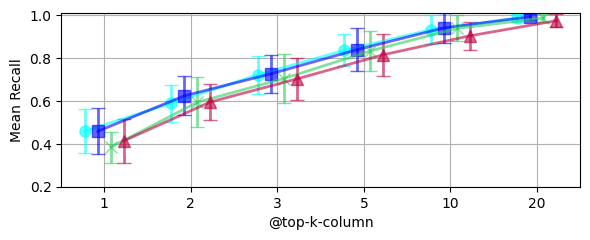

In [105]:
plot_mean_performance_serialization(df_serialization_comparison_recall_meanstd, legend=False)

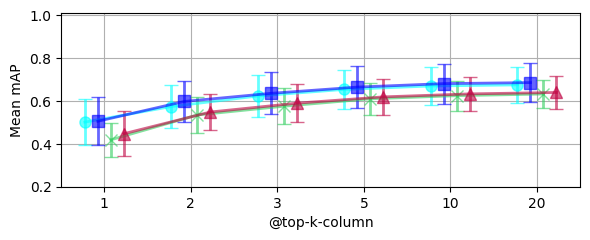

In [106]:
plot_mean_performance_serialization(df_serialization_comparison_map_meanstd, aggr="mAP", legend=False)

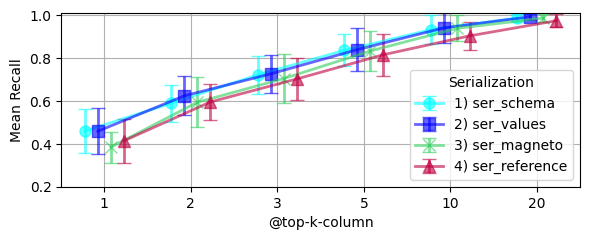

In [107]:
plot_mean_performance_serialization(df_serialization_comparison_recall_meanstd)

### mAP

oc_mysql__oc_oracle


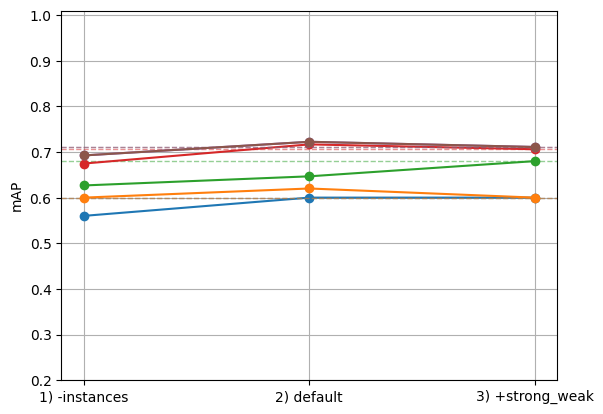

tpch_sf1__oc_oracle


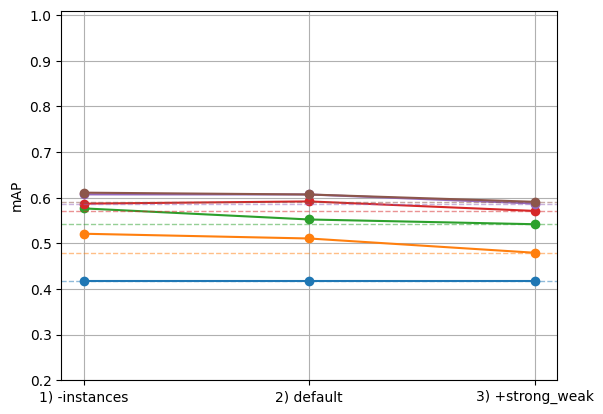

sakila__oc_oracle


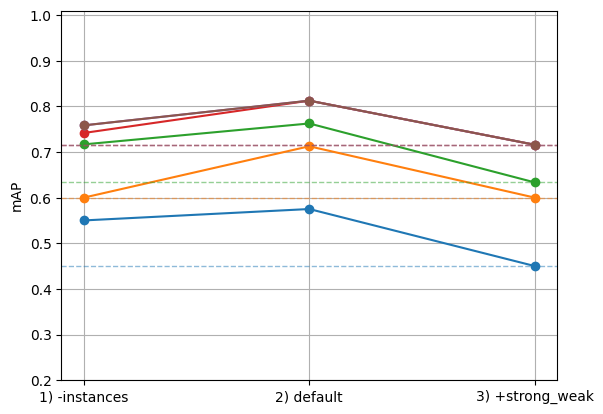

oc_oracle__oc_mysql


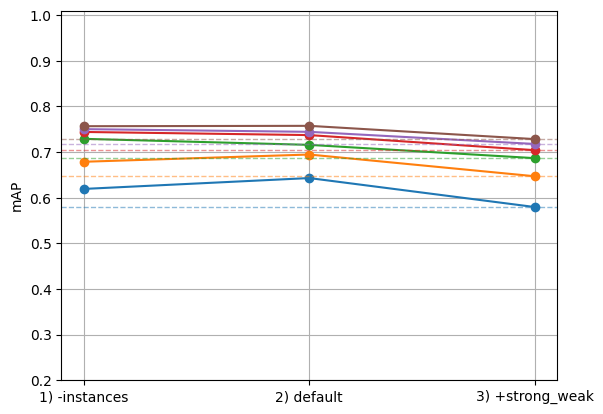

tpch_sf1__oc_mysql


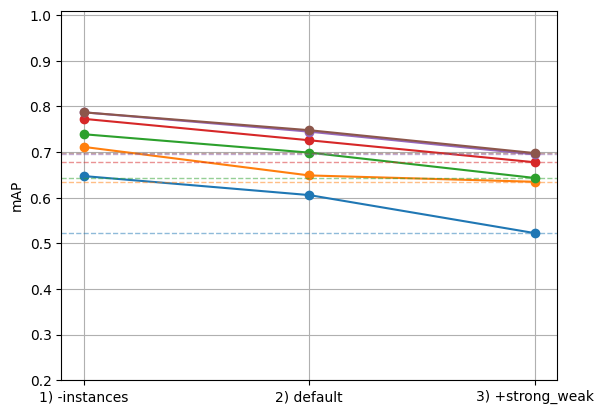

sakila__oc_mysql


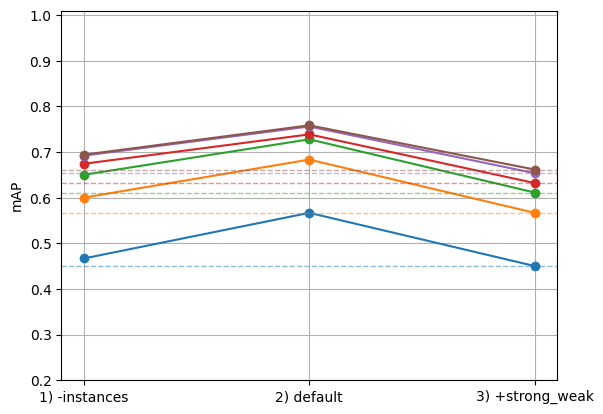

oc_oracle__tpch_sf1


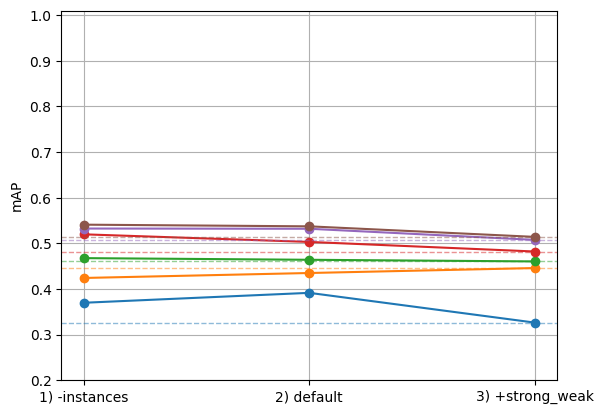

oc_mysql__tpch_sf1


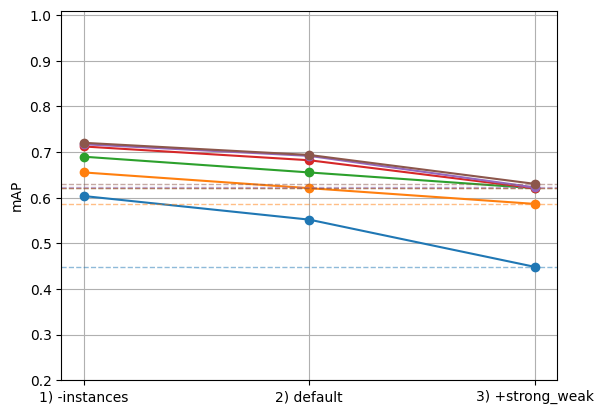

sakila__tpch_sf1


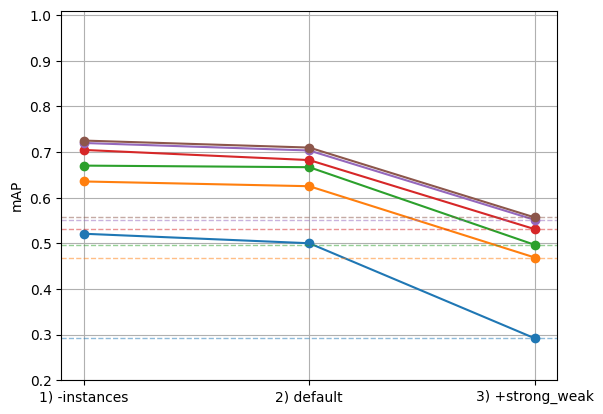

oc_oracle__sakila


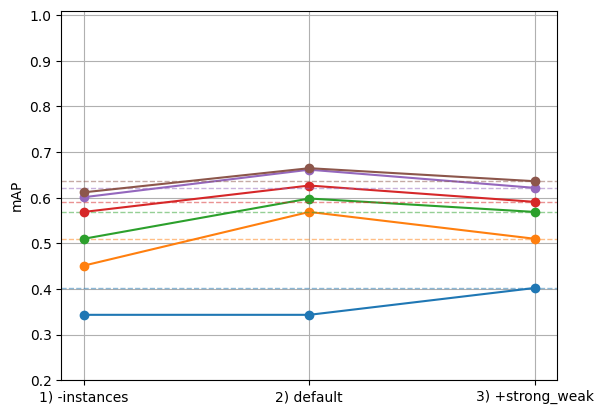

oc_mysql__sakila


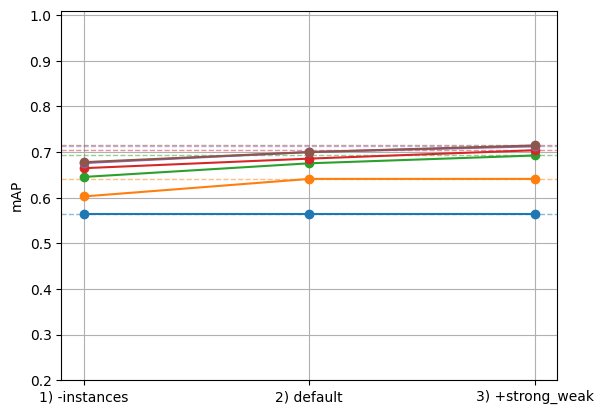

tpch_sf1__sakila


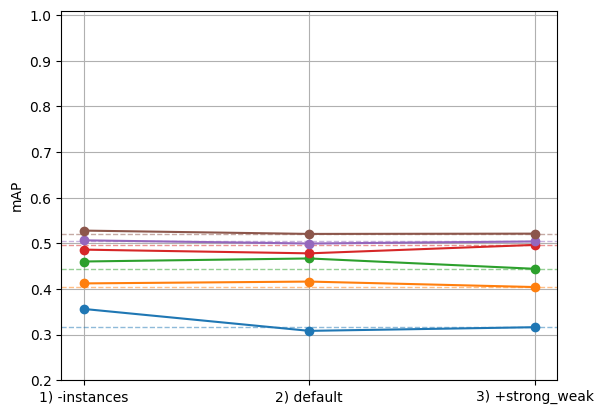

In [152]:
for i in np.arange(len(list_entities_a_exCHP)):
    df_tmp_exICHP = evaluate_summary_baseline(list_entities_a_exICHP[i], list_entities_b_exICHP[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    df_tmp_exICHP.top_k_table = "1) -instances"
    df_tmp_default = evaluate_summary_baseline(list_entities_a_exCHP[i], list_entities_b_exCHP[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    df_tmp_default.top_k_table = "2) default"
    df_tmp_strongweak = evaluate_summary_baseline(list_entities_a[i], list_entities_b[i], gt_TPCHOC2_column_dict[gt_keys[i]], df_OC3HR, top_ks)
    df_tmp_strongweak.top_k_table = "3) +strong_weak"
    df_tmp = pd.concat([df_tmp_exICHP, df_tmp_default, df_tmp_strongweak], ignore_index=True)
    print(gt_keys[i])
    plot_performance_by_table_k(df_tmp, top_ks, title=None, metric='map', xlabel=None, legend=False)

# 4. ReMatch (Baseline)

In [79]:
def get_table_entities_from_df(df_graph, model_name='sentence-transformers/all-mpnet-base-v2', serialization="ReMatch_table"):
    """
    Generates Table Entities with ReMatch serialization and embeddings.
    """
    model = SentenceTransformer(model_name)
    df = df_graph.copy()
    
    # 1. Group columns by their parent_id to efficiently access them per table
    #    This avoids filtering the whole dataframe inside the loop.
    cols_by_table = df[df['type'] == 'column'].groupby('parent_id')

    serialization_texts = []
    processed_rows = []

    # 2. Iterate only through rows that are Tables
    table_rows = df[df['type'] == 'table']

    for index, row in table_rows.iterrows():
        table_id = row['id']
        table_name = row['name']
        
        # Retrieve columns belonging to this table
        if table_id in cols_by_table.groups:
            table_cols = cols_by_table.get_group(table_id)
        else:
            table_cols = pd.DataFrame() # Handle tables with no columns

        # Lists to hold the formatted strings for each category
        pks_list = []
        fks_list = []
        cols_list = []

        for _, col in table_cols.iterrows():
            c_name = str(col['name'])
            c_type = str(col['datatype']) if col['datatype'] else "text"
            constraints = str(col['constraints']) if col['constraints'] else ""
            
            # Categorize based on constraints
            if 'PRIMARY KEY' in constraints:
                # Format: c.name, c.type
                pks_list.append(f"{c_name} {c_type}")
            
            elif 'FOREIGN KEY' in constraints:
                # Format: c.name, c.type, c.ref
                # Extract the reference part. 
                # e.g., "FOREIGN KEY REFERENCES city(city_id)" -> "REFERENCES city(city_id)"
                try:
                    # Split on 'KEY' and take the second part
                    ref = constraints.split('KEY', 1)[1].strip()
                except IndexError:
                    ref = "unknown"
                fks_list.append(f"{c_name} {c_type} {ref}")
            
            else:
                # Regular columns
                # Format: c.name, c.type
                cols_list.append(f"{c_name} {c_type}")

        # 3. Construct the ReMatch Serialization String
        # Formula: [CLS] Table: name [SEP] PKs {..} [SEP] FKs {..} [SEP] Cols {..}
        
        part_table = f"[CLS] Table: {table_name}"
        
        # We join list items with comma-space to simulate the set notation content
        part_pks = f"[SEP] Primary Keys: {{{', '.join(pks_list)}}}"
        part_fks = f"[SEP] Foreign Keys: {{{', '.join(fks_list)}}}"
        part_cols = f"[SEP] Columns: {{{', '.join(cols_list)}}}"

        # Combine parts
        full_sequence = f"{part_table} {part_pks} {part_fks} {part_cols}"
        
        serialization_texts.append(full_sequence)
        processed_rows.append(row)

    # 4. Generate Embeddings in batch (faster than one by one)
    #    If you only need the text, you can comment this out.
    text_sequences = model.encode(serialization_texts, show_progress_bar=True)

    # 5. Create Entity Objects
    table_entities = []
    
    for i, row in enumerate(processed_rows):
        # Create the Entity with the specific text sequence and embedding
        entity = Entity(
            entity_id=row["id"],
            name=row["name"],
            type=row["type"],
            schema=row["schema"],
            parent_id=row["parent_id"],
            text_sequence=text_sequences[i]
        )
        # Assuming you want to attach the embedding to the object dynamically if not in __init__
        entity.serialization = serialization_texts[i]
        print(serialization_texts[i])
        table_entities.append(entity)

    return table_entities

In [80]:
entities_ocoracle_ser_table = get_table_entities_from_df(df_OC3HR[df_OC3HR.schema == "OC_ORACLE"])
entities_ocmysql_ser_table = get_table_entities_from_df(df_OC3HR[df_OC3HR.schema == "OC_MYSQL"])
entities_tpch_ser_table = get_table_entities_from_df(df_OC3HR[df_OC3HR.schema == "TPCH_SF1"])
entities_sakila_ser_table = get_table_entities_from_df(df_OC3HR[df_OC3HR.schema == "SAKILA"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[CLS] Table: CUSTOMERS [SEP] Primary Keys: {CUSTOMER_ID NUMBER} [SEP] Foreign Keys: {} [SEP] Columns: {EMAIL_ADDRESS VARCHAR2, FULL_NAME VARCHAR2}
[CLS] Table: INVENTORY [SEP] Primary Keys: {INVENTORY_ID NUMBER} [SEP] Foreign Keys: {STORE_ID NUMBER REFERENCES stores (store_id), PRODUCT_ID NUMBER REFERENCES products (product_id)} [SEP] Columns: {PRODUCT_INVENTORY NUMBER}
[CLS] Table: ORDER_ITEMS [SEP] Primary Keys: {ORDER_ID NUMBER, LINE_ITEM_ID NUMBER} [SEP] Foreign Keys: {PRODUCT_ID NUMBER REFERENCES products (product_id), SHIPMENT_ID FLOAT REFERENCES shipments (shipment_id)} [SEP] Columns: {UNIT_PRICE FLOAT, QUANTITY NUMBER}
[CLS] Table: ORDERS [SEP] Primary Keys: {ORDER_ID NUMBER} [SEP] Foreign Keys: {CUSTOMER_ID NUMBER REFERENCES customers (customer_id), STORE_ID NUMBER REFERENCES stores (store_id)} [SEP] Columns: {ORDER_DATETIME DATE, ORDER_STATUS VARCHAR2}
[CLS] Table: PRODUCTS [SEP] Primary Keys: {PRODUCT_ID NUMBER} [SEP] Foreign Keys: {} [SEP] Columns: {PRODUCT_NAME VARCHAR2, U

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[CLS] Table: CUSTOMERS [SEP] Primary Keys: {CUSTOMERNUMBER NUMBER} [SEP] Foreign Keys: {SALESREPEMPLOYEENUMBER NUMBER REFERENCES employees(employeeNumber)} [SEP] Columns: {CUSTOMERNAME VARCHAR2, CONTACTLASTNAME VARCHAR2, CONTACTFIRSTNAME VARCHAR2, PHONE VARCHAR2, ADDRESSLINE1 VARCHAR2, ADDRESSLINE2 VARCHAR2, CITY VARCHAR2, STATE VARCHAR2, POSTALCODE VARCHAR2, COUNTRY VARCHAR2, CREDITLIMIT FLOAT}
[CLS] Table: EMPLOYEES [SEP] Primary Keys: {EMPLOYEENUMBER NUMBER} [SEP] Foreign Keys: {OFFICECODE NUMBER REFERENCES offices(officeCode), REPORTSTO NUMBER REFERENCES employees(employeeNumber)} [SEP] Columns: {LASTNAME VARCHAR2, FIRSTNAME VARCHAR2, EXTENSION VARCHAR2, EMAIL VARCHAR2, JOBTITLE VARCHAR2}
[CLS] Table: OFFICES [SEP] Primary Keys: {OFFICECODE NUMBER} [SEP] Foreign Keys: {} [SEP] Columns: {CITY VARCHAR2, PHONE VARCHAR2, ADDRESSLINE1 VARCHAR2, ADDRESSLINE2 VARCHAR2, STATE VARCHAR2, COUNTRY VARCHAR2, POSTALCODE VARCHAR2, TERRITORY VARCHAR2}
[CLS] Table: ORDERDETAILS [SEP] Primary Keys: 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[CLS] Table: CUSTOMER [SEP] Primary Keys: {C_CUSTKEY NUMBER} [SEP] Foreign Keys: {} [SEP] Columns: {C_NAME VARCHAR2, C_ADDRESS VARCHAR2, C_NATIONKEY NUMBER, C_PHONE VARCHAR2, C_ACCTBAL FLOAT, C_MKTSEGMENT VARCHAR2, C_COMMENT VARCHAR2}
[CLS] Table: LINEITEM [SEP] Primary Keys: {L_ORDERKEY NUMBER, L_LINENUMBER NUMBER} [SEP] Foreign Keys: {L_PARTKEY NUMBER REFERENCES partsupp(PS_PARTKEY), L_SUPPKEY NUMBER REFERENCES partsupp(PS_SUPPKEY)} [SEP] Columns: {L_QUANTITY FLOAT, L_EXTENDEDPRICE FLOAT, L_DISCOUNT FLOAT, L_TAX FLOAT, L_RETURNFLAG VARCHAR2, L_LINESTATUS VARCHAR2, L_SHIPDATE DATE, L_COMMITDATE DATE, L_RECEIPTDATE DATE, L_SHIPINSTRUCT VARCHAR2, L_SHIPMODE VARCHAR2, L_COMMENT VARCHAR2}
[CLS] Table: NATION [SEP] Primary Keys: {N_NATIONKEY NUMBER} [SEP] Foreign Keys: {N_REGIONKEY NUMBER REFERENCES region(R_REGIONKEY)} [SEP] Columns: {N_NAME VARCHAR2, N_COMMENT VARCHAR2}
[CLS] Table: ORDERS [SEP] Primary Keys: {O_ORDERKEY NUMBER} [SEP] Foreign Keys: {O_CUSTKEY NUMBER REFERENCES customer(C

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[CLS] Table: ACTOR [SEP] Primary Keys: {ACTOR_ID NUMBER} [SEP] Foreign Keys: {} [SEP] Columns: {FIRST_NAME VARCHAR2, LAST_NAME VARCHAR2}
[CLS] Table: ADDRESS [SEP] Primary Keys: {ADDRESS_ID NUMBER} [SEP] Foreign Keys: {CITY_ID NUMBER REFERENCES city(city_id)} [SEP] Columns: {ADDRESS VARCHAR2, ADDRESS2 VARCHAR2, DISTRICT VARCHAR2, POSTAL_CODE VARCHAR2, PHONE VARCHAR2}
[CLS] Table: CATEGORY [SEP] Primary Keys: {CATEGORY_ID NUMBER} [SEP] Foreign Keys: {} [SEP] Columns: {NAME VARCHAR2}
[CLS] Table: CITY [SEP] Primary Keys: {CITY_ID NUMBER} [SEP] Foreign Keys: {COUNTRY_ID NUMBER REFERENCES country(country_id)} [SEP] Columns: {CITY VARCHAR2}
[CLS] Table: COUNTRY [SEP] Primary Keys: {COUNTRY_ID NUMBER} [SEP] Foreign Keys: {} [SEP] Columns: {COUNTRY VARCHAR2}
[CLS] Table: CUSTOMER [SEP] Primary Keys: {CUSTOMER_ID NUMBER} [SEP] Foreign Keys: {STORE_ID NUMBER REFERENCES store(store_id), ADDRESS_ID NUMBER REFERENCES address(address_id)} [SEP] Columns: {FIRST_NAME VARCHAR2, LAST_NAME VARCHAR2, EMA

## Table Similarity Evaluation

In [89]:
def column_table_similarity(column_sources, table_targets, df_graph, col_names="id", meta=False):

    source_embs = np.array([col.text_sequence for col in column_sources])
    target_embs = np.array([tab.text_sequence for tab in table_targets])
    
    prob_cols = df_graph[(df_graph.schema==table_targets[0].schema) & (df_graph.type == "table")][col_names].values

    similarity_matrix = cosine_similarity(source_embs, target_embs)

    column_table_similarities = pd.DataFrame(
        data=similarity_matrix,
        columns=prob_cols
    )
    
    # Helper to get attributes safely
    get_sigs = lambda entities, attr: [getattr(e, attr, None) for e in entities]

    column_table_similarities.insert(0, 'id_a', get_sigs(column_sources, "entity_id"))

    if meta:
        column_table_similarities.insert(1, 'name_a', get_sigs(column_sources, "name"))
        column_table_similarities.insert(2, 'parent_id_a', get_sigs(column_sources, "parent_id"))
        

        id_to_name = dict(zip(df_graph['id'], df_graph['name']))
        parent_names = [id_to_name.get(pid, None) for pid in get_sigs(column_sources, "parent_id")]
        
        column_table_similarities.insert(3, 'parent_name_a', parent_names)
        column_table_similarities.insert(4, 'schema_a', get_sigs(column_sources, "schema"))

        sorted_indices = np.argsort(-similarity_matrix, axis=1)

        ranked_tables = np.array(prob_cols)[sorted_indices]
        
        k = len(prob_cols)
        for i in range(k):
            col_name = f'top_{i+1}'
            column_table_similarities[col_name] = ranked_tables[:, i]

    return column_table_similarities

In [ ]:
# column_table_similarity(entities_ocoracle_ser_exICHP, entities_ocmysql_ser_table, df_OC3HR, col_names="name", meta=True)

In [96]:
results = []

column_ocoracle_table_ocmysql_sim = column_table_similarity(entities_ocoracle_ser_exICHP, entities_ocmysql_ser_table, df_OC3HR, col_names="id", meta=True)
column_ocoracle_table_tpch_sim = column_table_similarity(entities_ocoracle_ser_exICHP, entities_tpch_ser_table, df_OC3HR, col_names="id", meta=True)
column_ocoracle_table_sakila_sim = column_table_similarity(entities_ocoracle_ser_exICHP, entities_sakila_ser_table, df_OC3HR, col_names="id", meta=True)

column_ocmysql_table_ocoracle_sim = column_table_similarity(entities_ocmysql_ser_exICHP, entities_ocoracle_ser_table, df_OC3HR, col_names="id", meta=True)
column_ocmysql_table_tpch_sim = column_table_similarity(entities_ocmysql_ser_exICHP, entities_tpch_ser_table, df_OC3HR, col_names="id", meta=True)
column_ocmysql_table_sakila_sim = column_table_similarity(entities_ocmysql_ser_exICHP, entities_sakila_ser_table, df_OC3HR, col_names="id", meta=True)

column_tpch_table_ocoracle_sim = column_table_similarity(entities_tpch_ser_exICHP, entities_ocoracle_ser_table, df_OC3HR, col_names="id", meta=True)
column_tpch_table_ocmysql_sim = column_table_similarity(entities_tpch_ser_exICHP, entities_ocmysql_ser_table, df_OC3HR, col_names="id", meta=True)
column_tpch_table_sakila_sim = column_table_similarity(entities_tpch_ser_exICHP, entities_sakila_ser_table, df_OC3HR, col_names="id", meta=True)

column_sakila_table_ocoracle_sim = column_table_similarity(entities_sakila_ser_exICHP, entities_ocoracle_ser_table, df_OC3HR, col_names="id", meta=True)
column_sakila_table_ocmysql_sim = column_table_similarity(entities_sakila_ser_exICHP, entities_ocmysql_ser_table, df_OC3HR, col_names="id", meta=True)
column_sakila_table_tpch_sim = column_table_similarity(entities_sakila_ser_exICHP, entities_tpch_ser_table, df_OC3HR, col_names="id", meta=True)  

In [107]:
results = []

matching_keys = ['oc_mysql__oc_oracle', 'tpch_sf1__oc_oracle', 'sakila__oc_oracle', 
                 'oc_oracle__oc_mysql', 'tpch_sf1__oc_mysql', 'sakila__oc_mysql',
                 'oc_oracle__tpch_sf1', 'oc_mysql__tpch_sf1', 'sakila__tpch_sf1',
                 'oc_oracle__sakila', 'oc_mysql__sakila', 'tpch_sf1__sakila']


df_tmp = column_table_matches(column_ocmysql_table_ocoracle_sim, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[0], "precision"] + precision_plot)  
results.append([matching_keys[0], "recall"] + recall_plot)
results.append([matching_keys[0], "f1"] + f1_plot)

df_tmp = column_table_matches(column_tpch_table_ocoracle_sim, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[1], "precision"] + precision_plot)  
results.append([matching_keys[1], "recall"] + recall_plot)
results.append([matching_keys[1], "f1"] + f1_plot)

df_tmp = column_table_matches(column_sakila_table_ocoracle_sim, top_k_table=7)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_oracle"], top_k=7, sim_metric="top", return_metrics=True)
results.append([matching_keys[2], "precision"] + precision_plot)  
results.append([matching_keys[2], "recall"] + recall_plot)
results.append([matching_keys[2], "f1"] + f1_plot)

############################################################

df_tmp = column_table_matches(column_ocoracle_table_ocmysql_sim, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[3], "precision"] + precision_plot)  
results.append([matching_keys[3], "recall"] + recall_plot)
results.append([matching_keys[3], "f1"] + f1_plot)


df_tmp = column_table_matches(column_tpch_table_ocmysql_sim, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[4], "precision"] + precision_plot)  
results.append([matching_keys[4], "recall"] + recall_plot)
results.append([matching_keys[4], "f1"] + f1_plot)


df_tmp = column_table_matches(column_sakila_table_ocmysql_sim, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__oc_mysql"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[5], "precision"] + precision_plot)  
results.append([matching_keys[5], "recall"] + recall_plot)
results.append([matching_keys[5], "f1"] + f1_plot)

############################################################

#oc_oracle__tpch_sf1
df_tmp = column_table_matches(column_ocoracle_table_tpch_sim, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[6], "precision"] + precision_plot)  
results.append([matching_keys[6], "recall"] + recall_plot)
results.append([matching_keys[6], "f1"] + f1_plot)

#oc_mysql__tpch_sf1
df_tmp = column_table_matches(column_ocmysql_table_tpch_sim, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[7], "precision"] + precision_plot)  
results.append([matching_keys[7], "recall"] + recall_plot)
results.append([matching_keys[7], "f1"] + f1_plot)

#sakila__tpch_sf1
df_tmp = column_table_matches(column_sakila_table_tpch_sim, top_k_table=8)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["sakila__tpch_sf1"], top_k=8, sim_metric="top", return_metrics=True)
results.append([matching_keys[8], "precision"] + precision_plot)  
results.append([matching_keys[8], "recall"] + recall_plot)
results.append([matching_keys[8], "f1"] + f1_plot)

############################################################

#oc_oracle__sakila
df_tmp = column_table_matches(column_ocoracle_table_sakila_sim, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_oracle__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[9], "precision"] + precision_plot)  
results.append([matching_keys[9], "recall"] + recall_plot) 
results.append([matching_keys[9], "f1"] + f1_plot)

#oc_mysql__sakila
df_tmp = column_table_matches(column_ocmysql_table_sakila_sim, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["oc_mysql__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[10], "precision"] + precision_plot)  
results.append([matching_keys[10], "recall"] + recall_plot)
results.append([matching_keys[10], "f1"] + f1_plot)

#tpch_sf1__sakila
df_tmp = column_table_matches(column_tpch_table_sakila_sim, top_k_table=15)
precision_plot, recall_plot, f1_plot = evaluate_column_table_matches_topk_global(df_tmp, gt_TPCHOC2_column_table_dict["tpch_sf1__sakila"], top_k=16, sim_metric="top", return_metrics=True)
results.append([matching_keys[11], "precision"] + precision_plot)  
results.append([matching_keys[11], "recall"] + recall_plot)
results.append([matching_keys[11], "f1"] + f1_plot)

######################################


df_column_table_similarity = pd.DataFrame(data=results, columns=["schemas_column_table_pred", "metric", "top_1", "top_2", "top_3", "top_4", "top_5", "top_6", "top_7", "top_8",
                                                                 "top_9", "top_10", "top_11", "top_12", "top_13", "top_14", "top_15", "top_16"])

In [115]:
df_column_table_similarity.to_csv("C:/Users/leona/Meine Ablage/SS25/Joinable Paths/data/results_topktable_ReMatch/df_column_table_similarity_rematch.csv", index=False)

In [110]:
df_column_table_similarity_recall=df_column_table_similarity[df_column_table_similarity.metric=="recall"]

In [111]:
df_column_table_similarity_recall

schemas_column_table_pred  metric  top_1  top_2  top_3  top_4  top_5  \
1        oc_mysql__oc_oracle  recall  0.593  0.963  1.000  1.000  1.000   
4        tpch_sf1__oc_oracle  recall  0.440  0.680  0.800  0.880  0.880   
7          sakila__oc_oracle  recall  0.607  0.714  0.893  0.964  0.964   
10       oc_oracle__oc_mysql  recall  0.810  0.952  0.952  0.952  1.000   
13        tpch_sf1__oc_mysql  recall  0.667  0.917  0.958  1.000  1.000   
16          sakila__oc_mysql  recall  0.564  0.692  0.872  0.923  0.974   
19       oc_oracle__tpch_sf1  recall  0.520  0.680  0.800  0.920  0.920   
22        oc_mysql__tpch_sf1  recall  0.633  0.900  0.967  0.967  1.000   
25          sakila__tpch_sf1  recall  0.324  0.588  0.735  0.882  0.971   
28         oc_oracle__sakila  recall  0.429  0.619  0.619  0.619  0.762   
31          oc_mysql__sakila  recall  0.538  0.718  0.769  0.795  0.821   
34          tpch_sf1__sakila  recall  0.370  0.593  0.667  0.741  0.741   

    top_6  top_7  top_8  top_9  top_10  top_11  top_12  top_13  top_14  \
1   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
4   0.960  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
7   1.000  1.000    NaN    NaN     NaN     NaN     NaN     NaN     NaN   
10  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
13  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
16  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
19  0.960  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
22  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
25  1.000  1.000  1.000    NaN     NaN     NaN     NaN     NaN     NaN   
28  0.810  0.857  0.857  0.857   0.905   0.952   0.952   0.952   1.000   
31  0.821  0.897  0.923  0.923   0.923   0.923   0.949   0.949   1.000   
34  0.741  0.741  0.778  0.852   0.889   0.889   0.926   0.926   1.000   

    top_15  top_16  
1      NaN     NaN  
4      NaN     NaN  
7      NaN     NaN  
10     NaN     NaN  
13     NaN     NaN  
16     NaN     NaN  
19     NaN     NaN  
22     NaN     NaN  
25     NaN     NaN  
28   1.000   1.000  
31   1.000   1.000  
34   1.000   1.000

In [112]:
#Mean(sakila!=target)
pd.DataFrame(data=df_column_table_similarity_recall[~df_column_table_similarity_recall.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.573  0.787  0.886  0.943  0.968  0.991  1.000  1.000    NaN     NaN   

   top_11  top_12  top_13  top_14  top_15  top_16  
0     NaN     NaN     NaN     NaN     NaN     NaN

In [113]:
#Mean(sakila = target)
pd.DataFrame(data=df_column_table_similarity_recall[df_column_table_similarity_recall.schemas_column_table_pred.str.contains("__sakila")].select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.446  0.643  0.685  0.718  0.774  0.790  0.832  0.853  0.877   0.906   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.921   0.942   0.942   1.000   1.000   1.000

In [114]:
#Mean(all)
pd.DataFrame(data=df_column_table_similarity_recall.select_dtypes(include='number').mean()).T

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10  \
0  0.541  0.751  0.836  0.887  0.919  0.941  0.958  0.951  0.877   0.906   

   top_11  top_12  top_13  top_14  top_15  top_16  
0   0.921   0.942   0.942   1.000   1.000   1.000